# deepBreaks applications
## deepBreaks reveals important SARS-CoV-2 regions associated with Alpha and Delta variants  
Variants occur with new mutations in the virus genome. Most mutations in the SARS-CoV-2 genome do not affect the functioning of the virus. However, mutations in the spike protein of SARS-CoV-2, which binds to receptors on cells lining the inside of the human nose, may make the virus easier to spread or affect how well vaccines protect people. Other mutations may lead to SARS-CoV-2 being less responsive to treatments for COVID-19. Variants of SARS-CoV-2 have been categorized into multiple variants, but based on their effect on public health, only five of these have been labeled as variants of concern. Among these five variants, we are going to study the mutations in the spike protein of the sequences of Alpha (B.1.1.7): the first variant of concern described in the United Kingdom (UK) in late December 2020 and Delta (B.1.617.2): first reported in India in December 2020. We used the publicly available data from the GSAID28 and obtained 900 sequences of spike protein region of Alpha (450 samples) and Delta (450 samples) variants. We used MAFFT algorithm with PAM 200 to align these sequences. Then, we used deepBreaks to analyze the data and find the most important (predictive) positions in these sequences in terms of classifying the variants.


In [1]:
# importing deepBreaks libraries 
from deepBreaks.utils import get_models, get_scores, get_params, make_pipeline, df_to_dict,\
imp_print, ref_id_type, report_test_scores, train_test_split
from deepBreaks.preprocessing import MisCare, ConstantCare, URareCare, CustomOneHotEncoder
from deepBreaks.preprocessing import FeatureSelection, CollinearCare, CustomStandardScaler
from deepBreaks.preprocessing import read_data, balanced_classes
from deepBreaks.models import model_compare_cv, finalize_top, importance_from_pipe, mean_importance, summarize_results
from deepBreaks.visualization import plot_scatter, dp_plot, plot_imp_model, plot_imp_all, visualize_reg, visualize_cl
import warnings
import datetime
import os

In [2]:
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')

In [3]:
# defining user params, file pathes, analysis type

# path to sequences
seqFileName = '../../deepBreaks_data/SarsCov2Variant/AlphaAndOmicronNoNL.fasta'
metaDataFileName = '../../deepBreaks_data/SarsCov2Variant/AlphaAndOmicronFullMetadata.tsv'
# name of the phenotype
mt = 'variant_short'

# type of the sequences
seq_type = 'nu'

# type of the analysis if it is a classification model, then we put cl instead of reg
ana_type = 'cl'
sampleFrac = 1

test_size = 0.2
seed = 123

In [8]:
# making a unique directory for saving the reports of the analysis
print('direcory preparation')
dt_label = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
seqFile = seqFileName.split('.')[0]
report_dir = str(seqFile +'_' + mt + '_' + dt_label)
os.makedirs(report_dir)

direcory preparation


In [9]:
%%time
# importing sequences data
print('reading meta-data')
# importing metadata
meta_data = read_data(metaDataFileName, seq_type = None, is_main=False)

# importing sequences data
print('reading fasta file')
tr = read_data(seqFileName, seq_type = seq_type, is_main=True, gap_threshold=0.7)

# sequence data in dictionary format
raw_seq = df_to_dict(tr)
print('Shape of data is: ', tr.shape)

reading meta-data
reading fasta file
Columns with missing values over the gap_threshold% will be dropped and eliminate from the analysis during preprocessing.Please use the missing_constant_care function to take care of missing values.
Shape of data is:  (19482, 14606)
CPU times: user 2min 37s, sys: 32.4 s, total: 3min 9s
Wall time: 3min 19s


**Attention**: metadata and sequences data should have the names as their row names and for each sequence their must be a value in the meta data file.

In [12]:
print('metadata looks like this:')
meta_data.head()

metadata looks like this:


variant_short
Spike|hCoV-19/Wales/ALDP-1294127/2021|2021-02-1...         Alpha
Spike|hCoV-19/England/RAND-1477F5B/2021|2021-03...         Alpha
Spike|hCoV-19/England/QEUH-144ECFC/2021|2021-03...         Alpha
Spike|hCoV-19/Ireland/D-NVRL-21IRL73431/2021|20...         Alpha
Spike|hCoV-19/Wales/PHWC-4C7E8F/2021|2021-02-06...         Alpha

In [13]:
indx = [ind.split(' ')[0] for ind in meta_data.index]
meta_data.index = indx

In [14]:
meta_data.head()

variant_short
Spike|hCoV-19/Wales/ALDP-1294127/2021|2021-02-1...         Alpha
Spike|hCoV-19/England/RAND-1477F5B/2021|2021-03...         Alpha
Spike|hCoV-19/England/QEUH-144ECFC/2021|2021-03...         Alpha
Spike|hCoV-19/Ireland/D-NVRL-21IRL73431/2021|20...         Alpha
Spike|hCoV-19/Wales/PHWC-4C7E8F/2021|2021-02-06...         Alpha

In [15]:
len(set(tr.index))==tr.shape[0]

True

In [16]:
meta_data = meta_data.reset_index().drop_duplicates('index', keep='first')
meta_data.set_index('index', inplace=True)
meta_data.index.name = None

In [17]:
len(set(meta_data.index))==meta_data.shape[0]

True

In [18]:
meta_data.head()

variant_short
Spike|hCoV-19/Wales/ALDP-1294127/2021|2021-02-1...         Alpha
Spike|hCoV-19/England/RAND-1477F5B/2021|2021-03...         Alpha
Spike|hCoV-19/England/QEUH-144ECFC/2021|2021-03...         Alpha
Spike|hCoV-19/Ireland/D-NVRL-21IRL73431/2021|20...         Alpha
Spike|hCoV-19/Wales/PHWC-4C7E8F/2021|2021-02-06...         Alpha

In [19]:
tr = tr.merge(meta_data.loc[:, mt],  left_index=True, right_index=True, how='inner')


In [20]:
tr, test_df, y, y_test = train_test_split(dat=tr, meta_name=mt,
                                          test_size=test_size, random_state=seed)

In [21]:
print('Shape of data is: ', tr.shape)

Shape of data is:  (15585, 14606)


In [22]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)
print(le.classes_)

['Alpha' 'Omicron']


### Preprocessing
In this step, we do all these steps:
1. dropping columns with a number of missing values above a certain threshold  
2. dropping zero entropy columns  
3. imputing missing values with the mode of that column  
4. replacing cases with a frequency below a threshold (default 1.5%) with the mode of that column
5. dropping zero entropy columns
6. use statistical tests (each position against the phenotype) and drop columns with p-values below a threshold (default 0.25)
7. one-hot encode the remaining columns
8. calculate the pair-wise distance matrix for all of the columns
9. use the distance matrix for DBSCAN and cluster the correlated positions together
10. keep only one column (closes to center of each cluster) for each group and drop the rest from the training data set

In [23]:
prep_pipeline = make_pipeline(
    steps=[
        ('mc', MisCare(missing_threshold=0.25, gap_threshold=0.7)),
        ('cc', ConstantCare()),
        ('ur', URareCare(threshold=0.05)),
        ('cc2', ConstantCare()),
        ('one_hot', CustomOneHotEncoder()),
        ('feature_selection', FeatureSelection(model_type=ana_type, alpha=0.25, keep=True)),
        ('st_sc', CustomStandardScaler()),
        ('collinear_care', CollinearCare(dist_method='correlation', threshold=0.25, keep=True))
    ])

In [24]:
%%time
report, top = model_compare_cv(X=tr, y=y, preprocess_pipe=prep_pipeline,
                               models_dict=get_models(ana_type=ana_type),
                               scoring=get_scores(ana_type=ana_type),
                               report_dir=report_dir, random_state=seed,
                               cv=0.3, ana_type=ana_type, cache_dir=None)

Fitting rf...
Fitting Adaboost...
Fitting et...
Fitting lg...
Fitting gbc...
Fitting dt...
Fitting xgb...
Fitting lgbm...
CPU times: user 30.9 s, sys: 14 s, total: 44.9 s
Wall time: 13min 25s


In [25]:
report

Accuracy       AUC        F1    Recall  Precision
gbc       0.992729  0.998985  0.992729  0.992728   0.992730
rf        0.992515  0.997498  0.992515  0.992514   0.992516
xgb       0.992515  0.998865  0.992515  0.992514   0.992516
lgbm      0.992515  0.998848  0.992515  0.992514   0.992516
lg        0.992515  0.998845  0.992515  0.992510   0.992527
et        0.992301  0.996841  0.992301  0.992301   0.992301
Adaboost  0.992301  0.998665  0.992301  0.992296   0.992315
dt        0.991873  0.996087  0.991873  0.991872   0.991875

In [26]:
%%time
top = finalize_top(X=tr, y=y, top_models=top, grid_param={},report_dir=report_dir, cv=0.3, random_state=seed)

Tuning gbc...
Tuning rf...
Tuning xgb...
CPU times: user 4min 23s, sys: 18.6 s, total: 4min 41s
Wall time: 4min 39s


In [27]:
y_test_num = le.transform(y_test)

test_metrics = report_test_scores(model=top, X=test_df, y_true=y_test_num,
                                  ana_type=ana_type,
                                  report_dir=report_dir)

In [28]:
test_metrics

Accuracy       AUC        F1    Recall  Precision
gbc  0.992556  0.997711  0.992555  0.992527   0.992606
rf   0.992556  0.997741  0.992555  0.992527   0.992606
xgb  0.992556  0.997781  0.992555  0.992527   0.992606

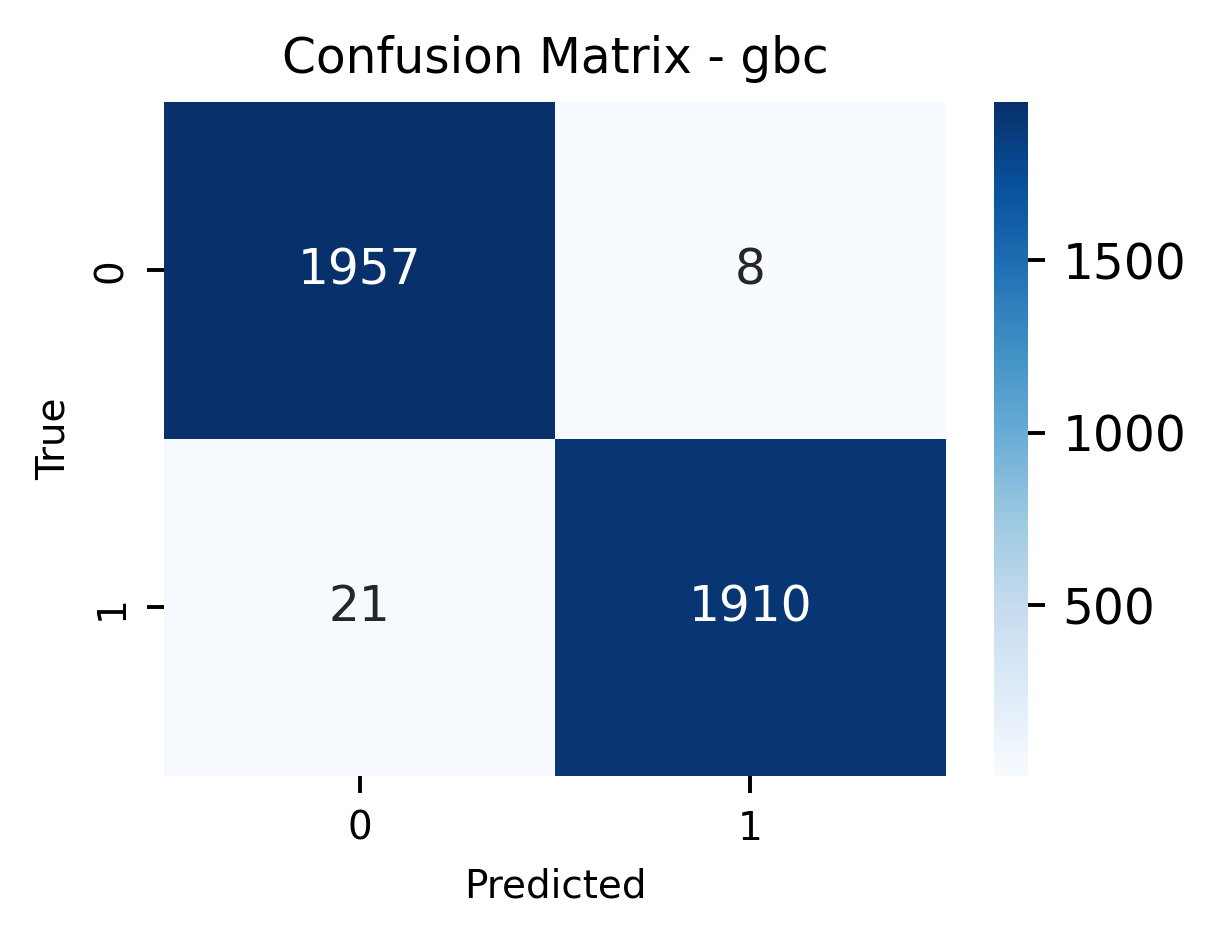

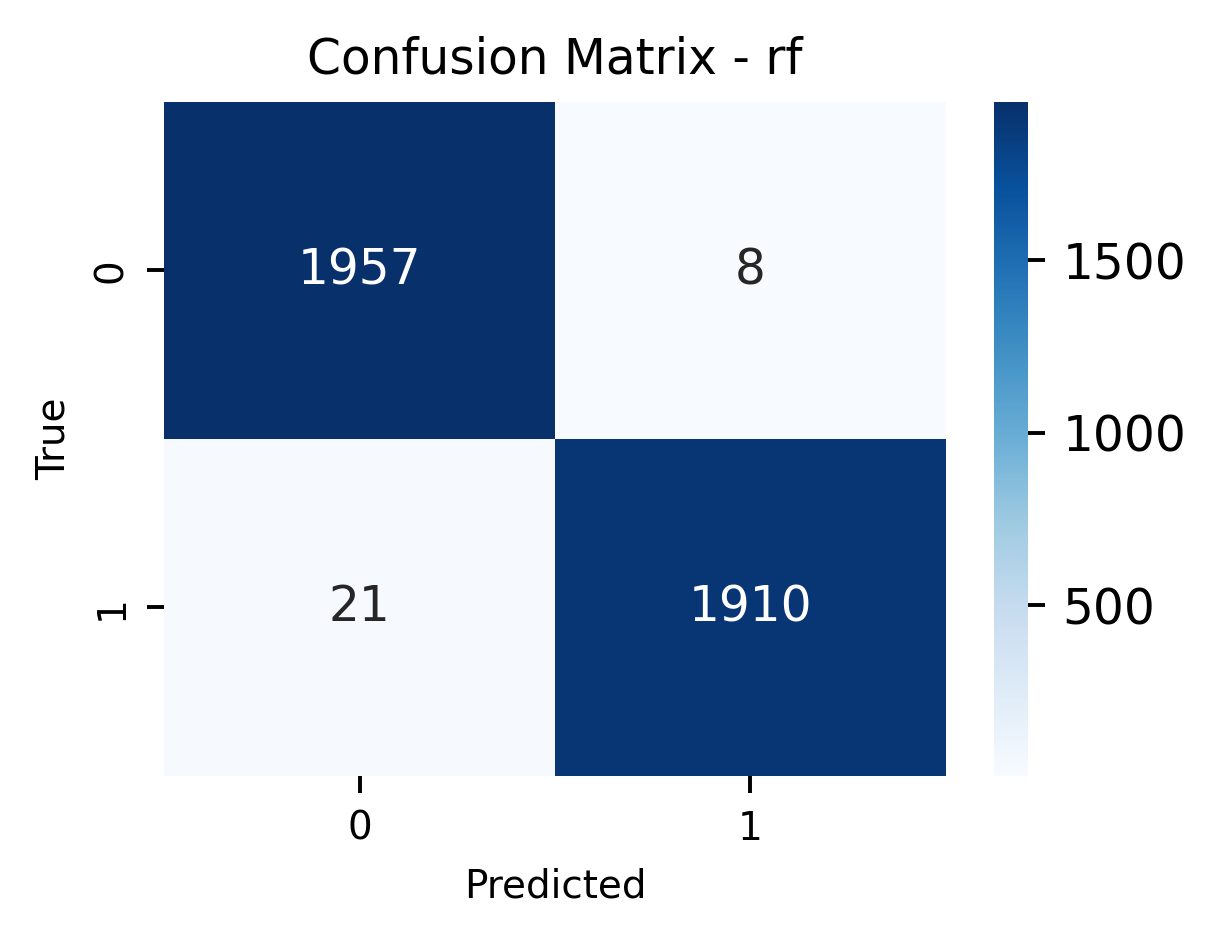

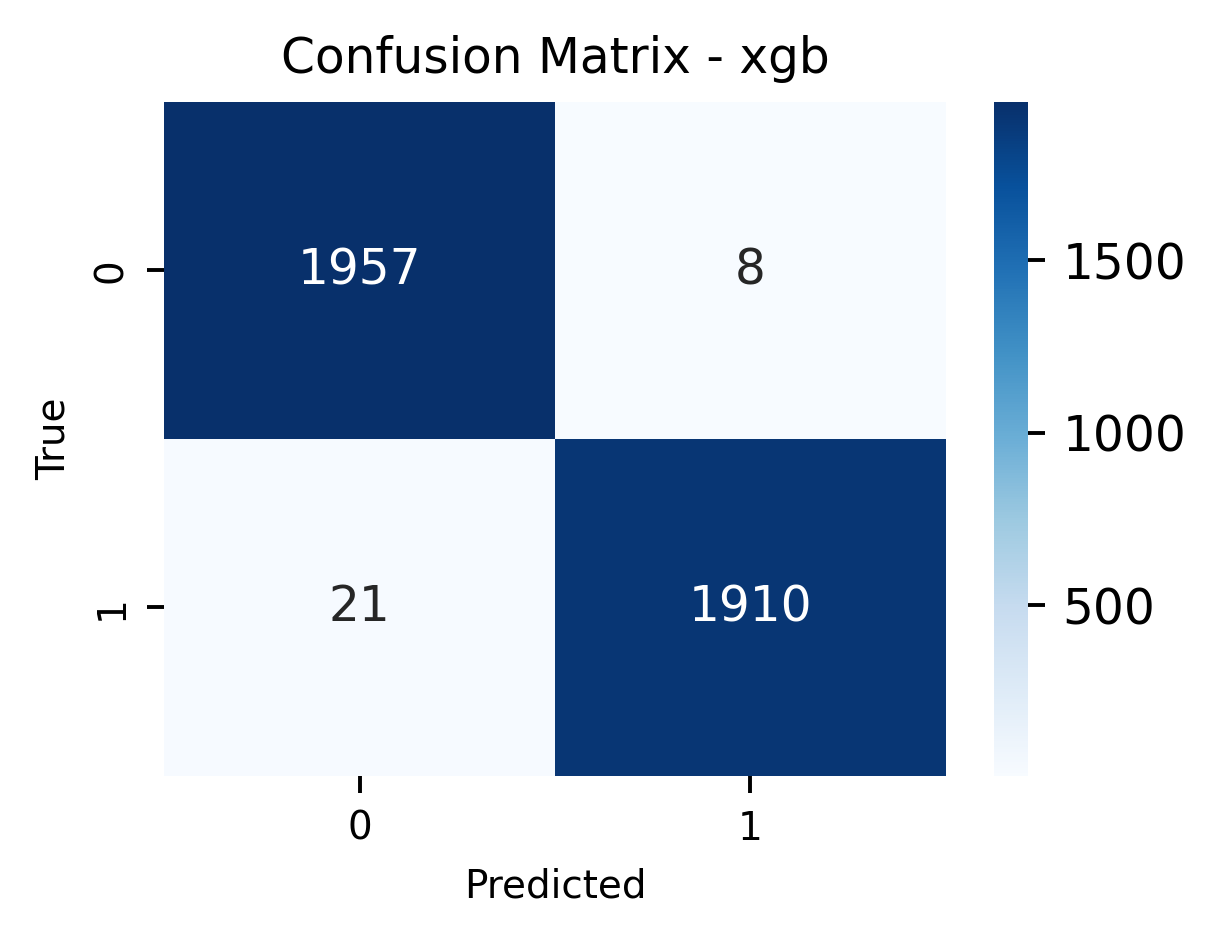

In [29]:
for model in top:
    y_pred = model.predict(test_df)
    y_pred = le.inverse_transform(y_pred)
    
    visualize_cl(y_true=y_test, y_pred=y_pred, model_name=model.steps[-1][0], report_dir=report_dir)

In [30]:
%%time
sr = summarize_results(top_models=top, report_dir=report_dir)

CPU times: user 226 ms, sys: 11.9 ms, total: 237 ms
Wall time: 250 ms


In [31]:
sr.head()

feature        p_value        score       gbc        rf       xgb      mean
0  p403_TN  3.366301e-100   451.520780  0.011288  0.034983  0.004785  0.017019
1   p426_T   0.000000e+00  4161.890326  0.134056  0.743017  0.011318  0.296130
2   p670_T   0.000000e+00  1476.162340  0.134056  0.743017  0.011318  0.296130
3   p671_N   0.000000e+00  3893.308374  0.134056  0.743017  0.011318  0.296130
4   p672_N   0.000000e+00  3928.117539  0.134056  0.743017  0.011318  0.296130

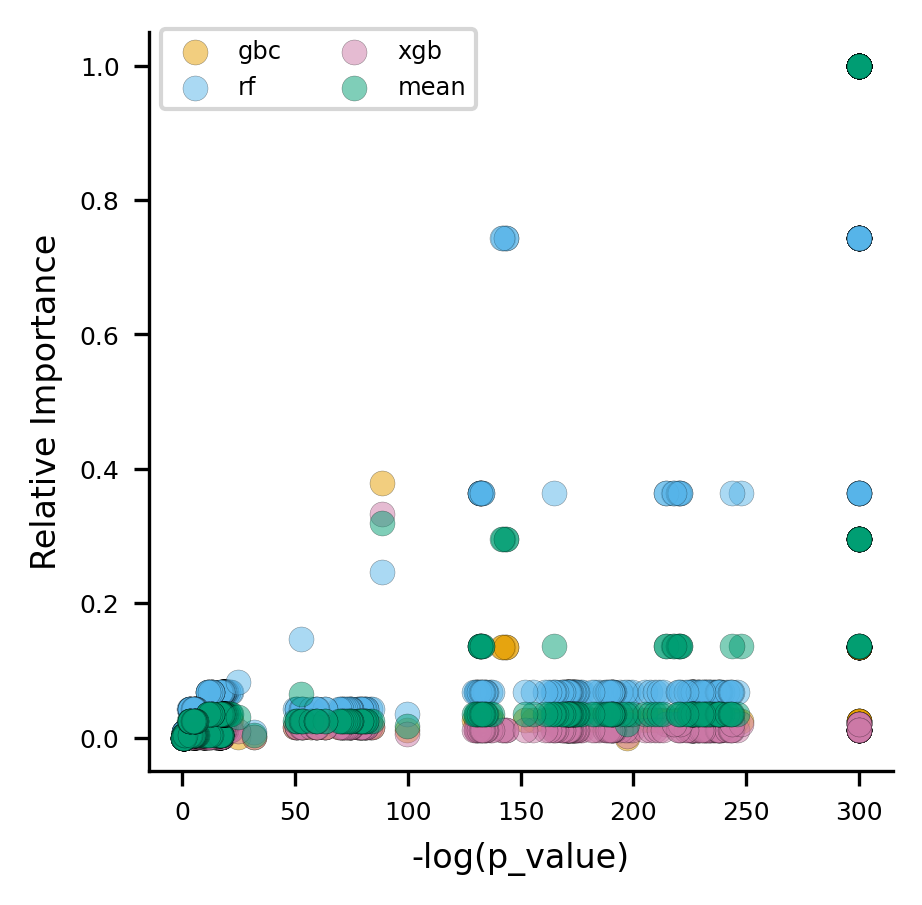

In [32]:
scatter_plot = plot_scatter(summary_result=sr, report_dir=report_dir)

In [33]:
top[0][-1].feature_names_in_

array(['p403_TN', 'p674_N', 'p4834_N', 'p5693_N', 'p6356_G', 'p6784_T',
       'p7417_N', 'p7457_T', 'p8619_T', 'p8641_G', 'p9266_N'],
      dtype=object)

In [34]:
top[0][-1].feature_importances_

array([6.99736962e-03, 8.31010585e-02, 1.50861546e-02, 2.54803523e-04,
       1.31308970e-02, 4.19304291e-05, 1.61254533e-02, 2.35199239e-01,
       7.00017400e-04, 6.19897741e-01, 9.46533637e-03])

In [35]:
%%time
mean_imp = mean_importance(top, report_dir=report_dir, aggregate_function='max')

CPU times: user 176 ms, sys: 28.6 ms, total: 204 ms
Wall time: 100 ms


In [36]:
mean_imp

feature  gbc   rf  xgb  mean
0            1  0.0  0.0  0.0   0.0
1            2  0.0  0.0  0.0   0.0
2            3  0.0  0.0  0.0   0.0
3            4  0.0  0.0  0.0   0.0
4            5  0.0  0.0  0.0   0.0
...        ...  ...  ...  ...   ...
14600    14601  0.0  0.0  0.0   0.0
14601    14602  0.0  0.0  0.0   0.0
14602    14603  0.0  0.0  0.0   0.0
14603    14604  0.0  0.0  0.0   0.0
14604    14605  0.0  0.0  0.0   0.0

[14605 rows x 5 columns]

mean Done


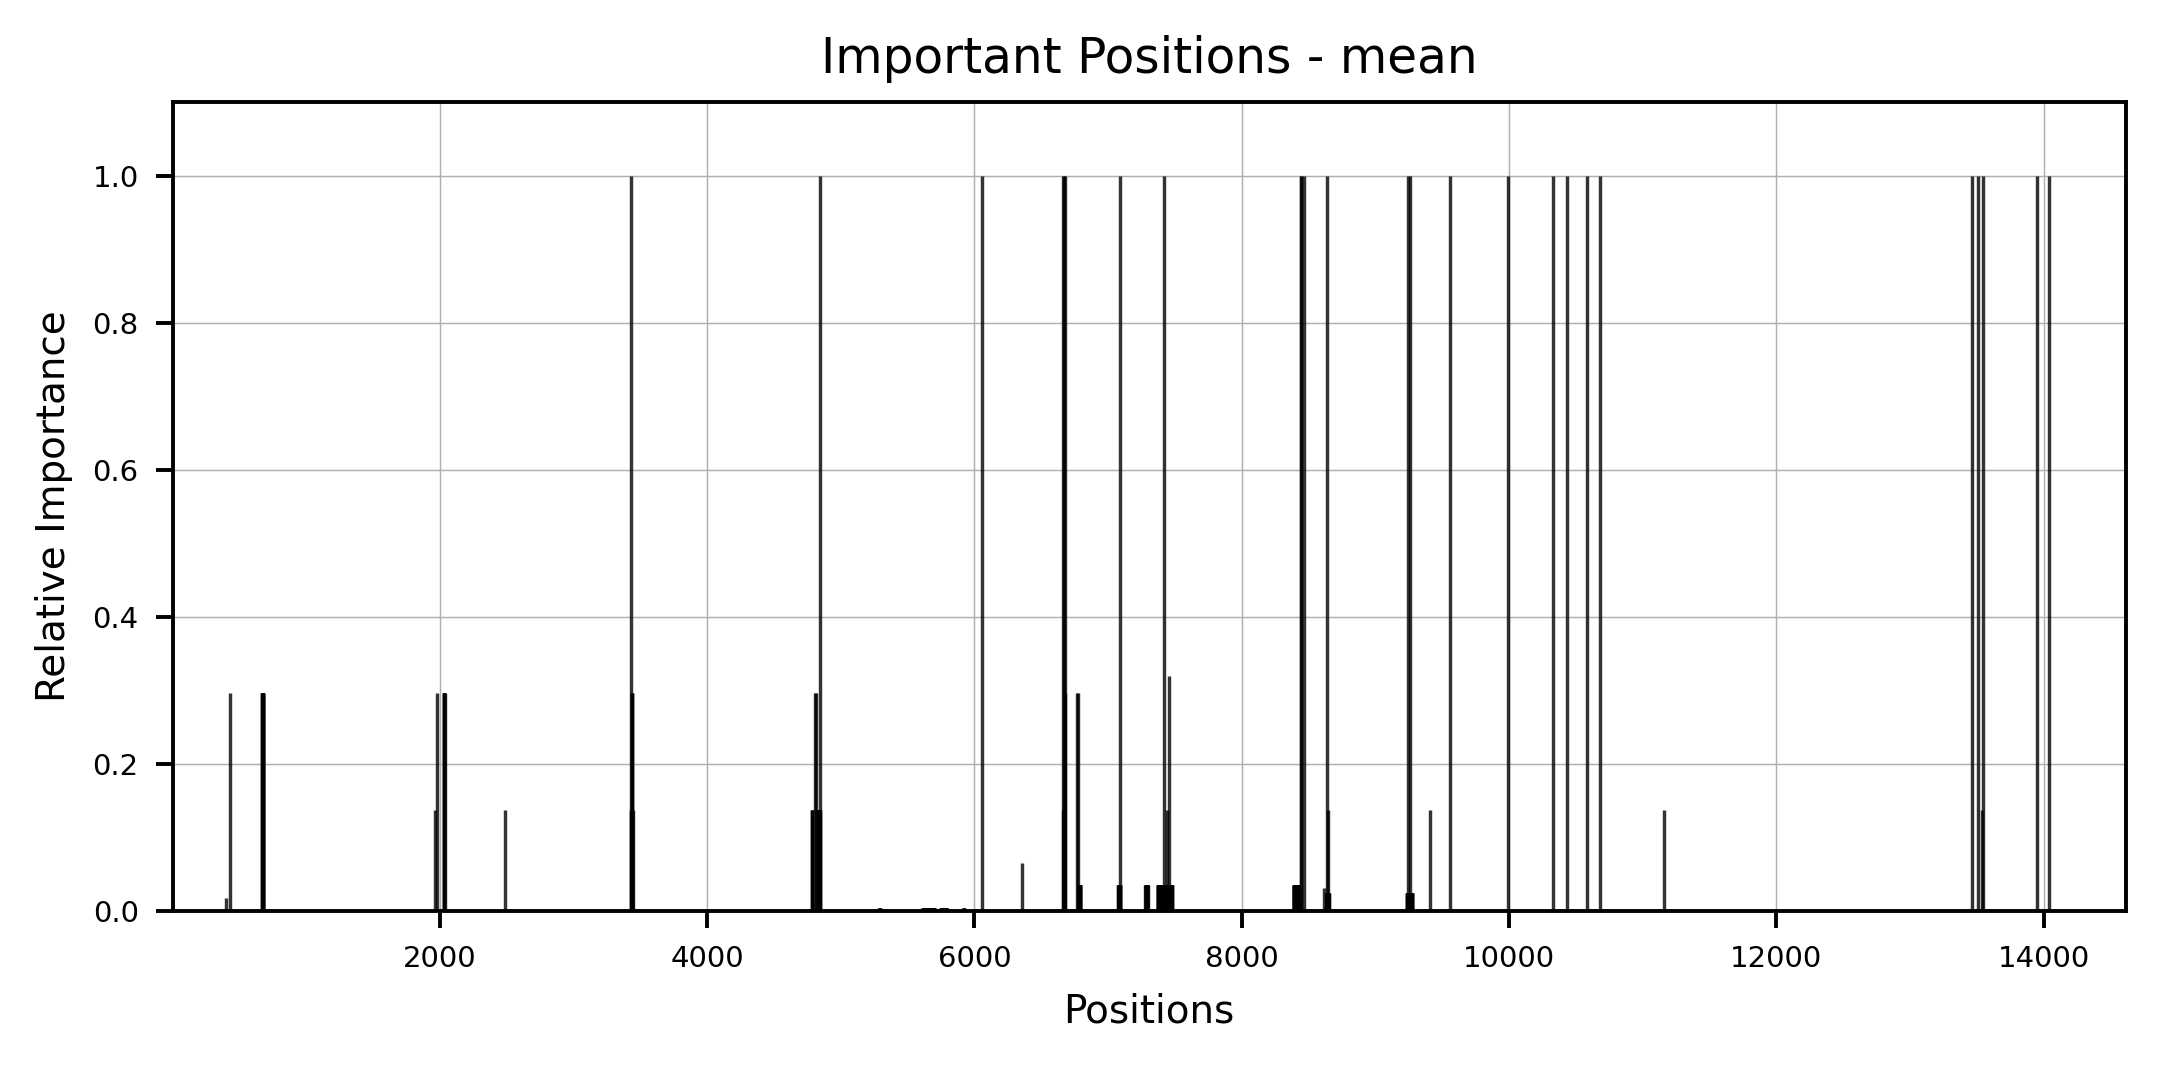

In [37]:
dp_plot(importance=mean_imp,imp_col='mean', model_name='mean', report_dir=report_dir, annotate=0)

In [38]:
tr = prep_pipeline[:4].fit_transform(tr)
y = le.inverse_transform(y)

gbc Done
gbc  Done
rf Done
rf  Done
xgb Done
xgb  Done


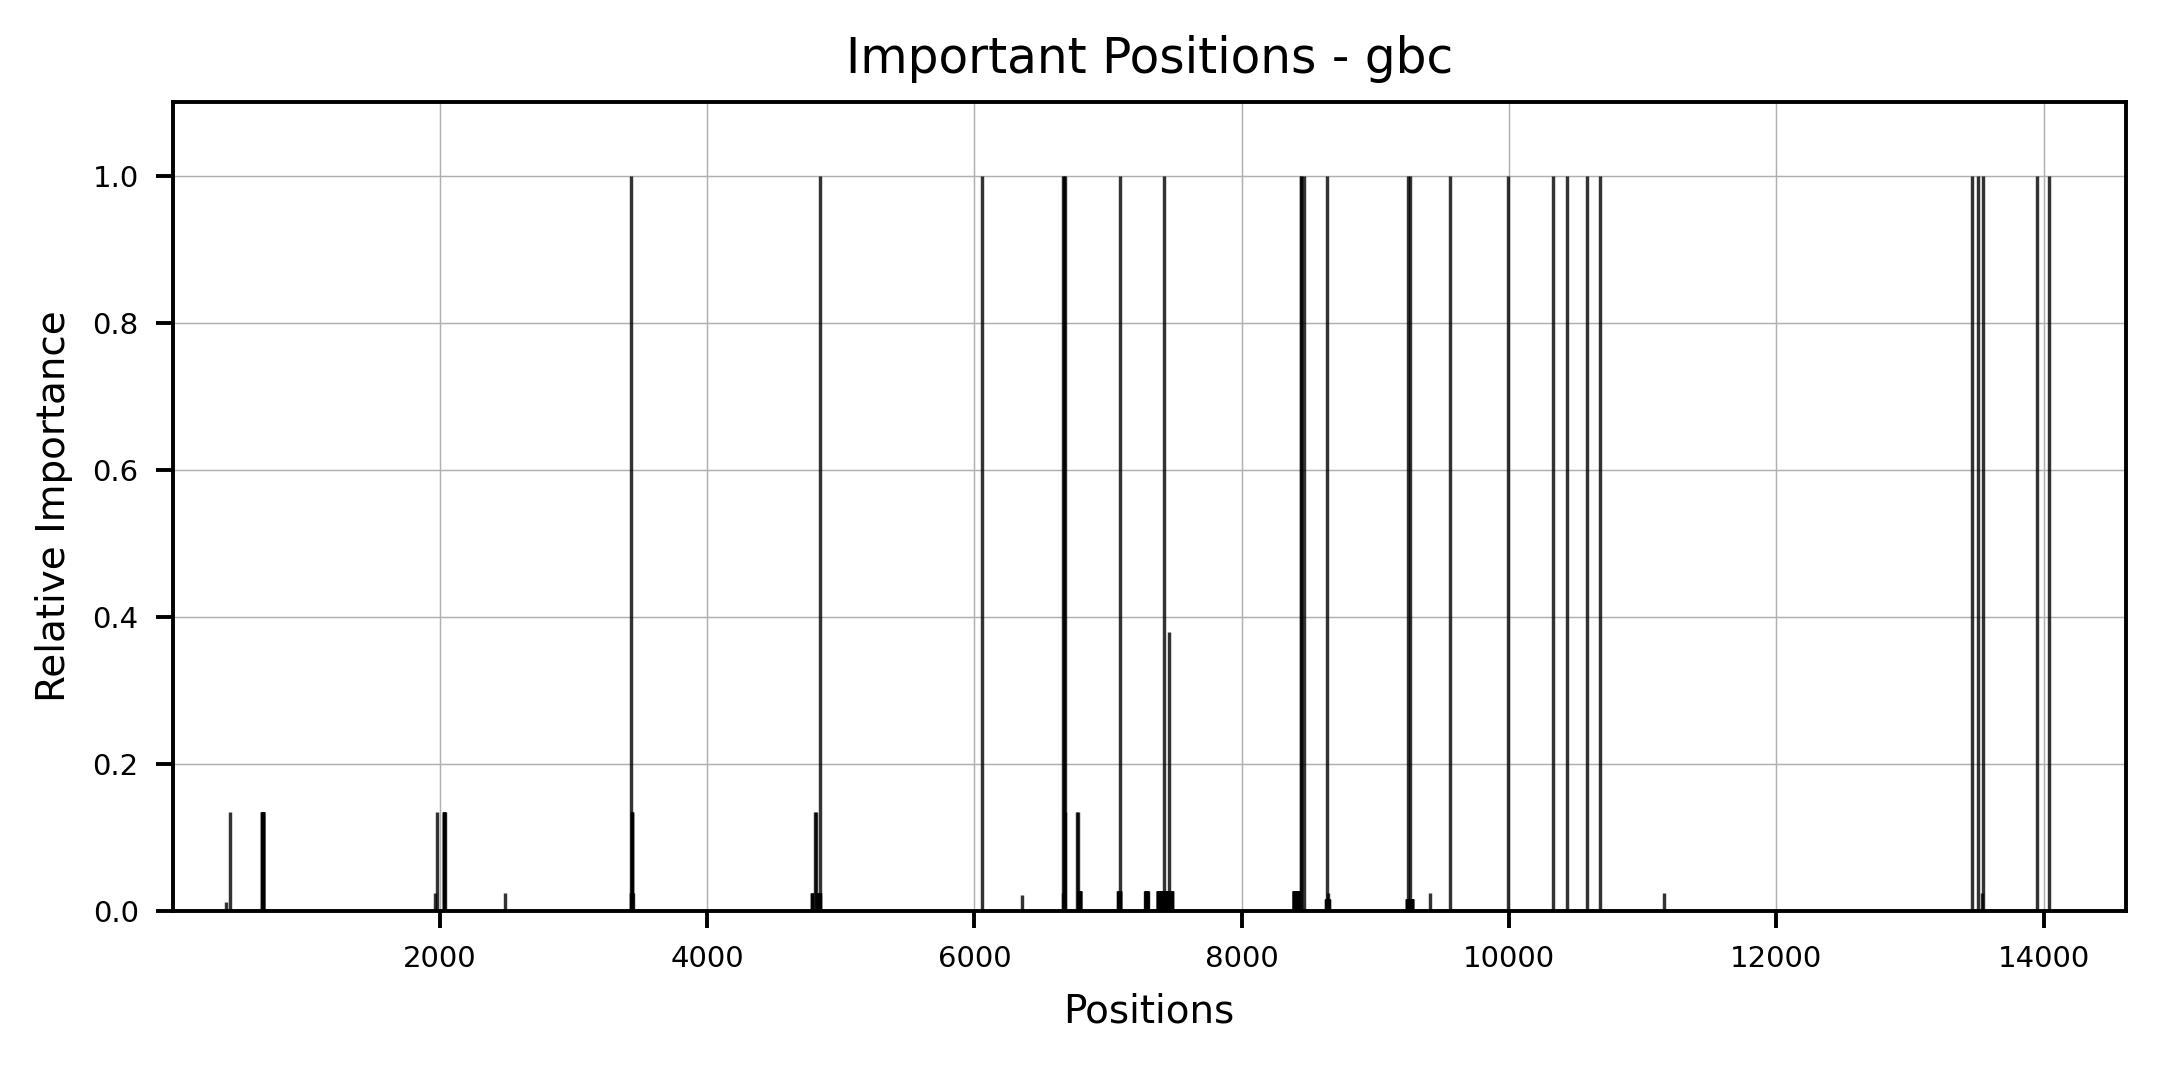

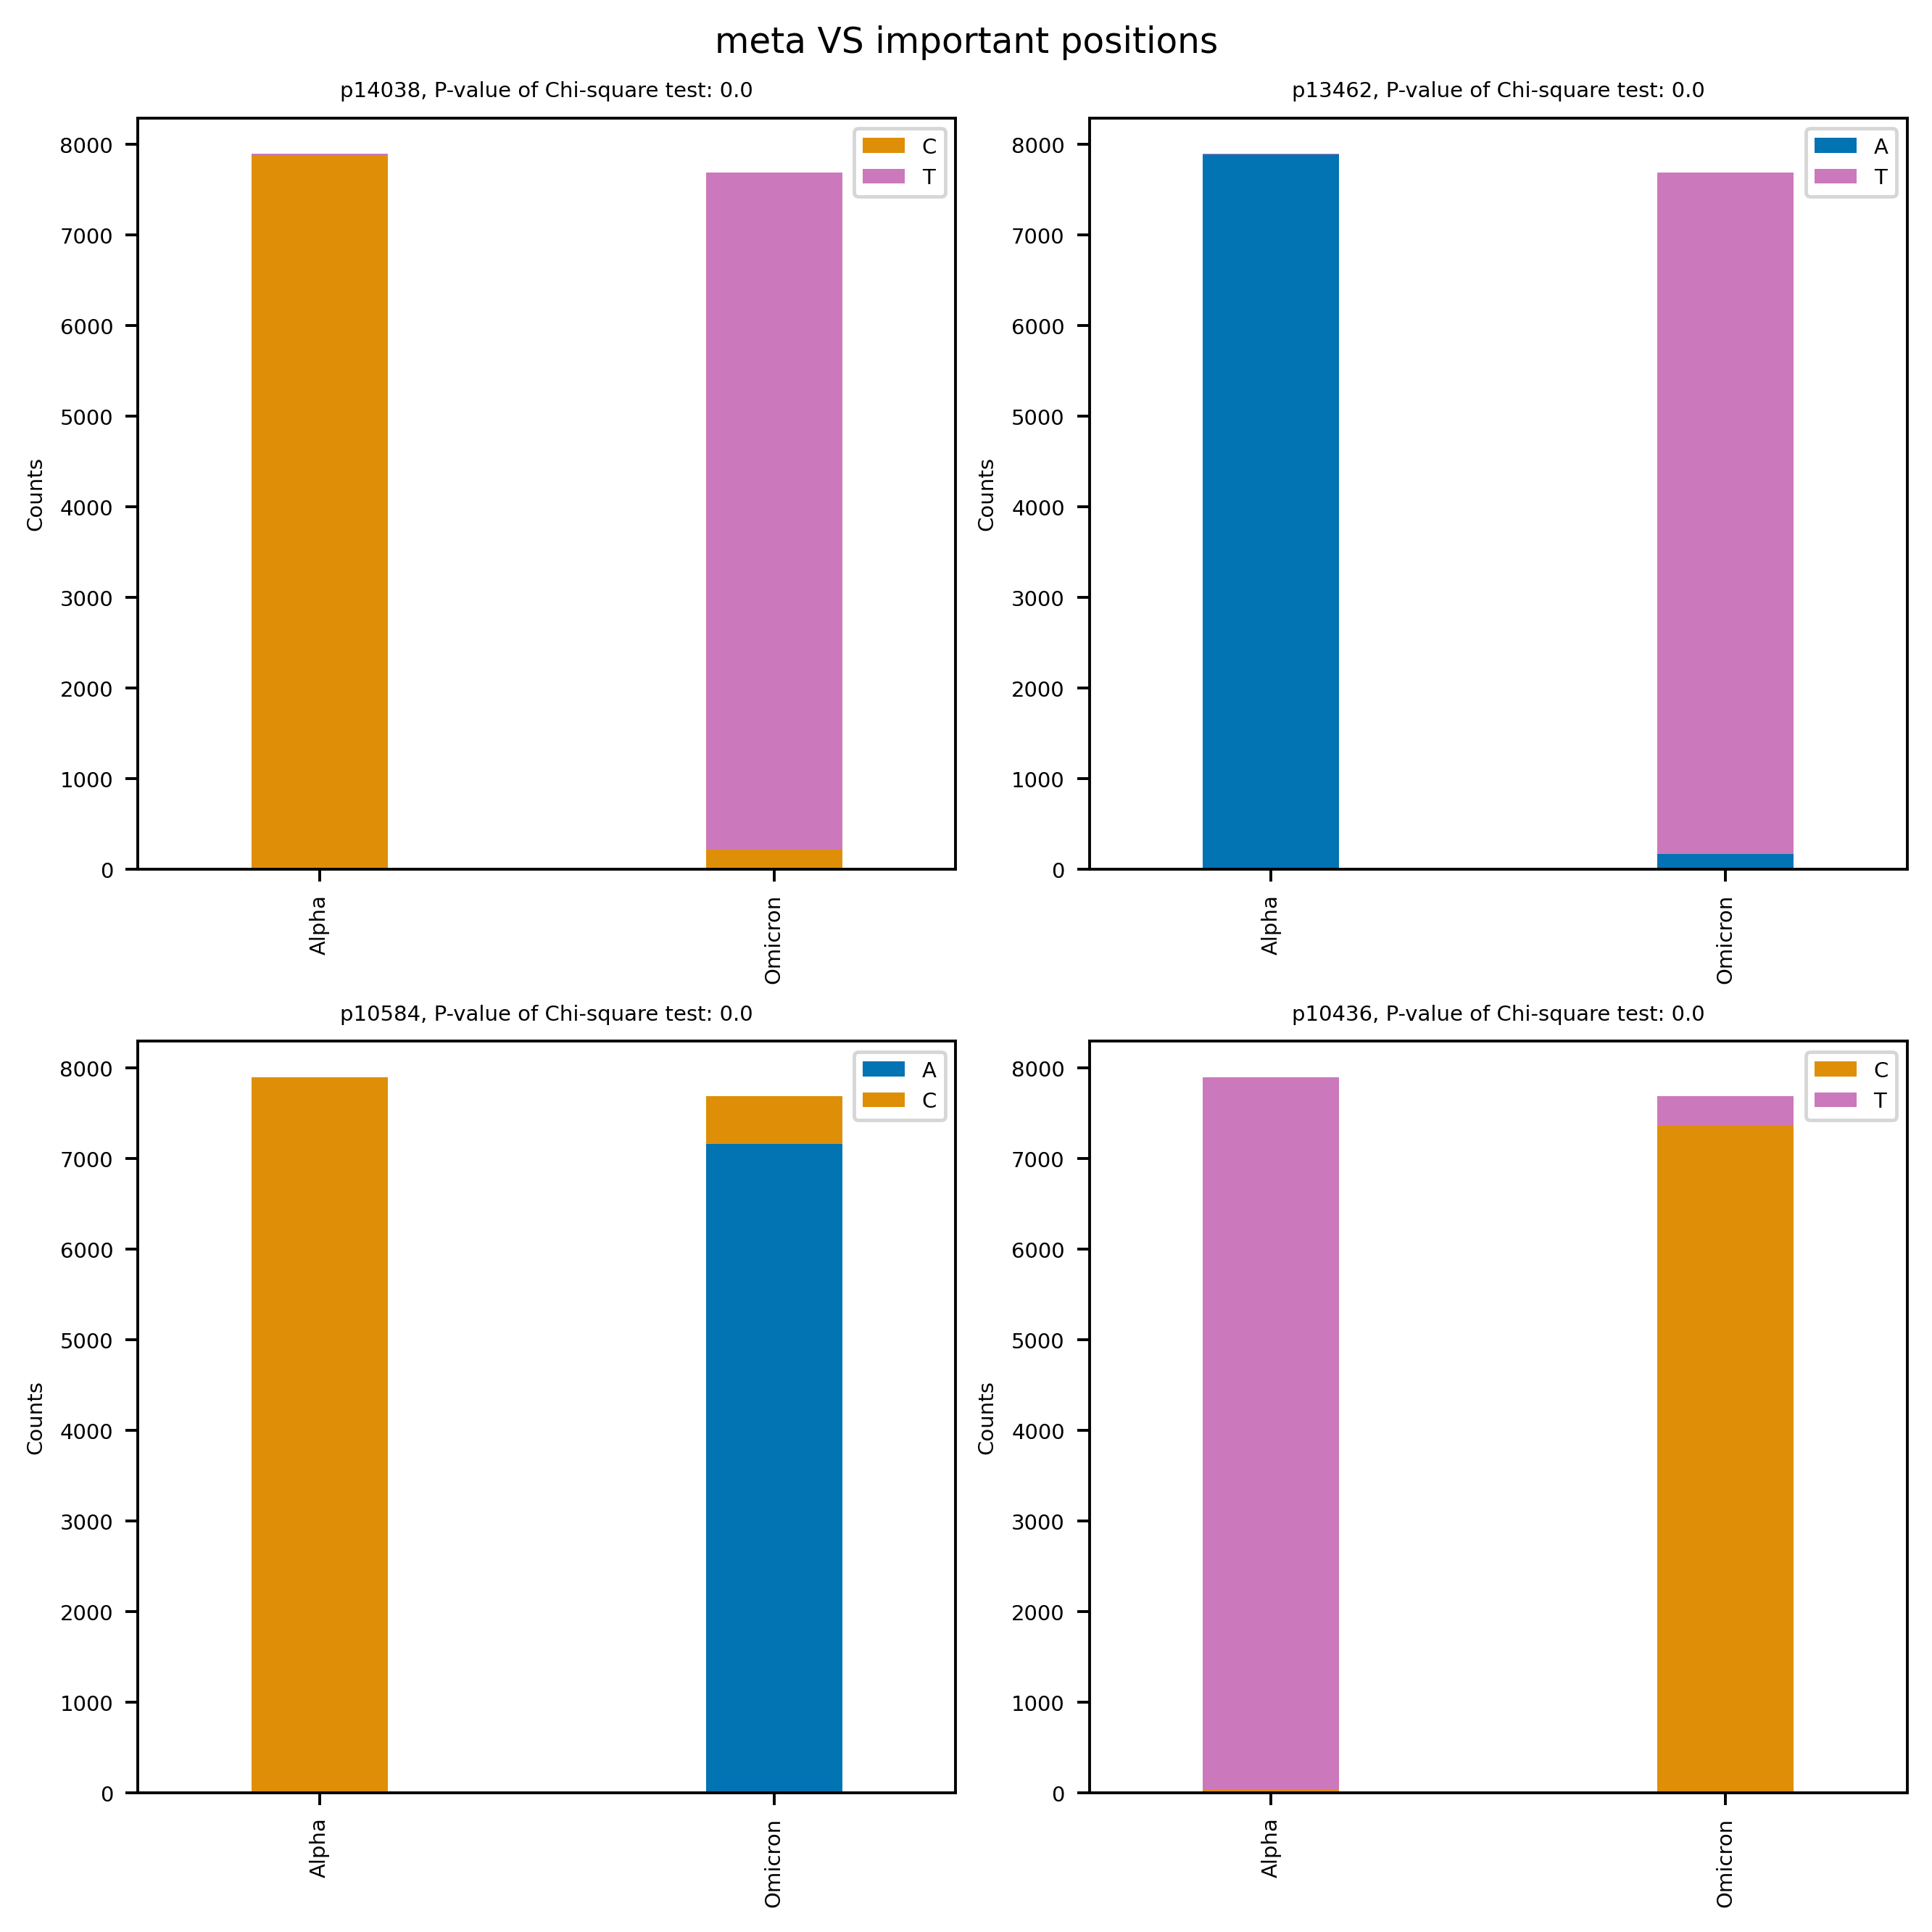

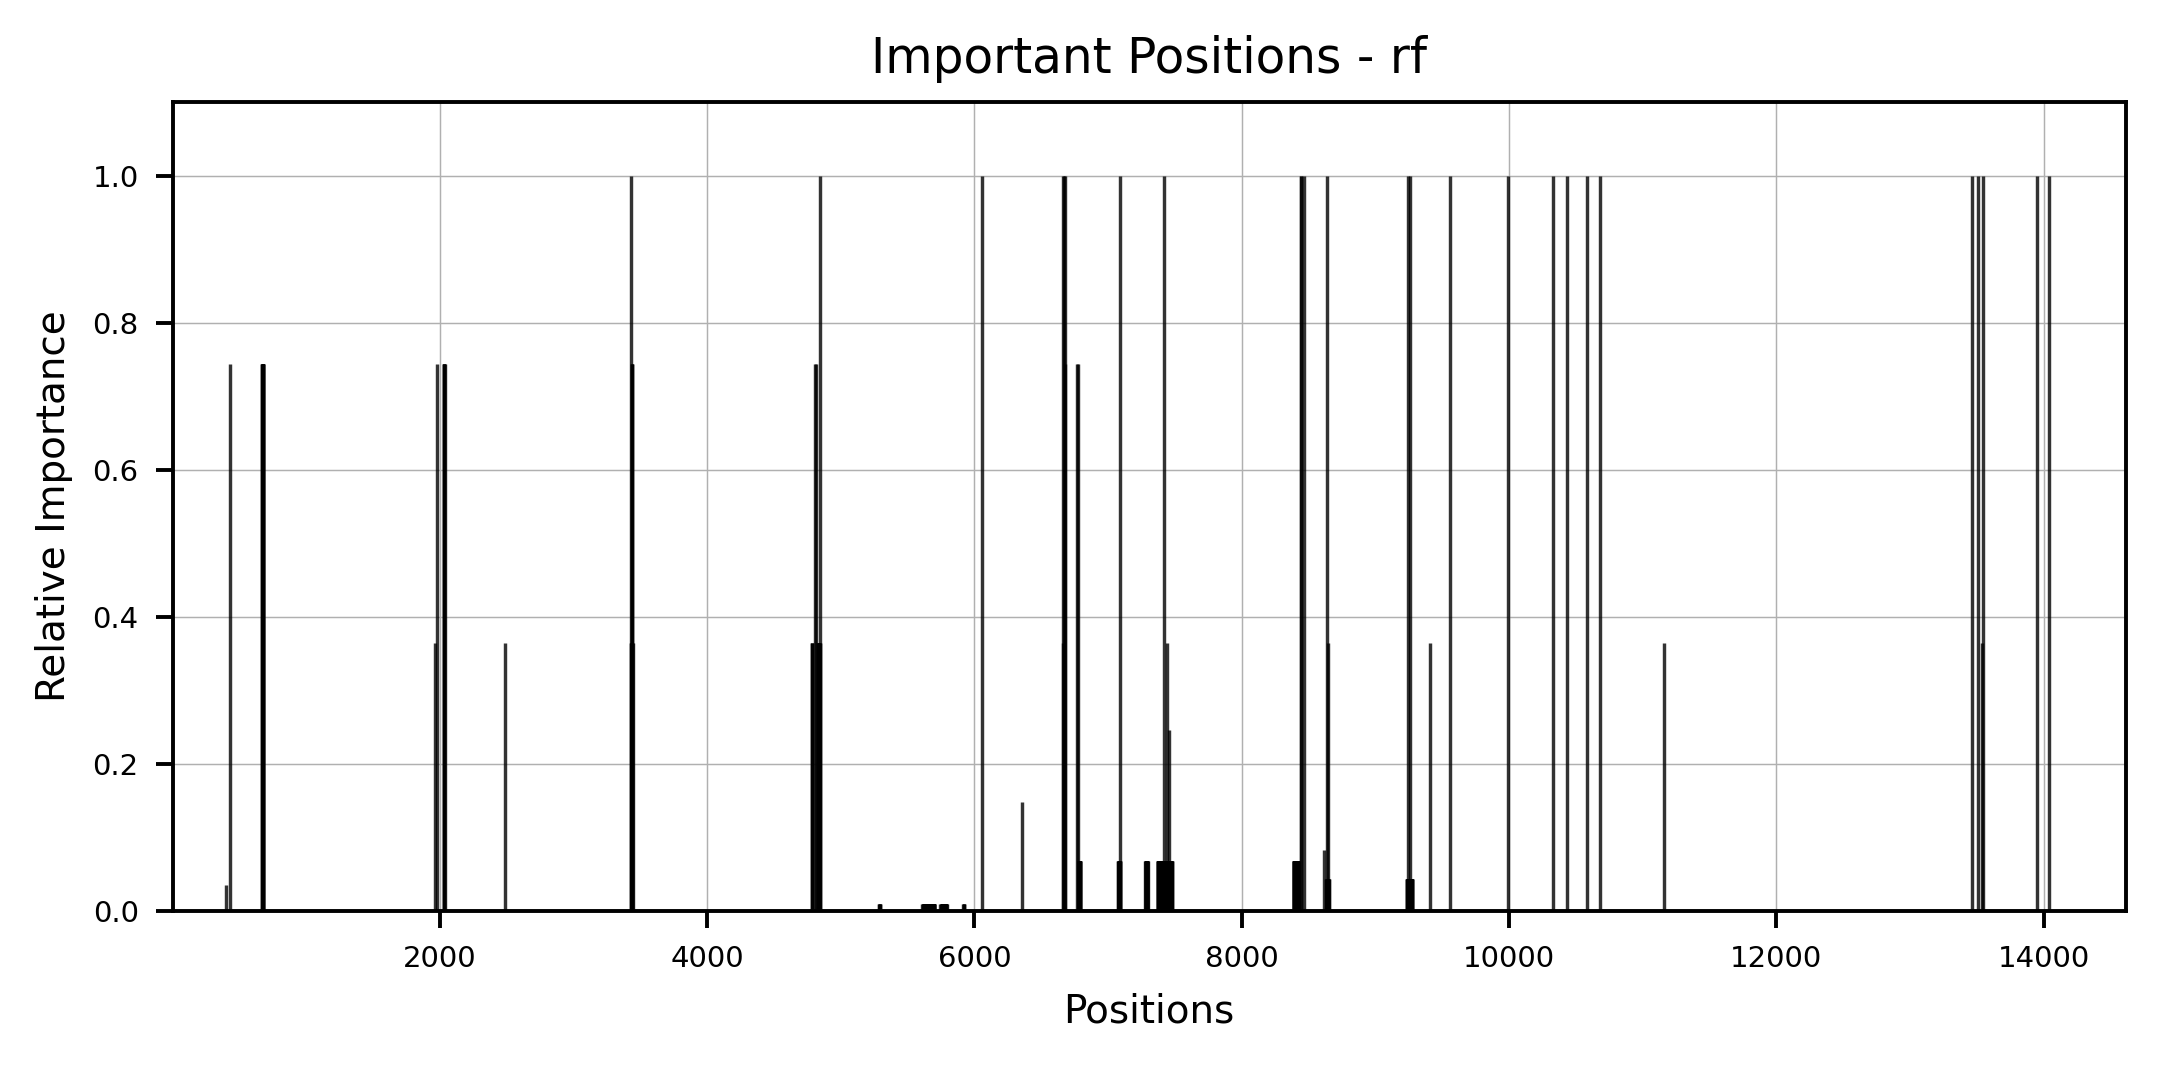

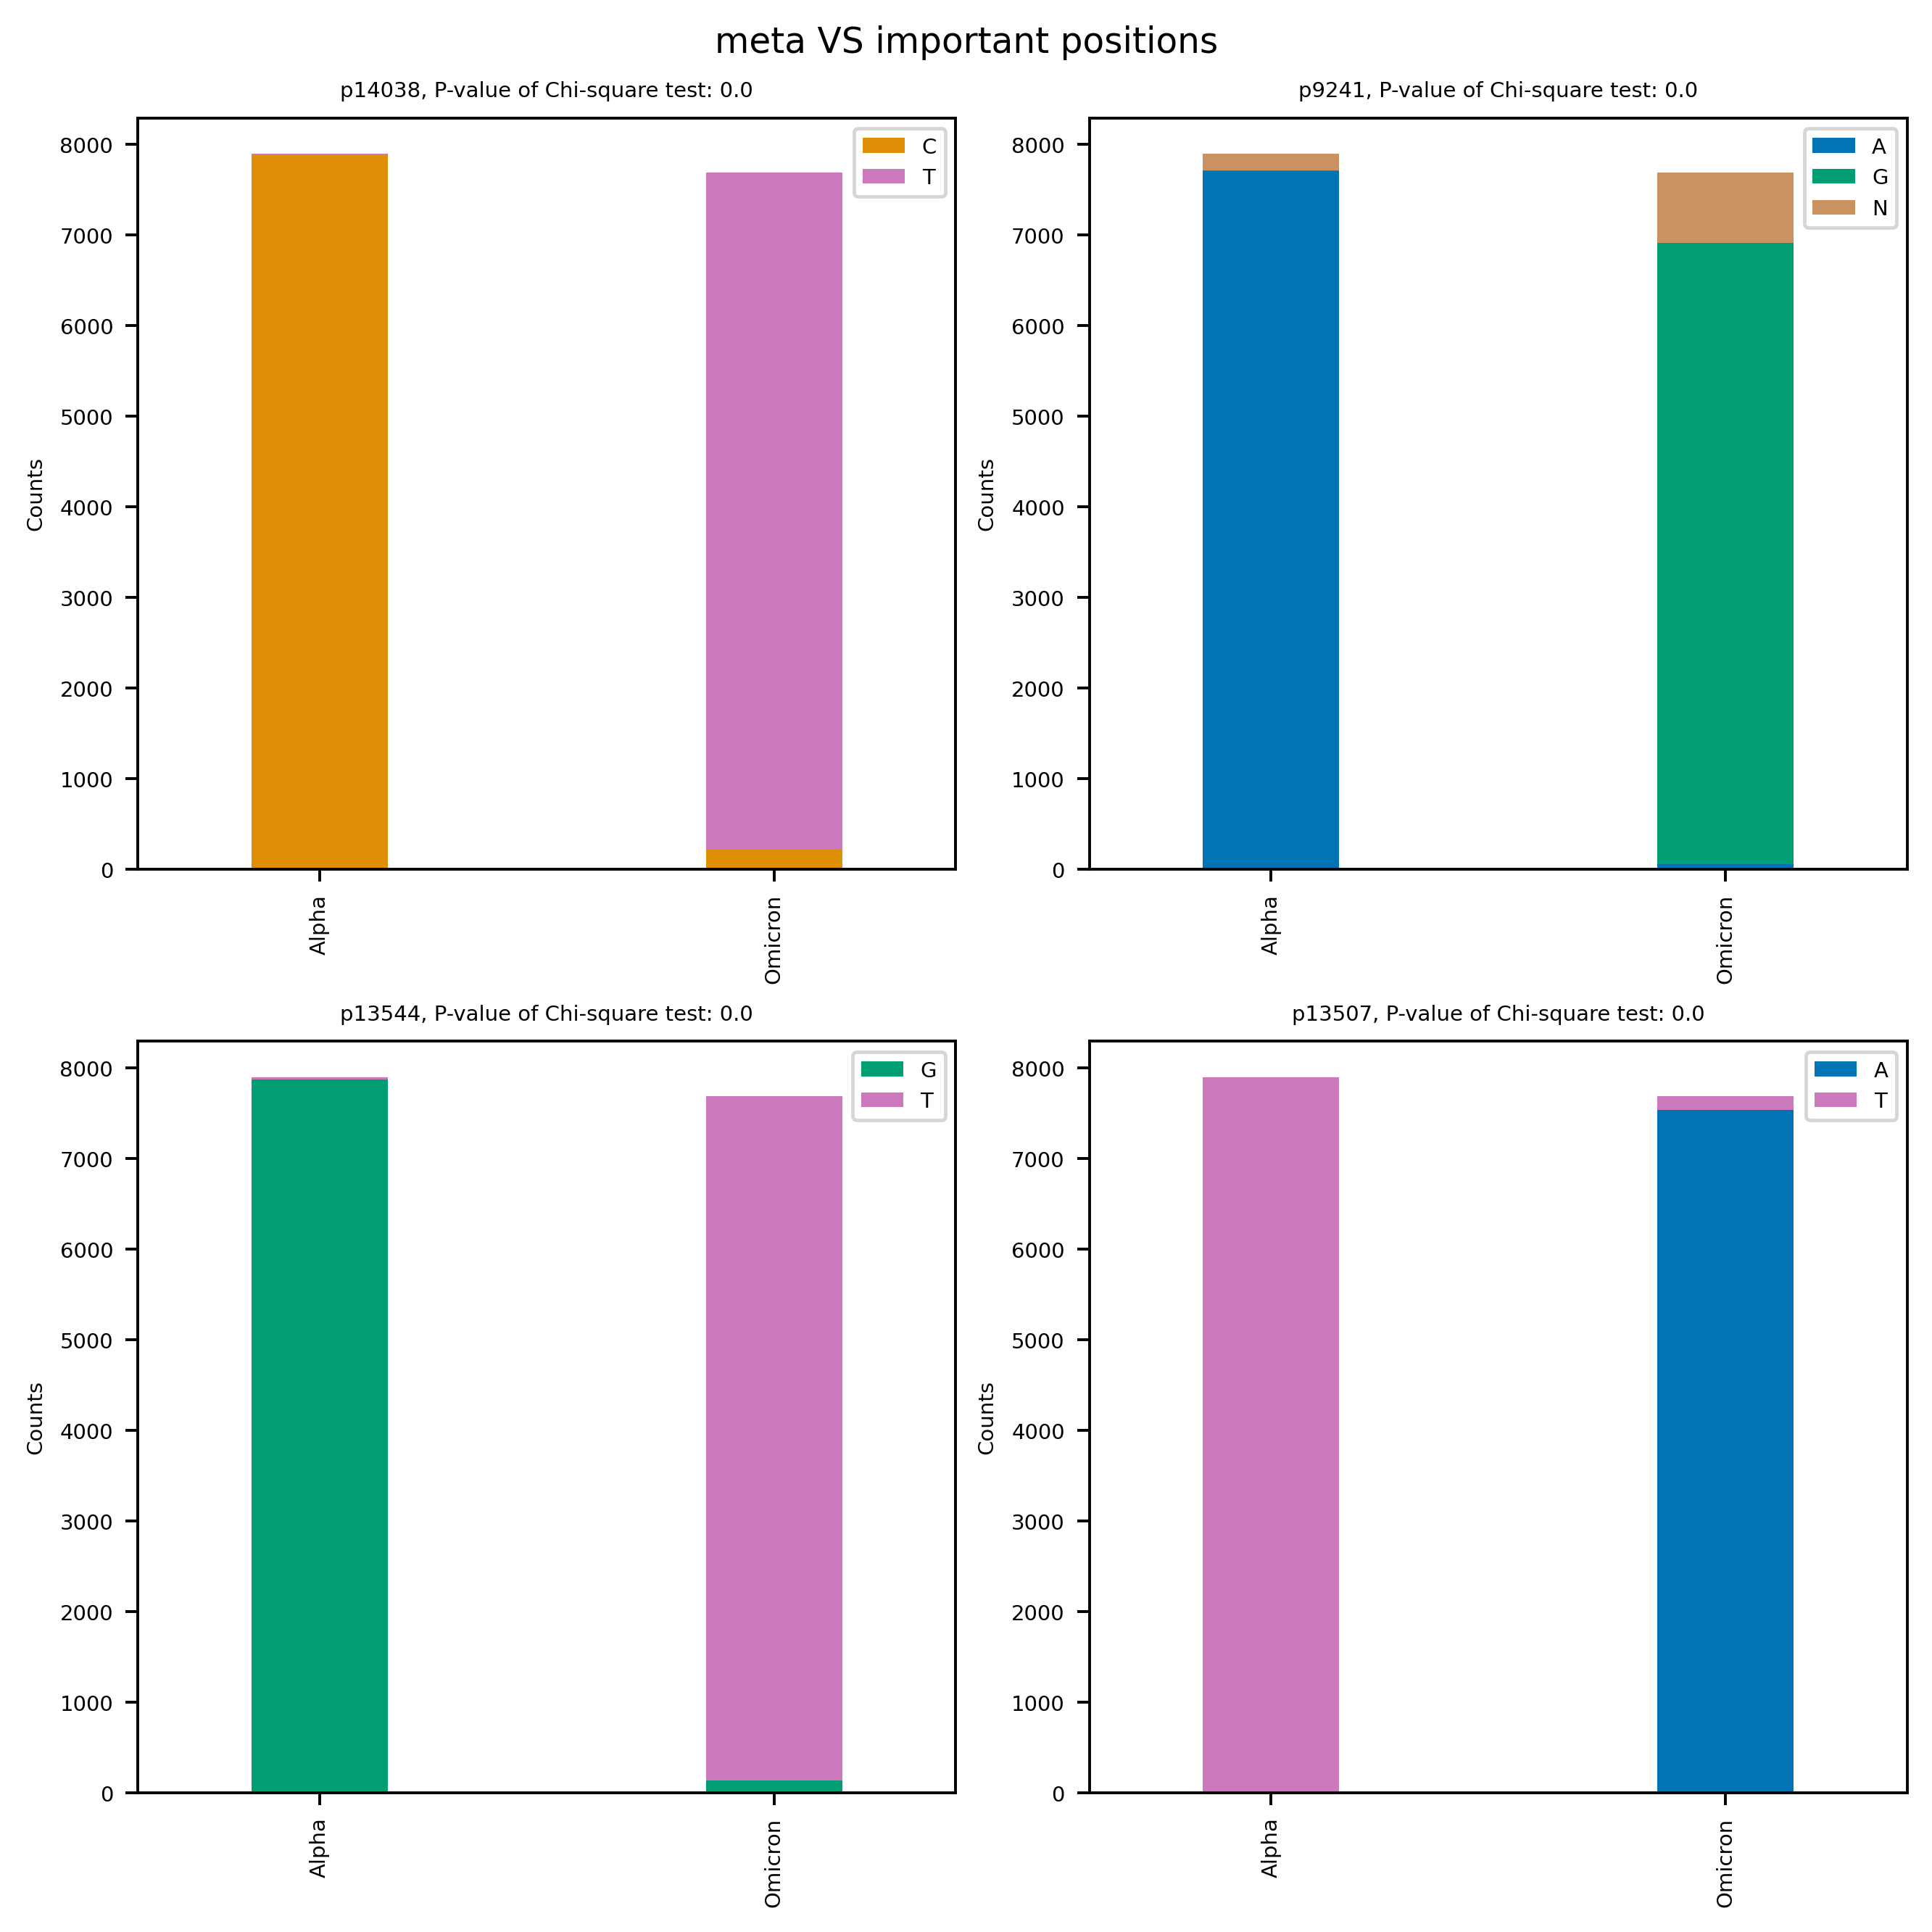

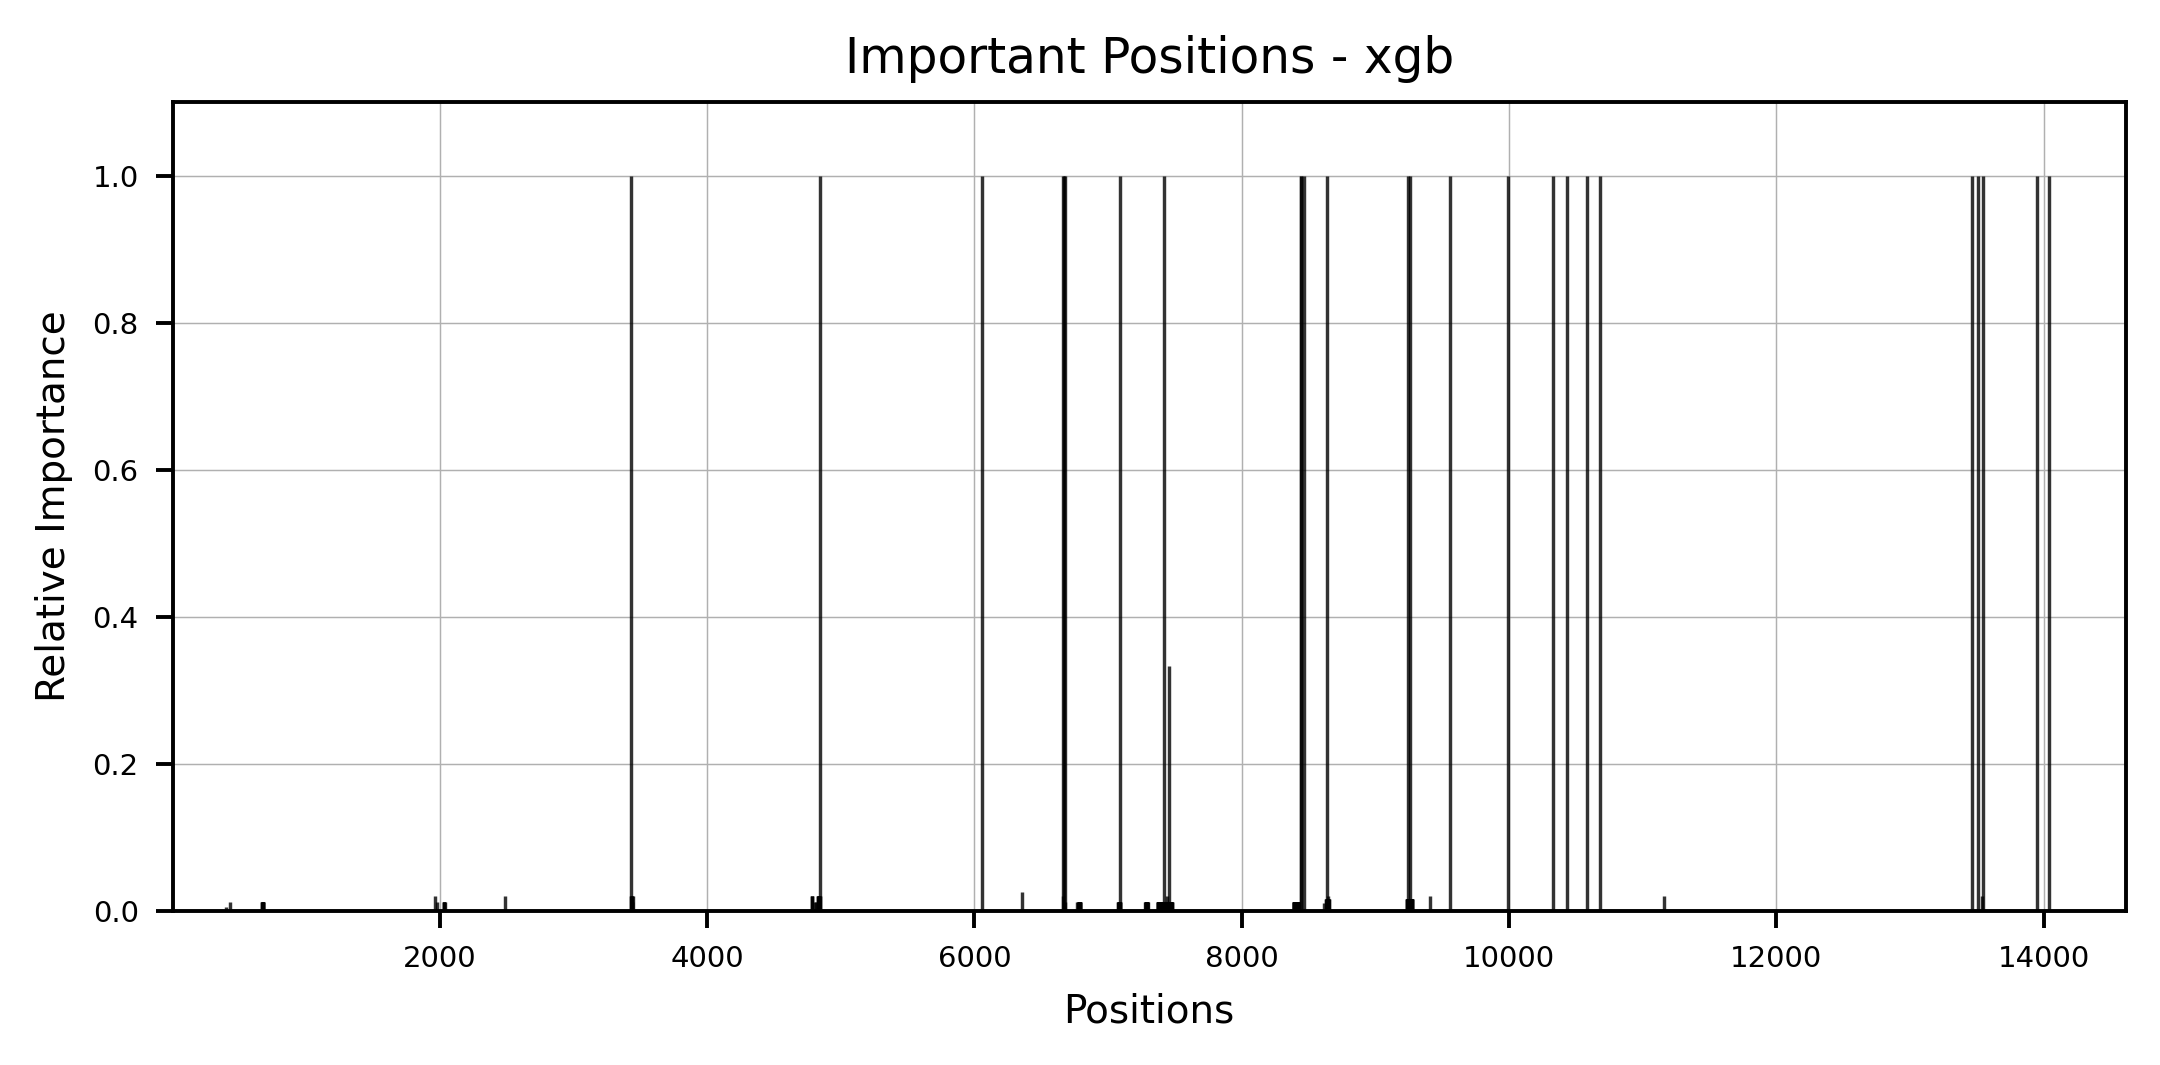

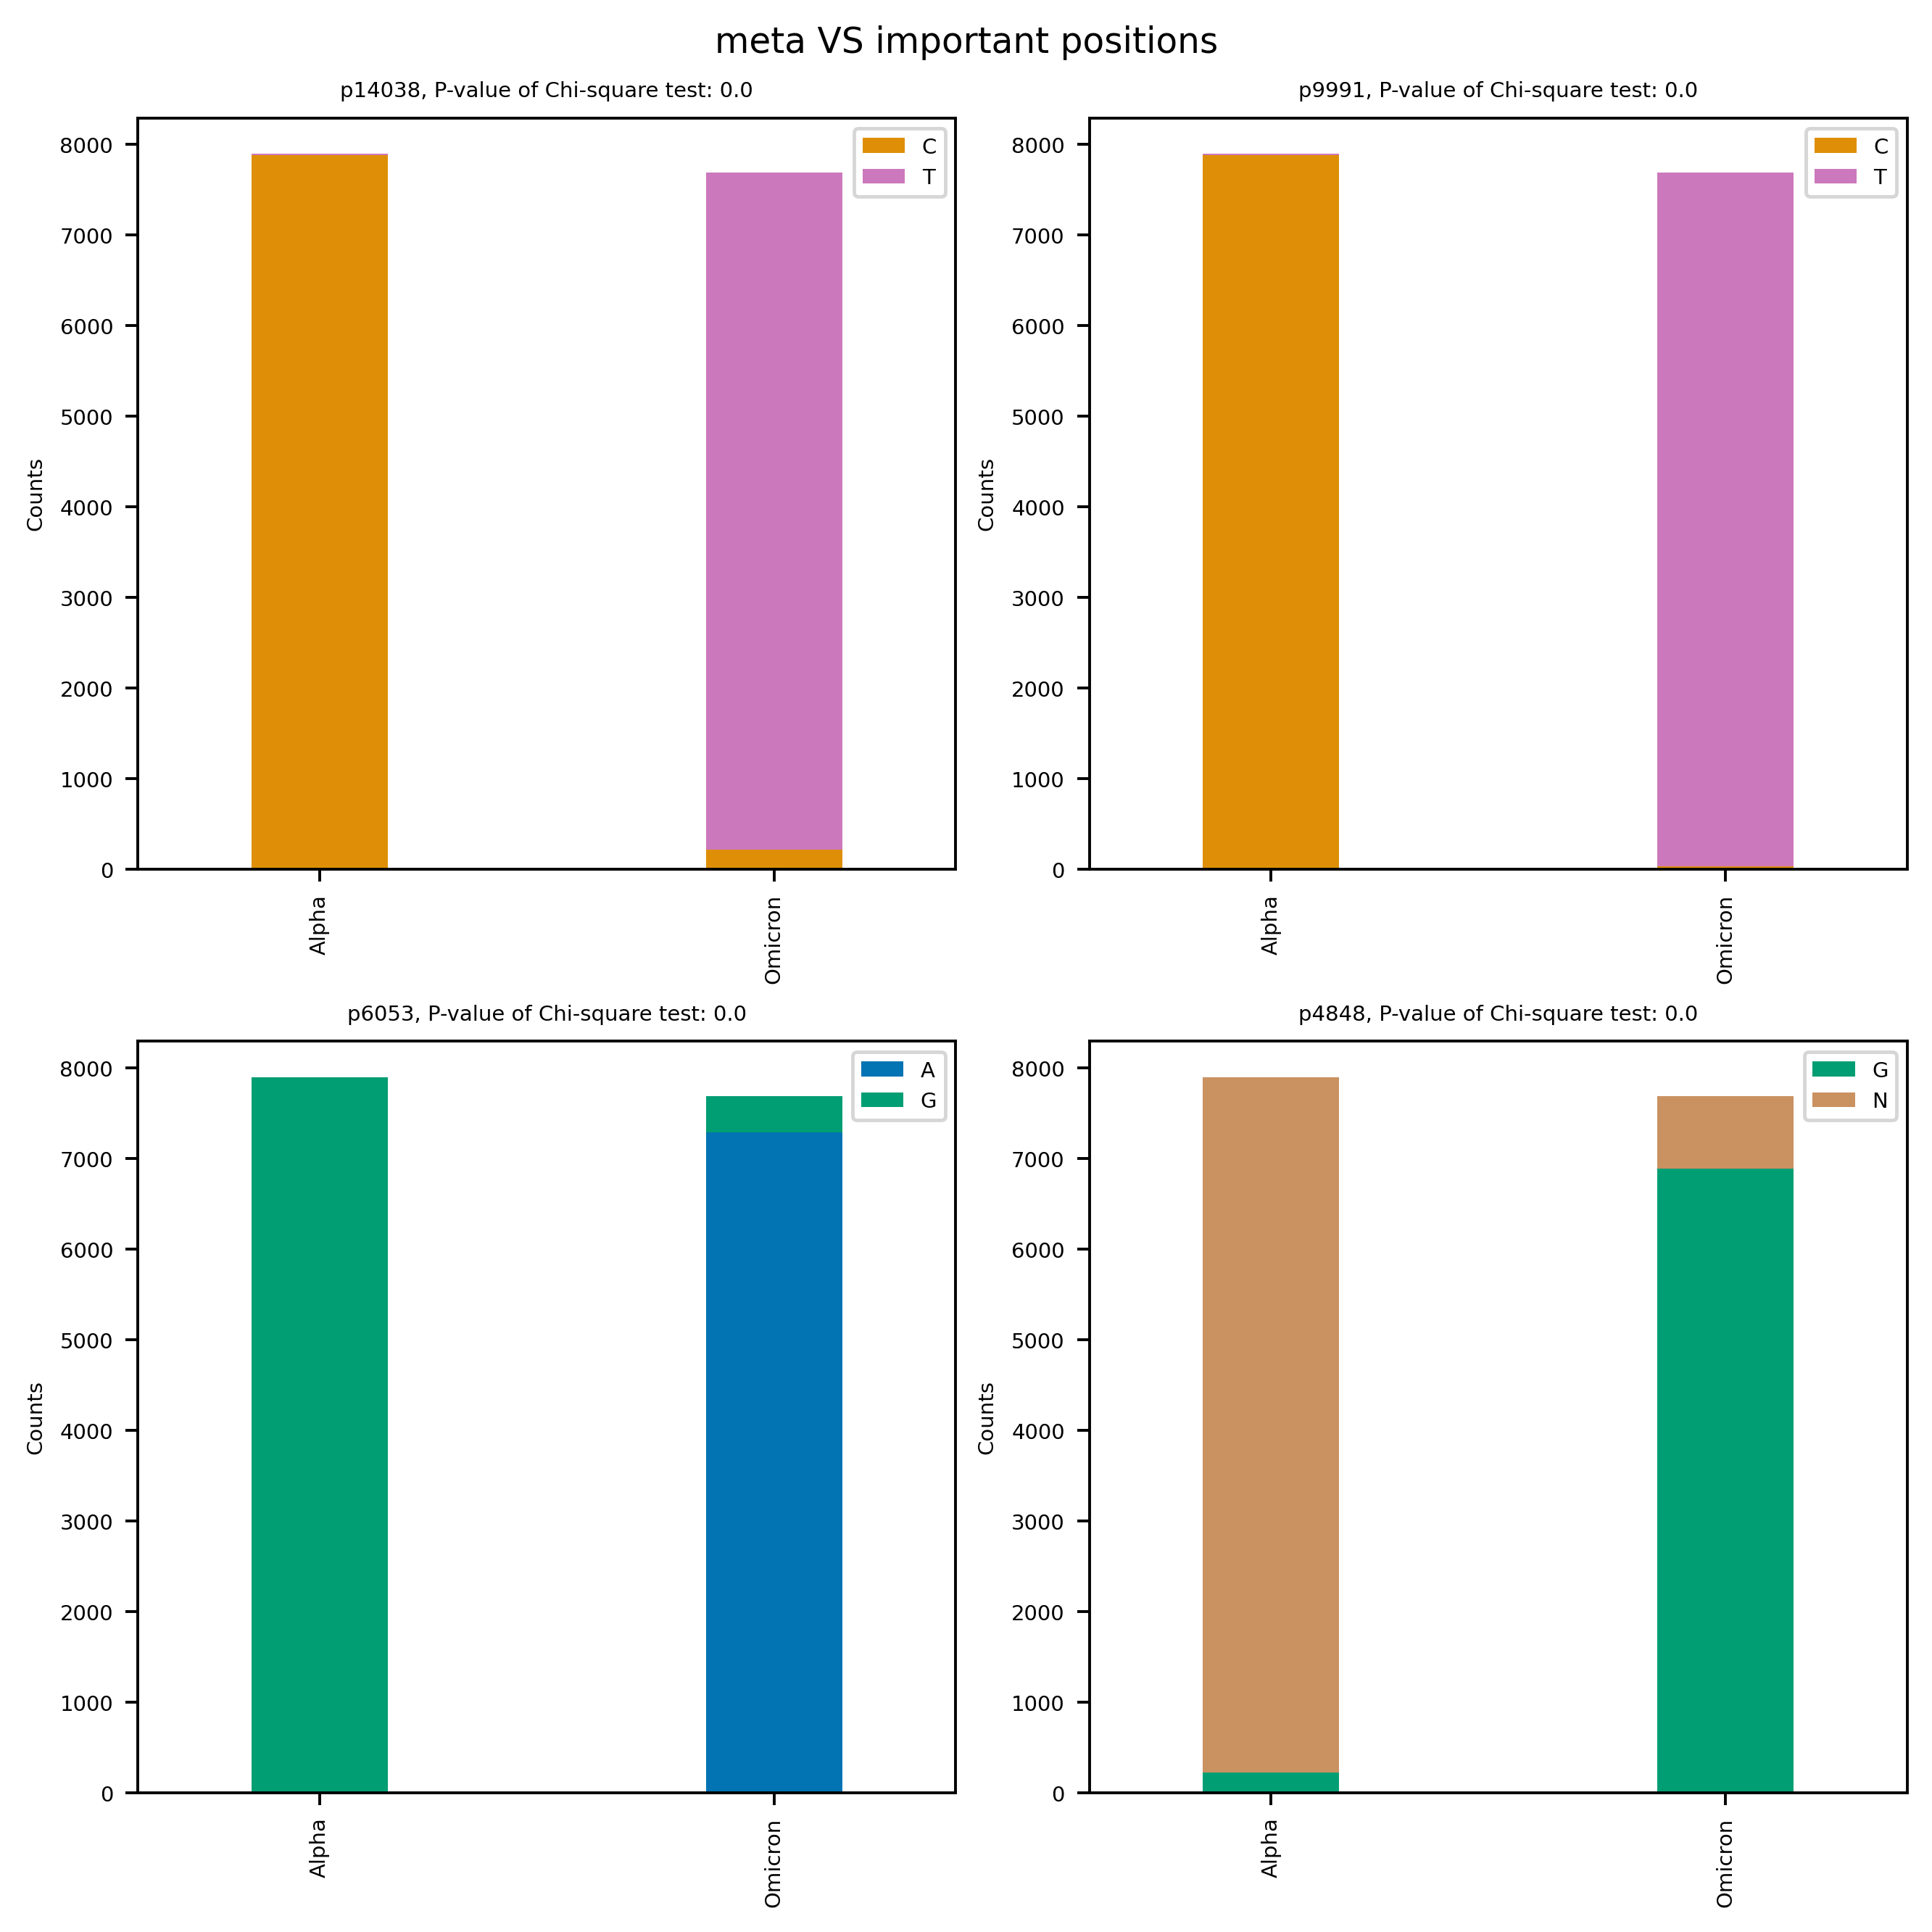

In [39]:
for model in top:
    model_name = model.steps[-1][0]
    dp_plot(importance=importance_from_pipe(model, aggregate_function='max'),
            imp_col='standard_value', annotate=0,
            model_name = model_name, report_dir=report_dir)
    
    plot_imp_model(importance=importance_from_pipe(model, aggregate_function='max'),
                   X_train=tr, y_train=y, model_name=model_name,
                   meta_var='meta', model_type=ana_type, report_dir=report_dir)

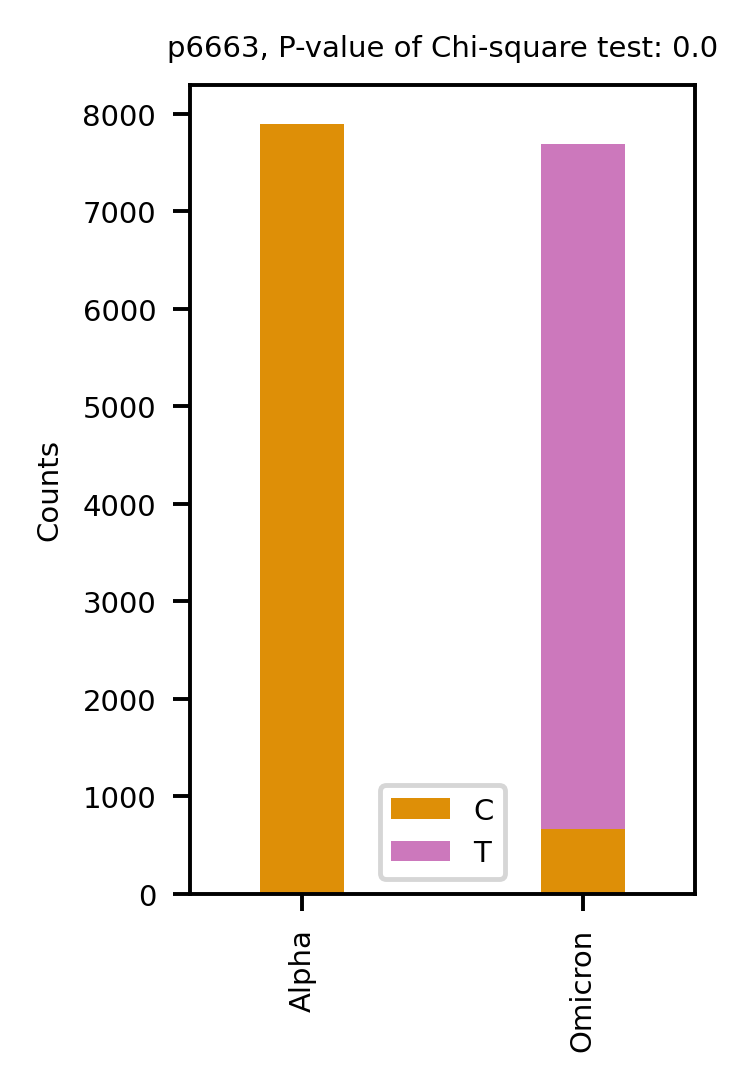

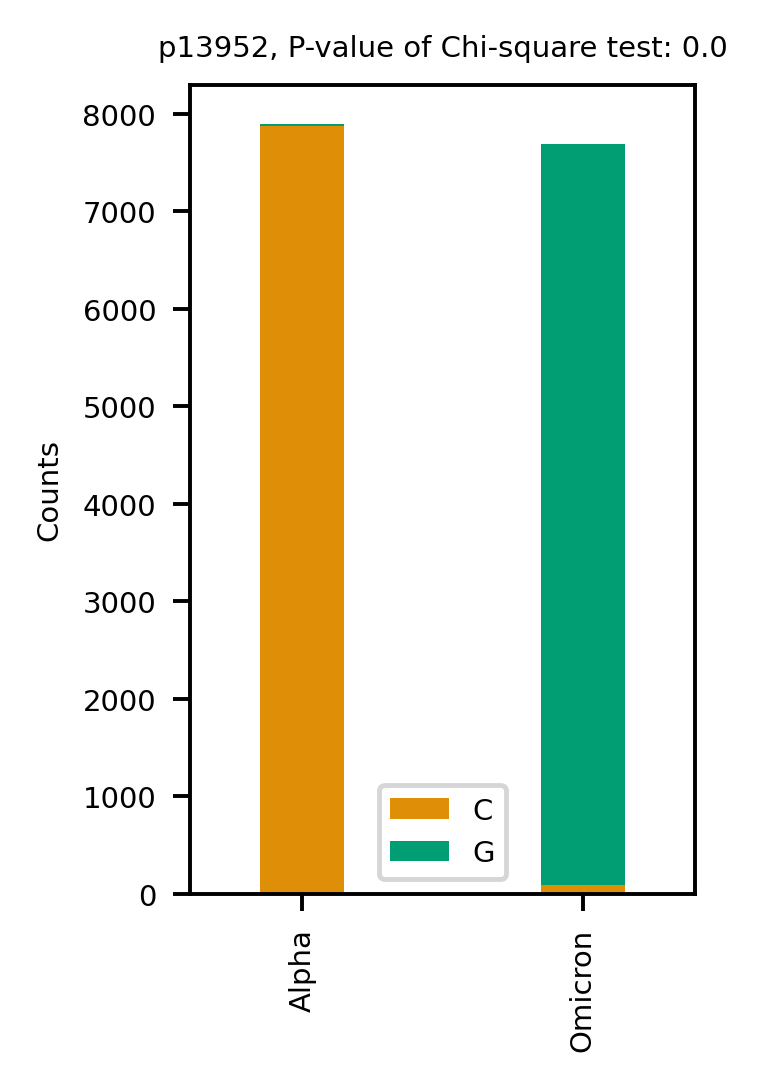

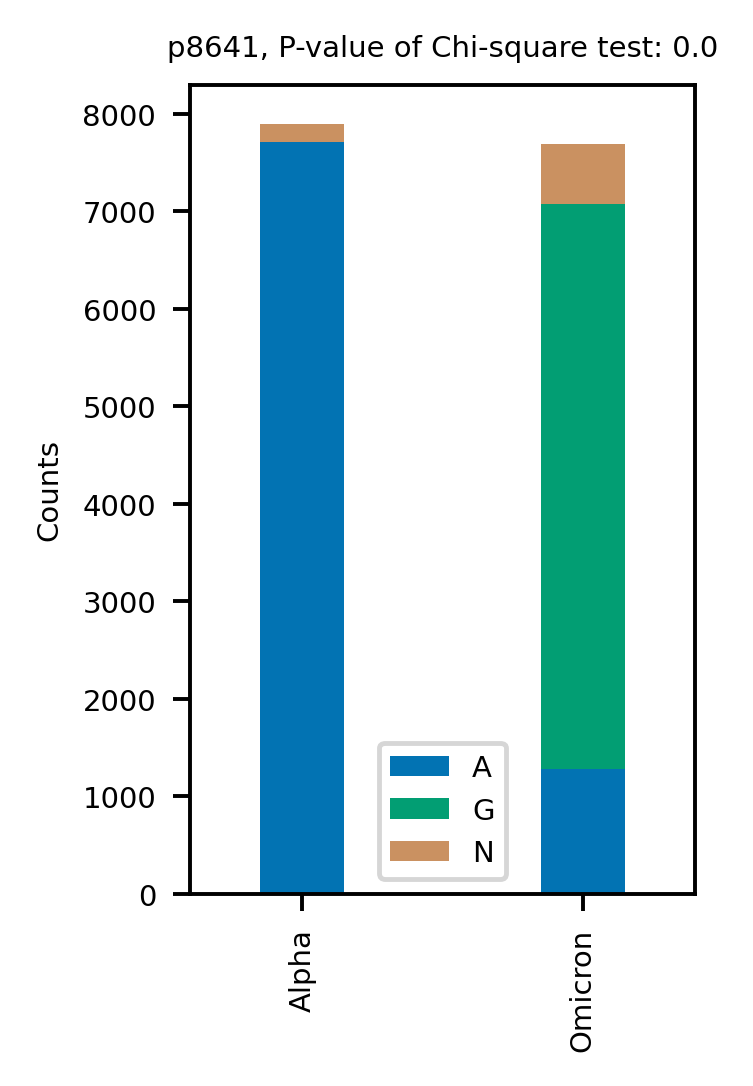

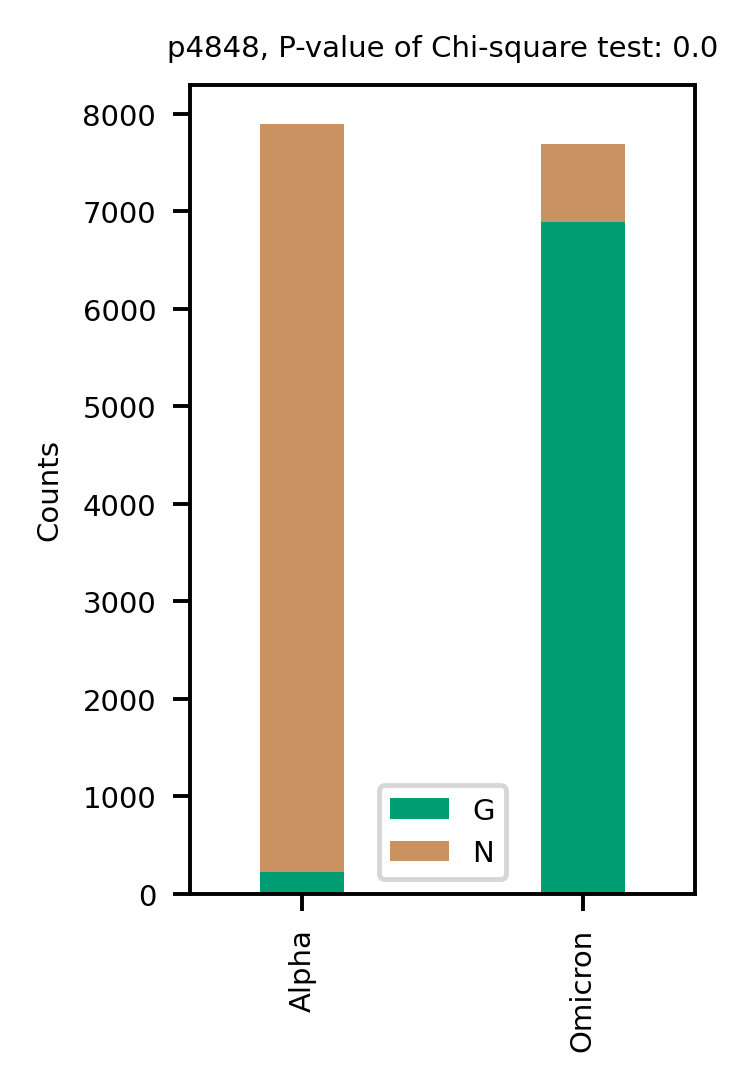

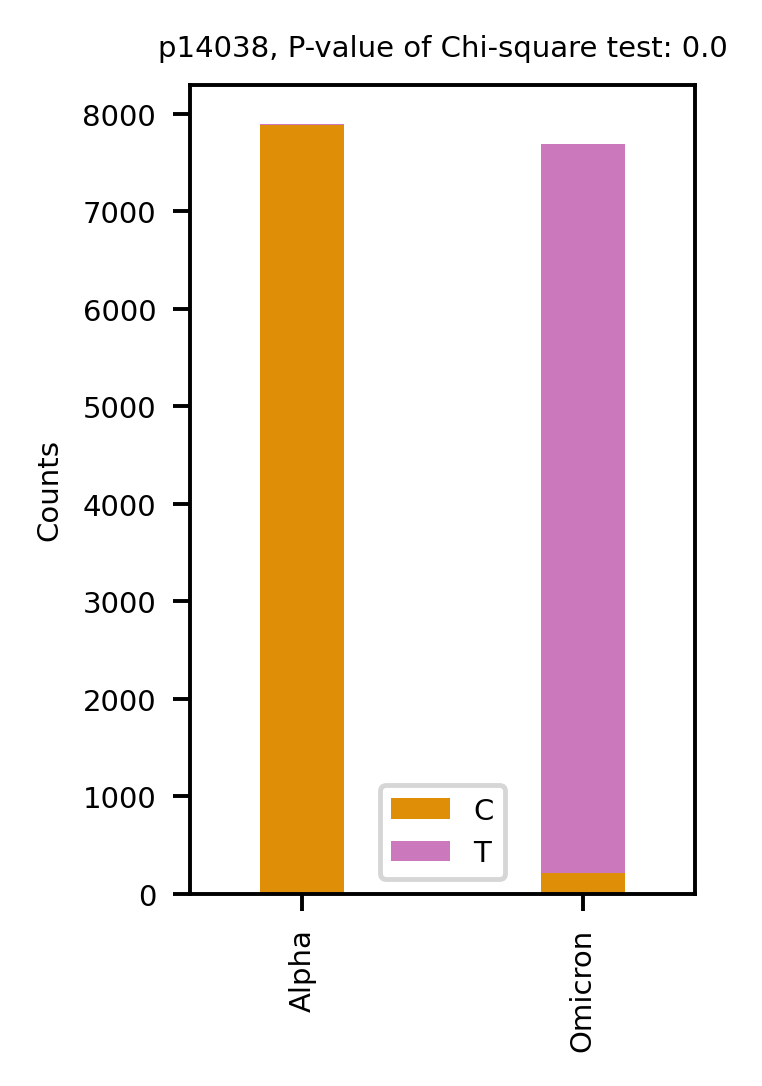

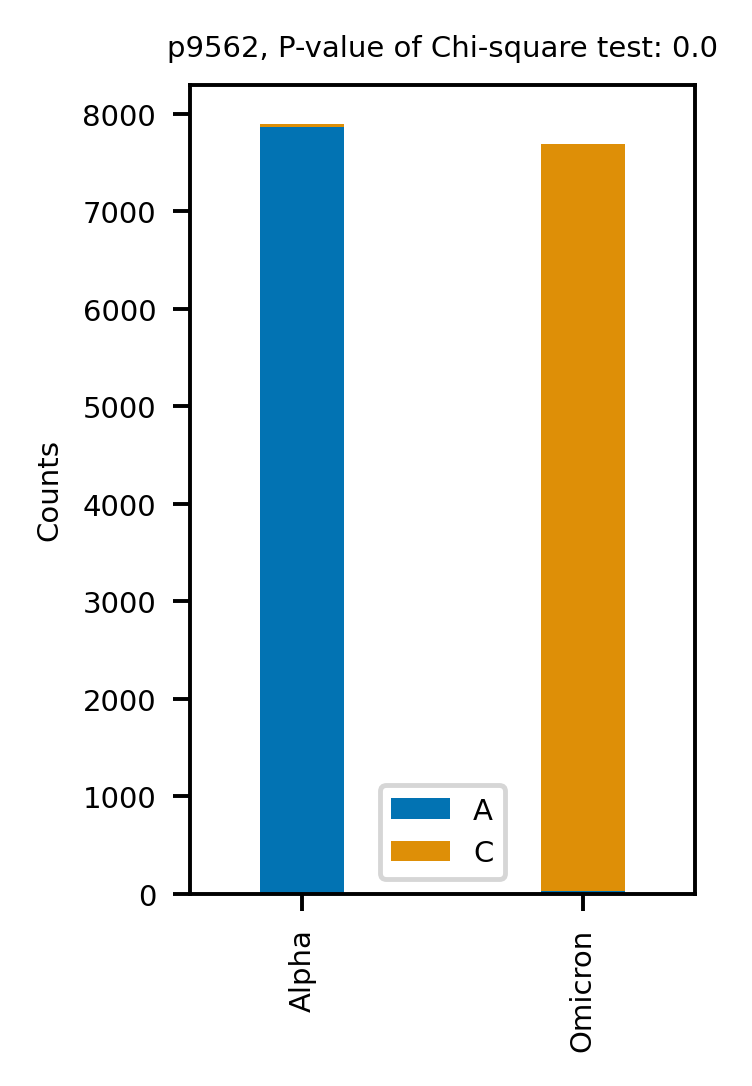

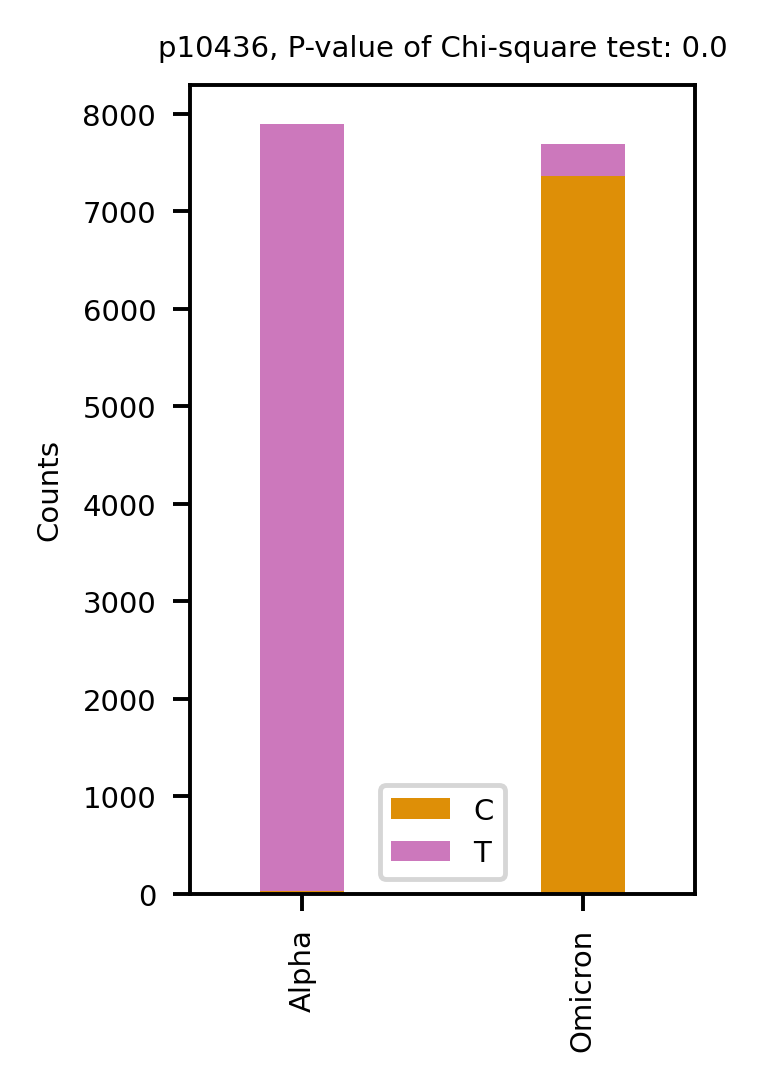

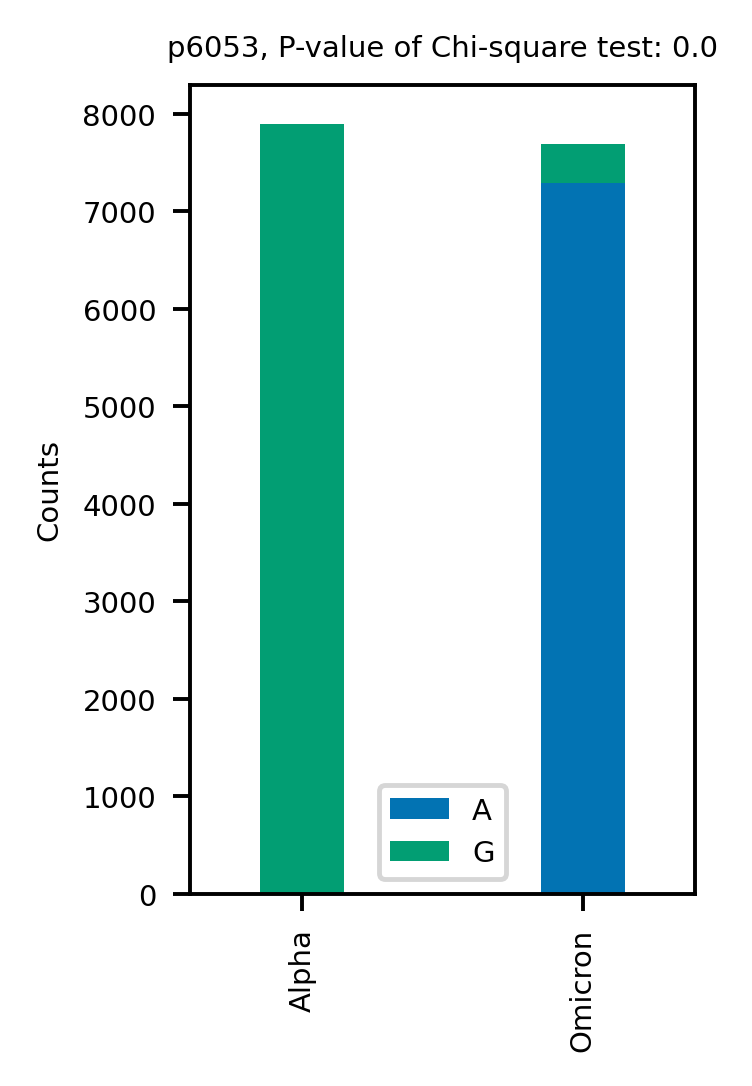

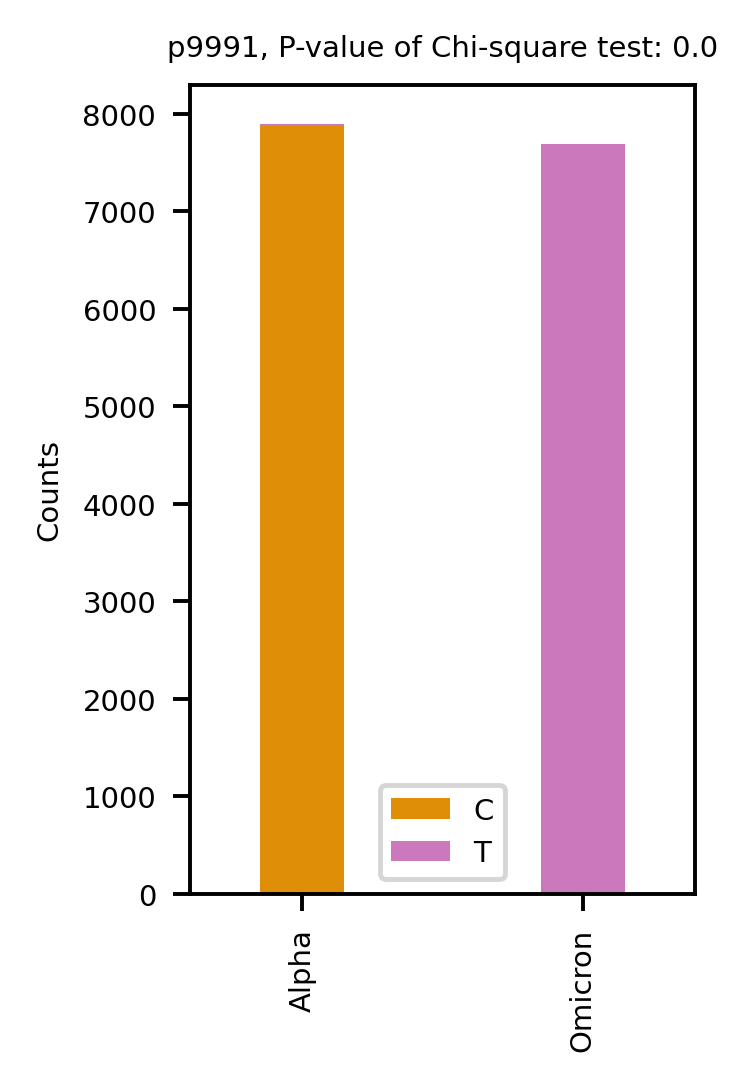

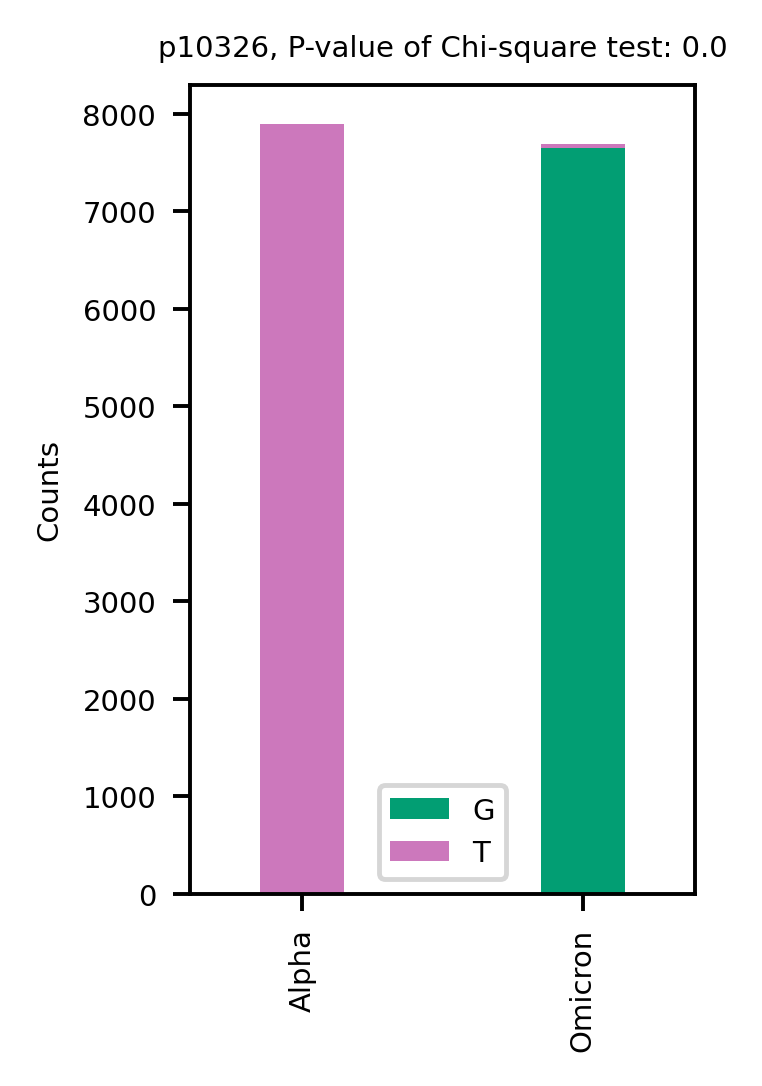

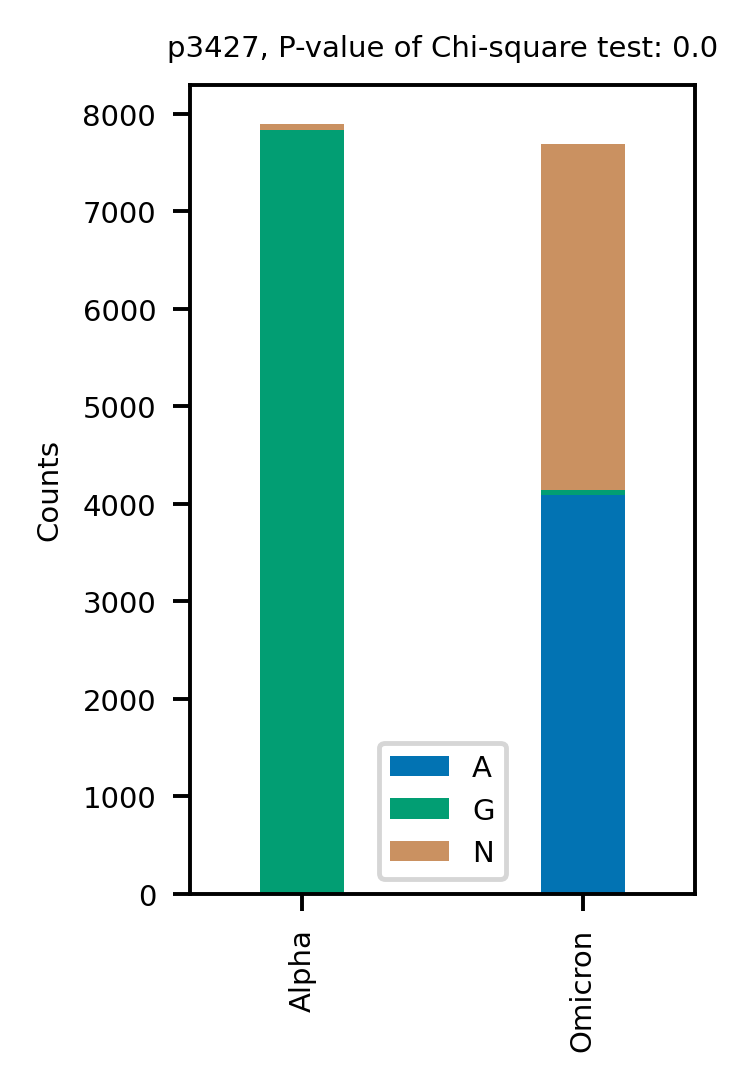

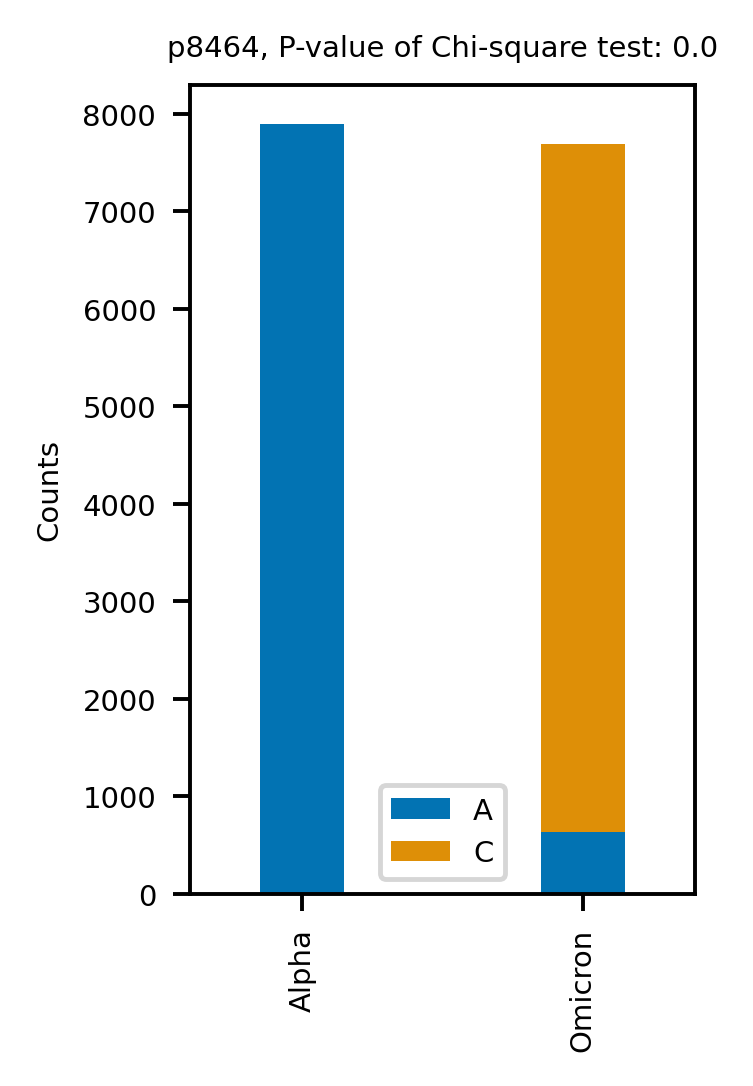

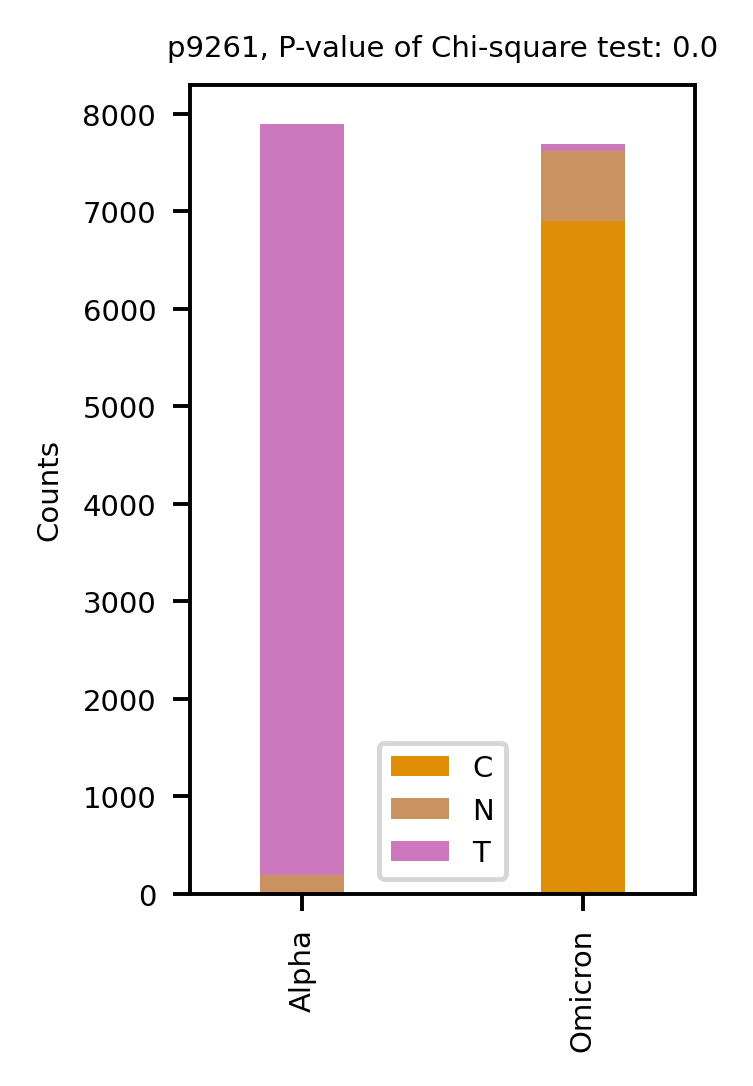

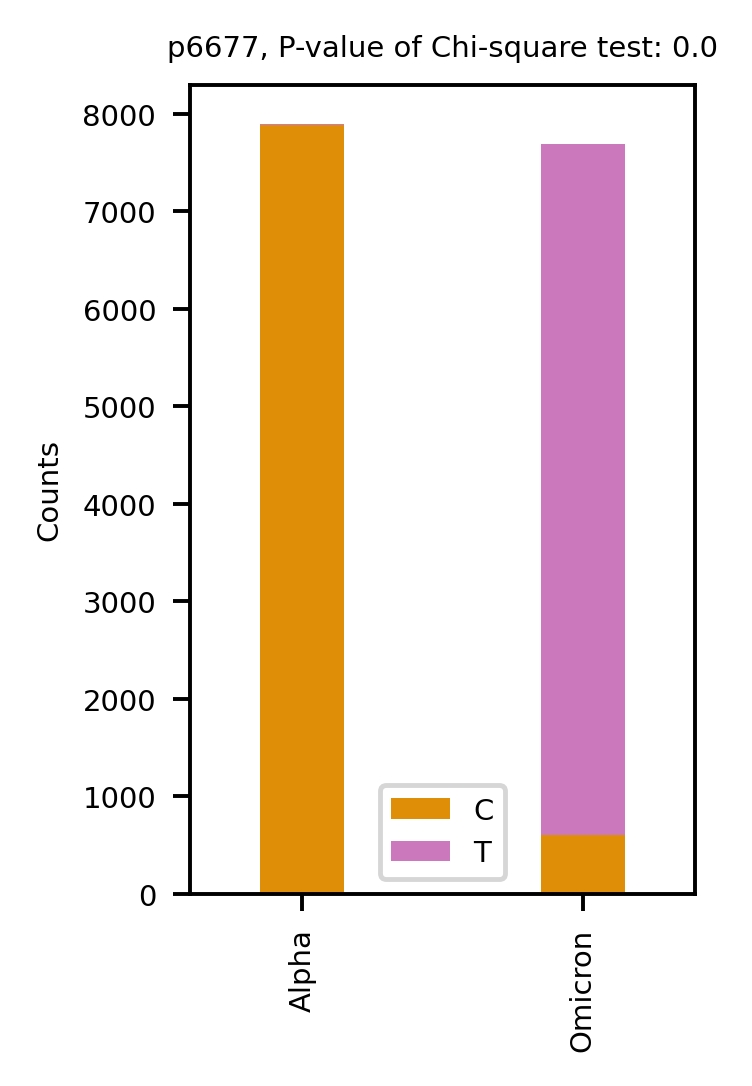

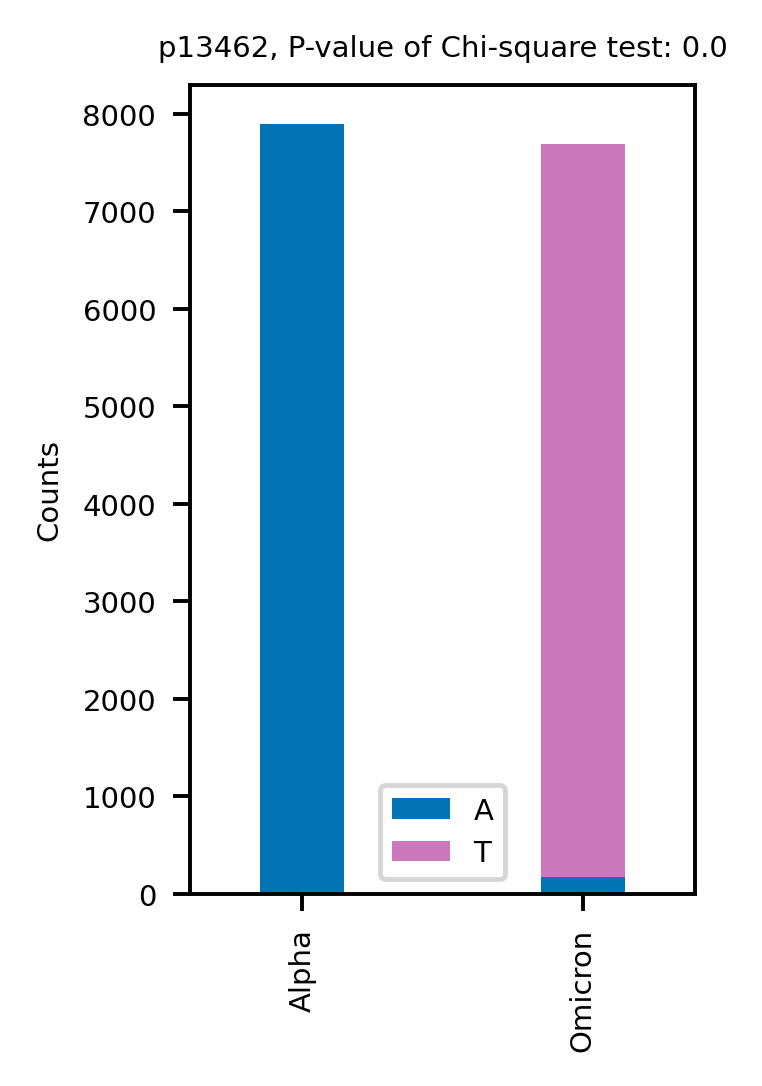

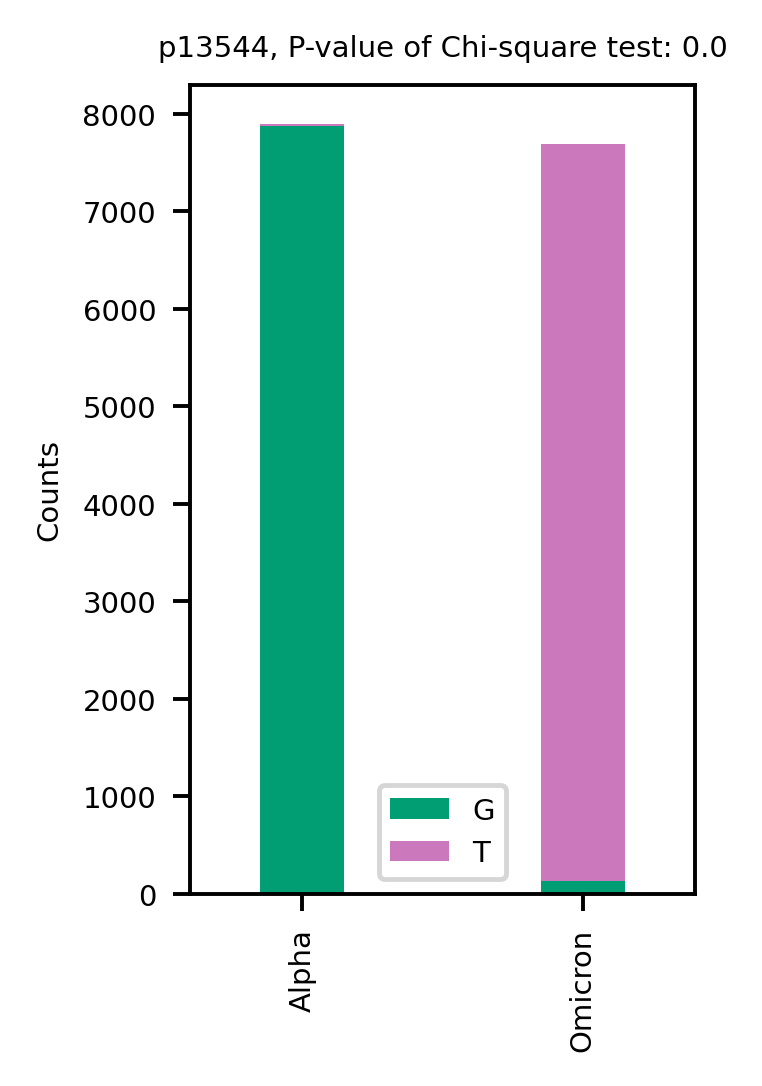

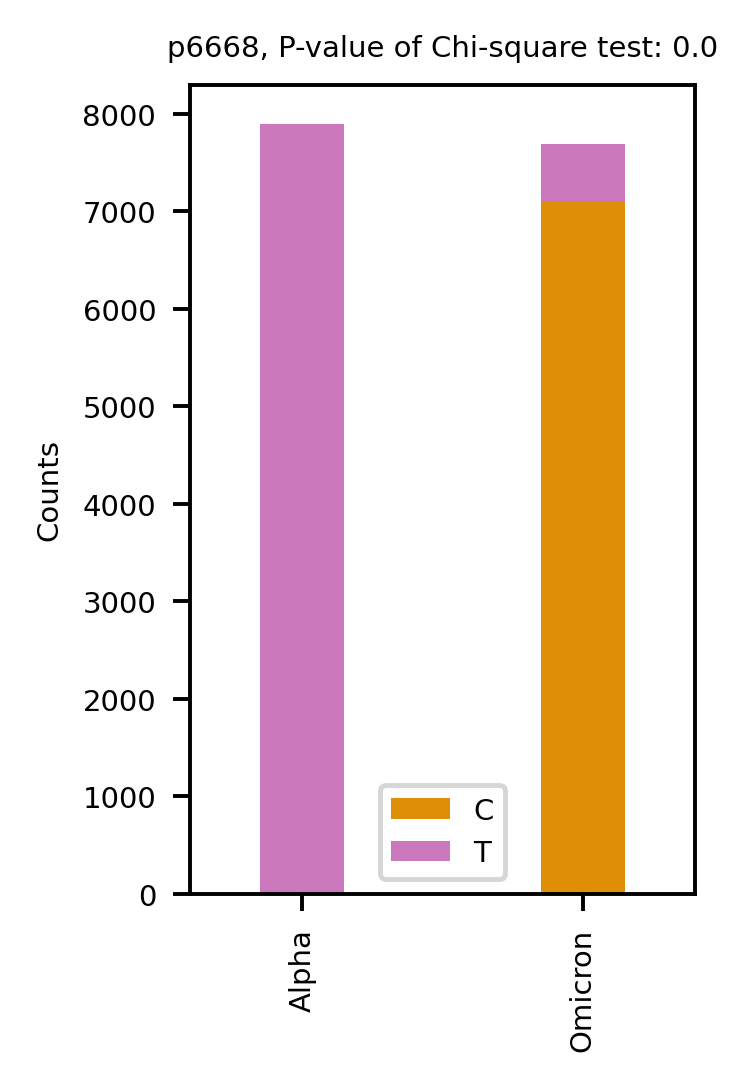

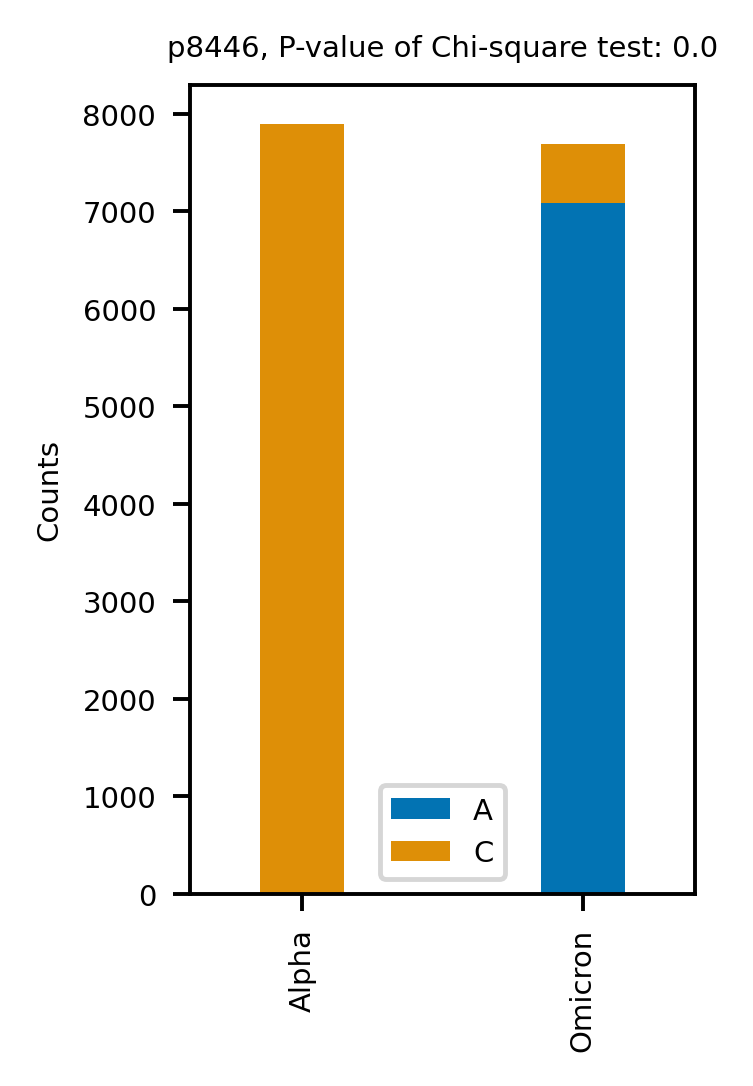

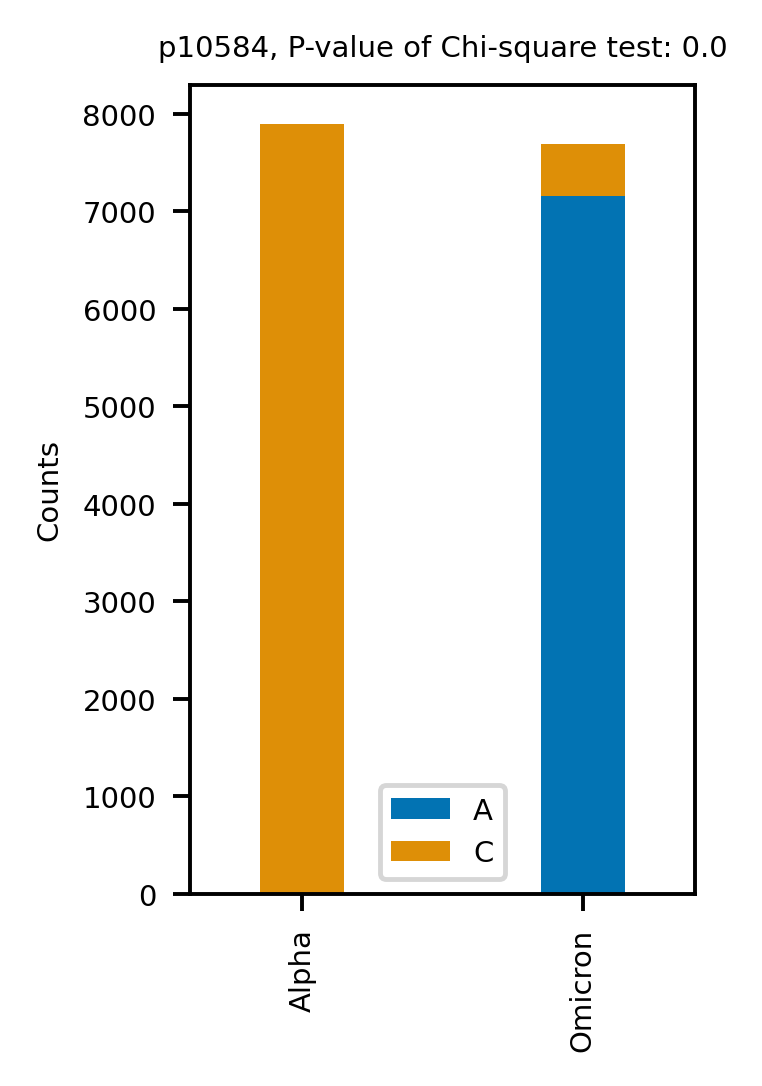

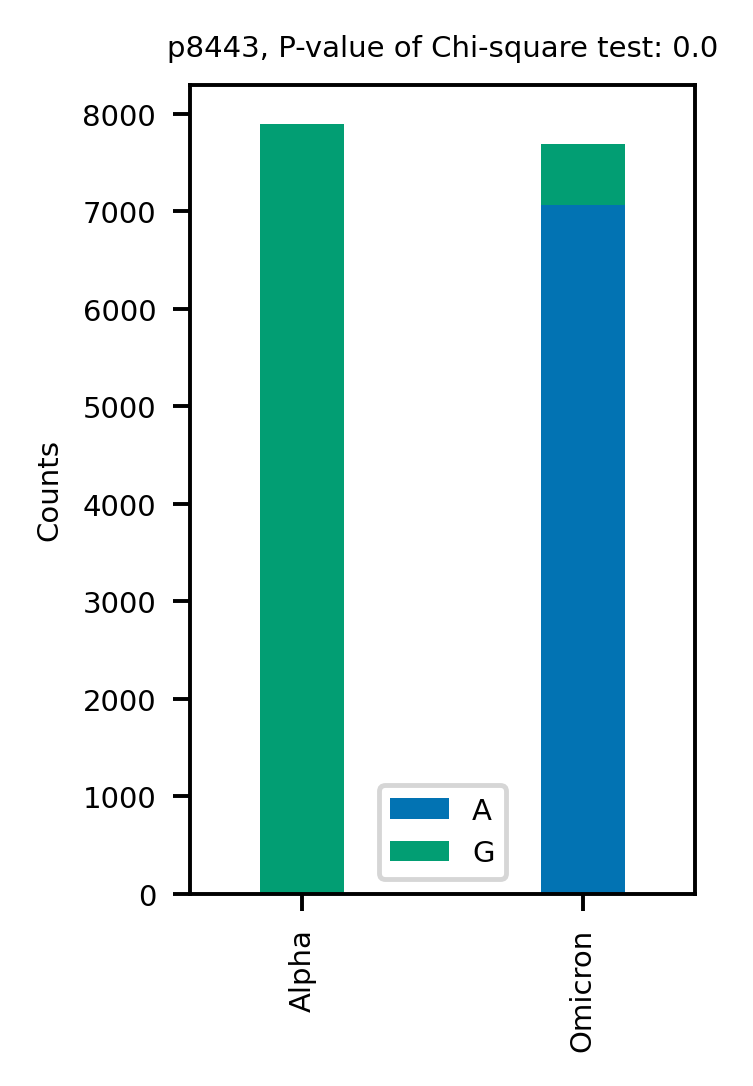

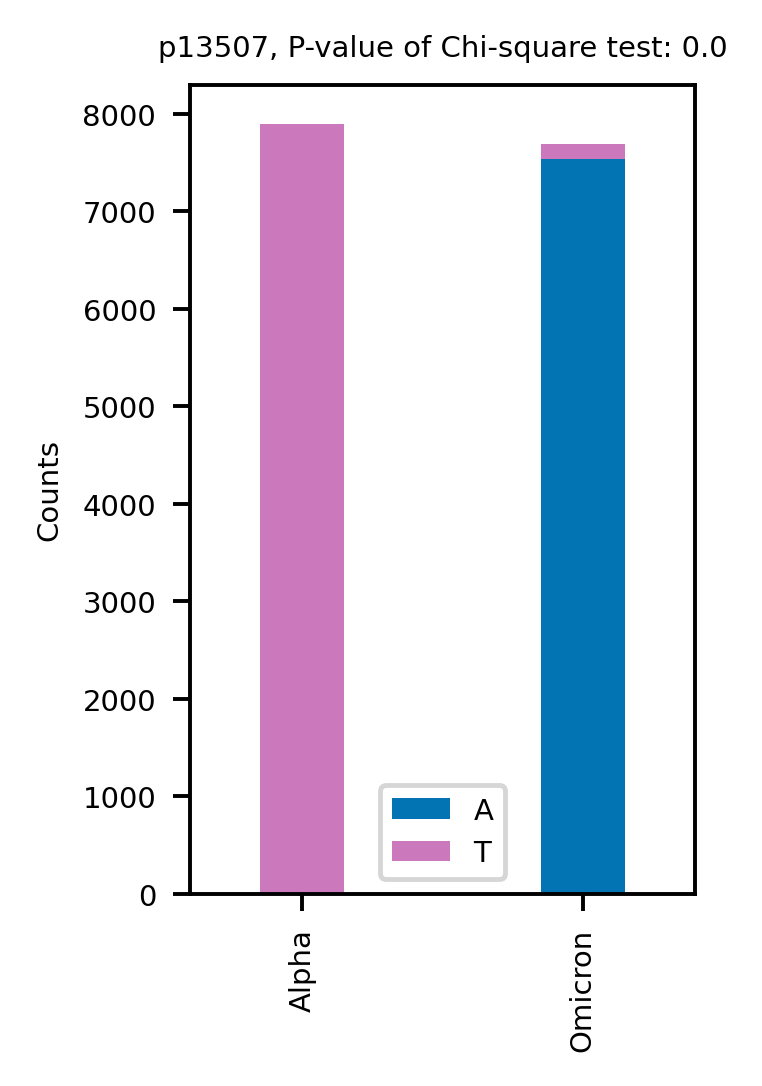

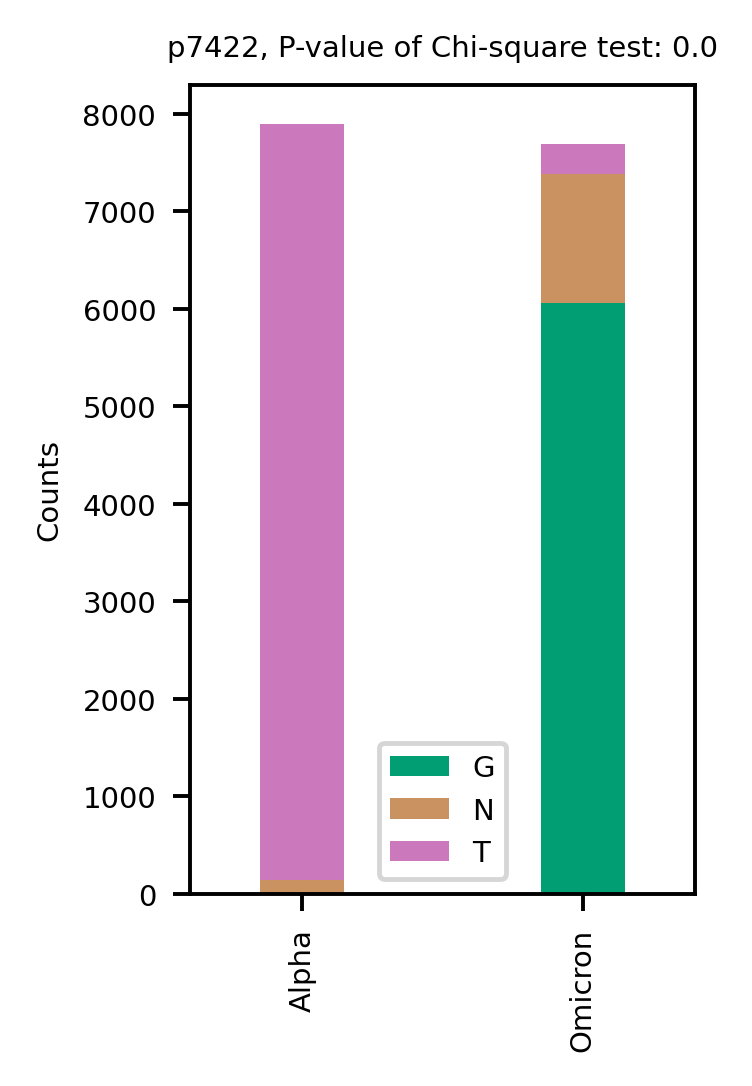

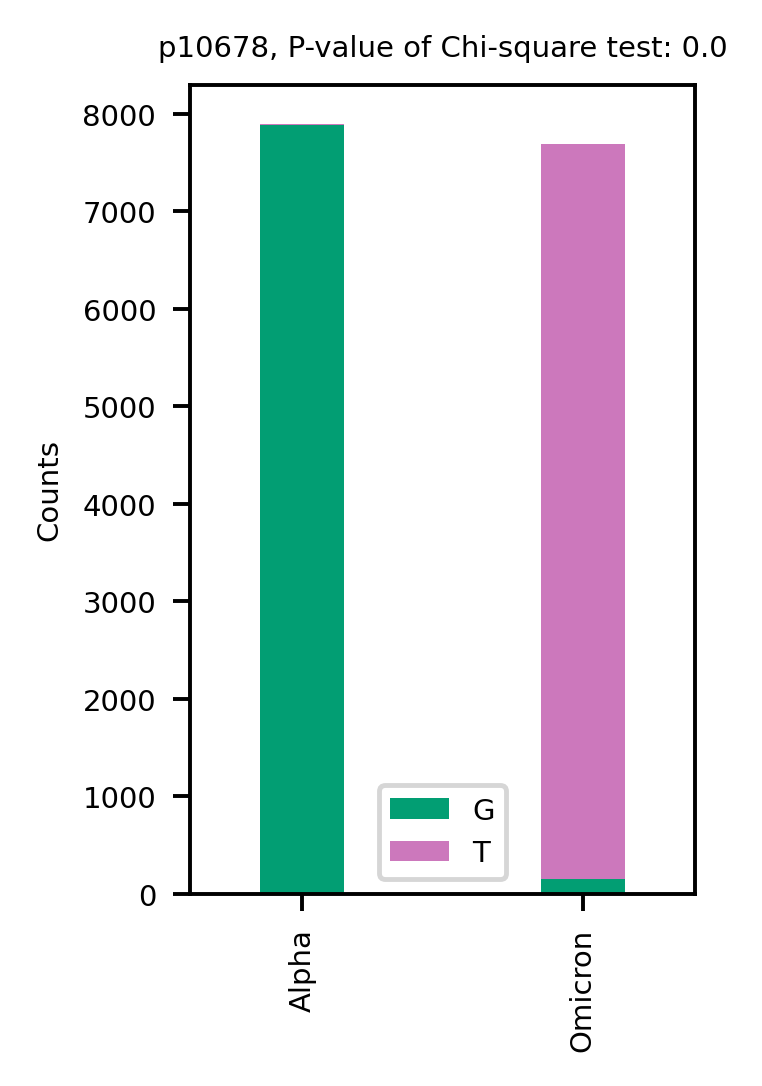

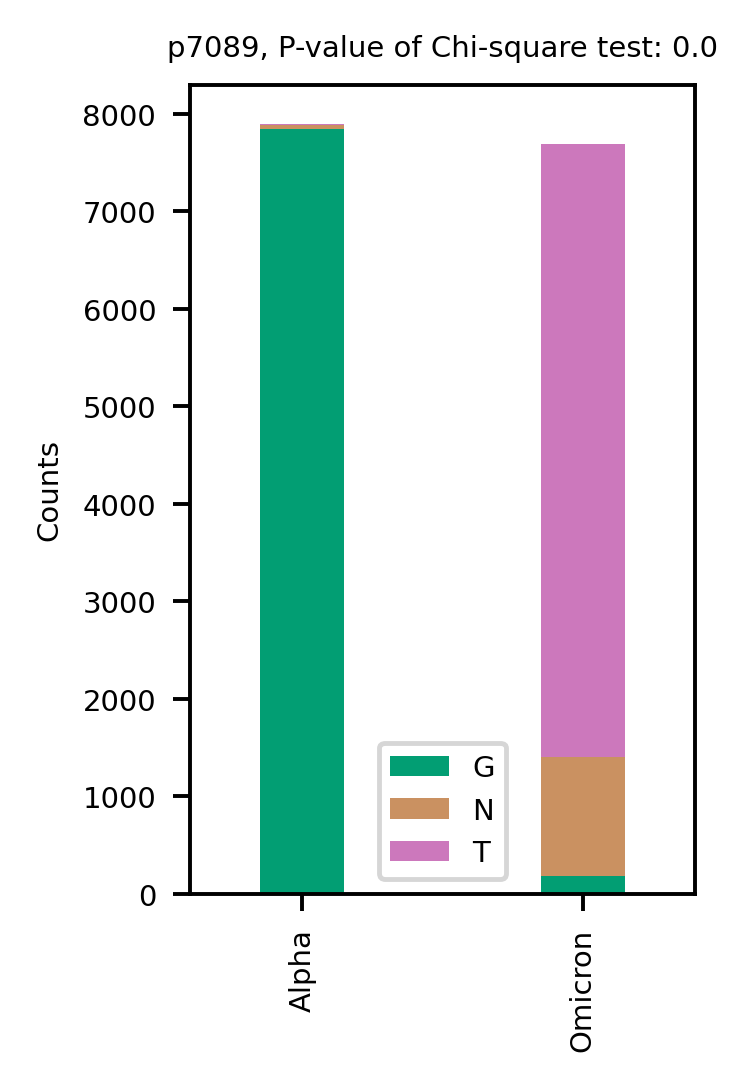

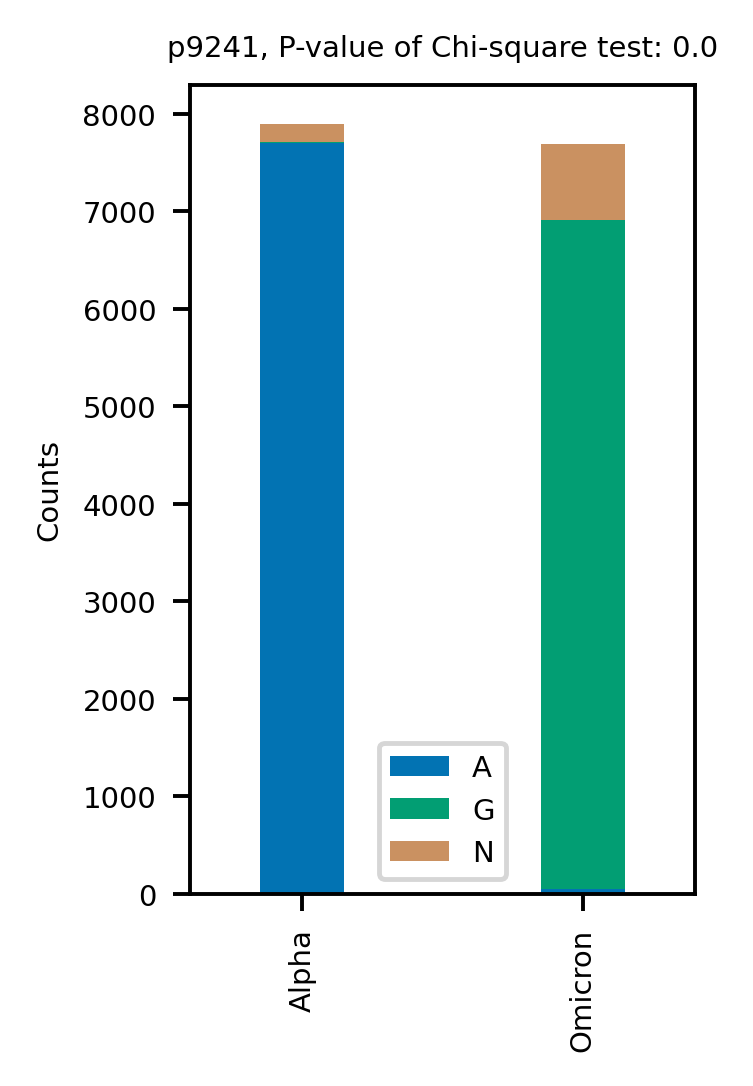

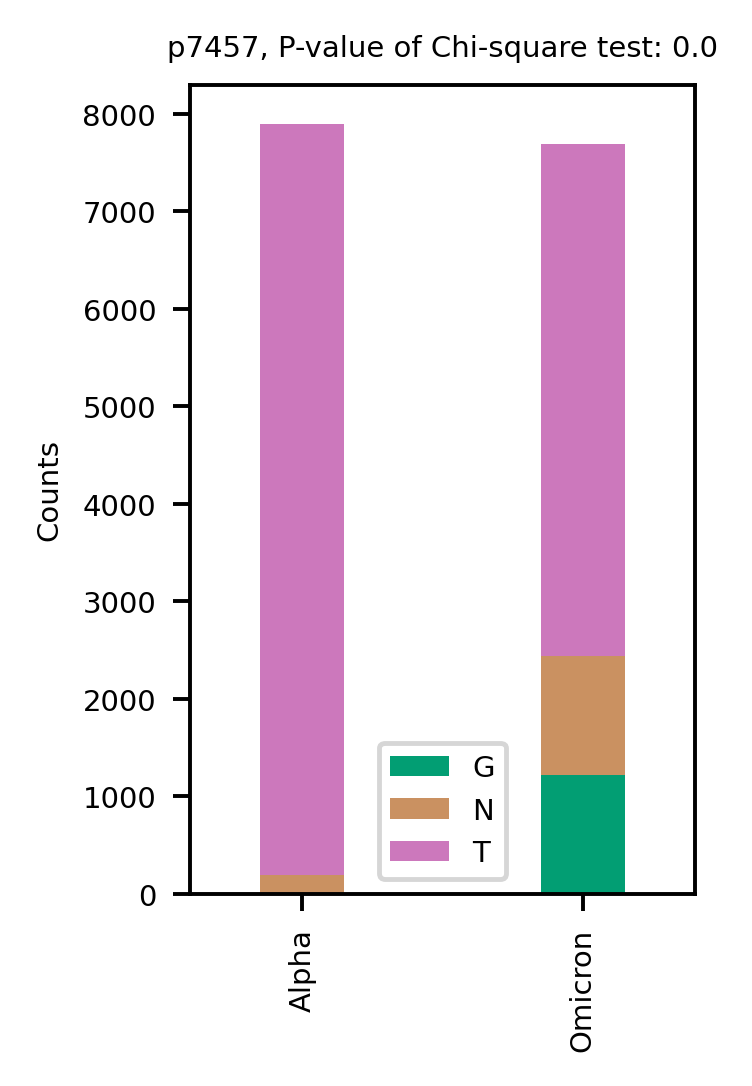

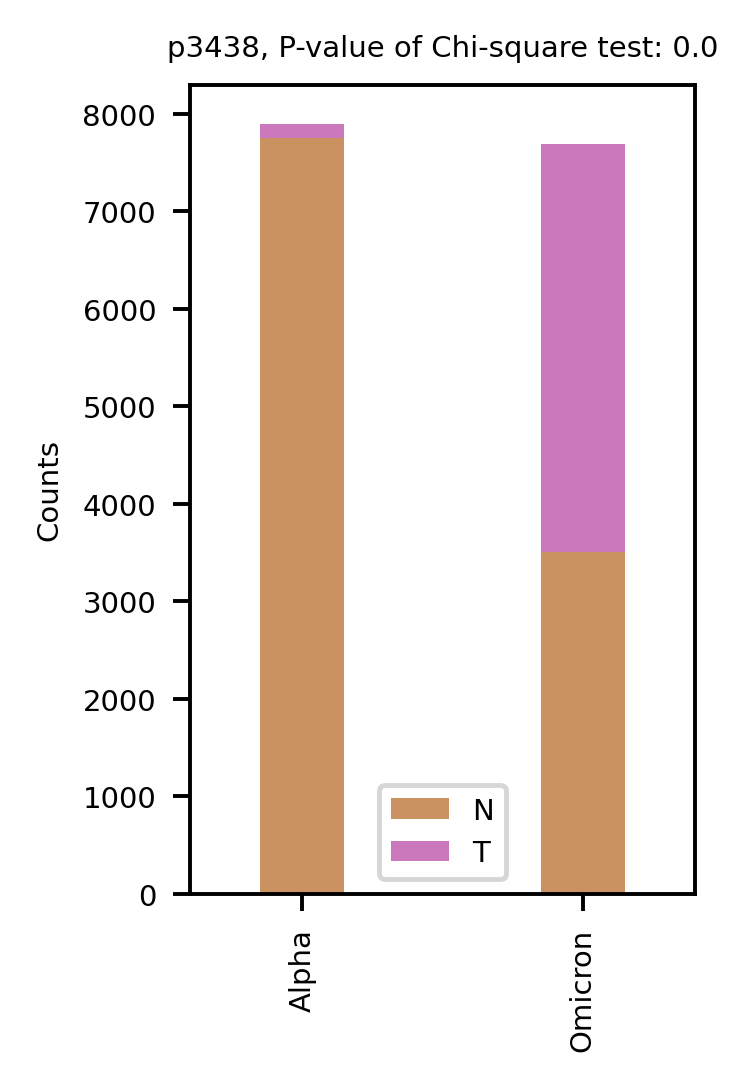

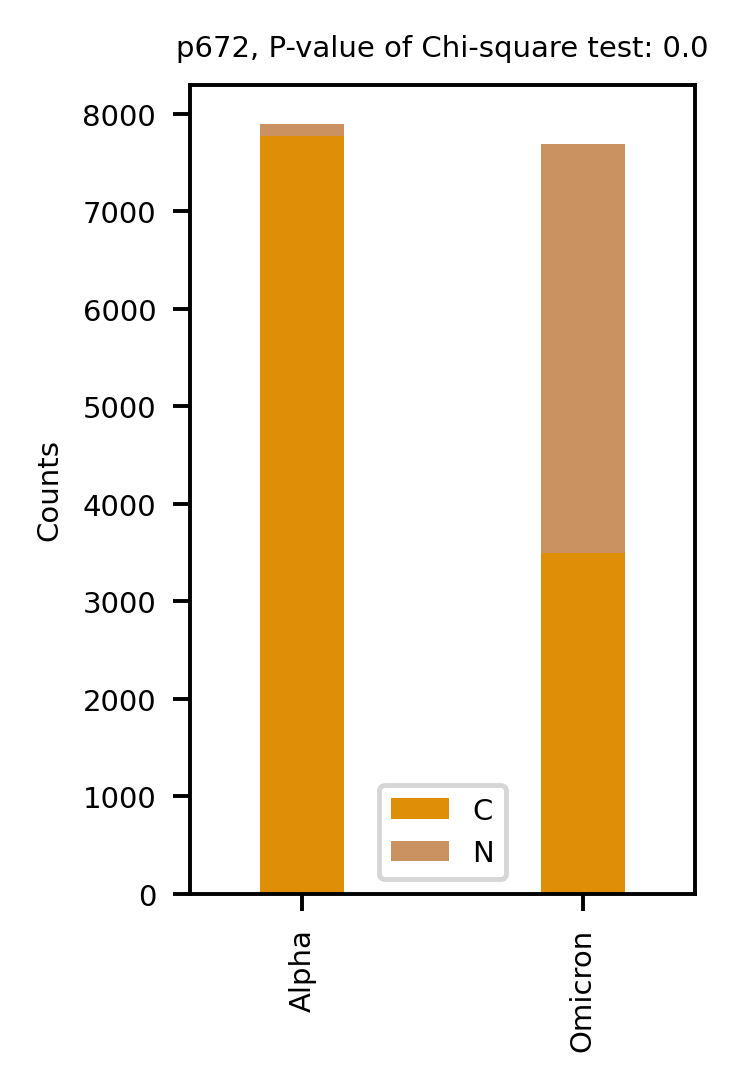

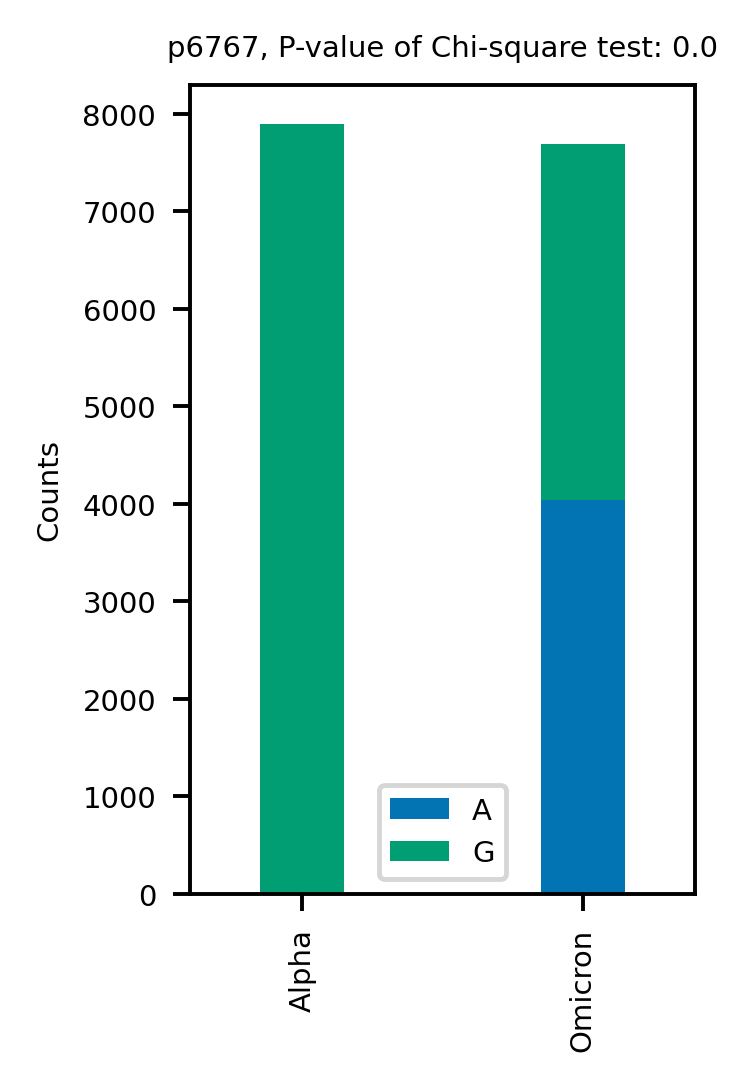

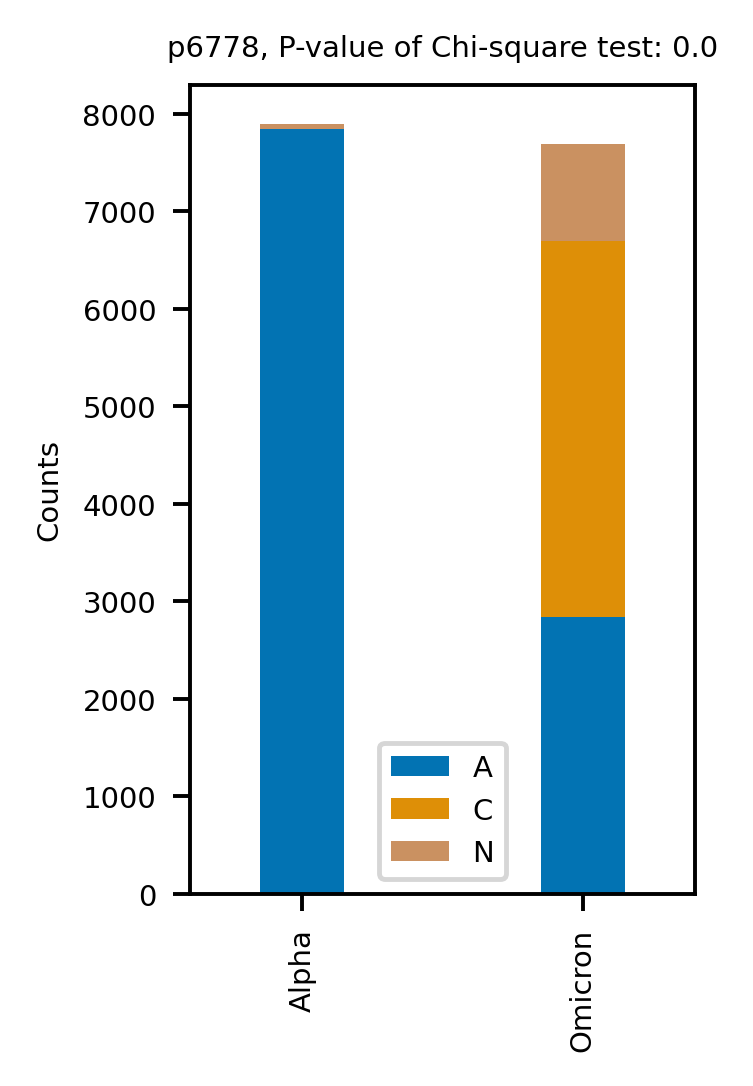

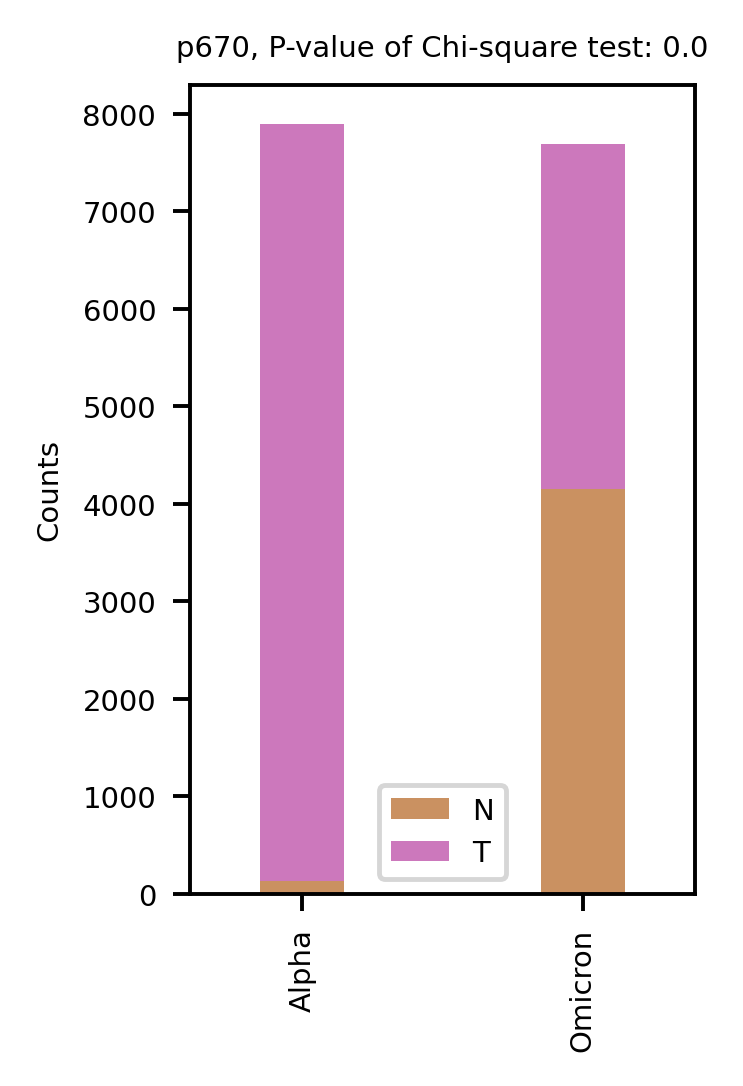

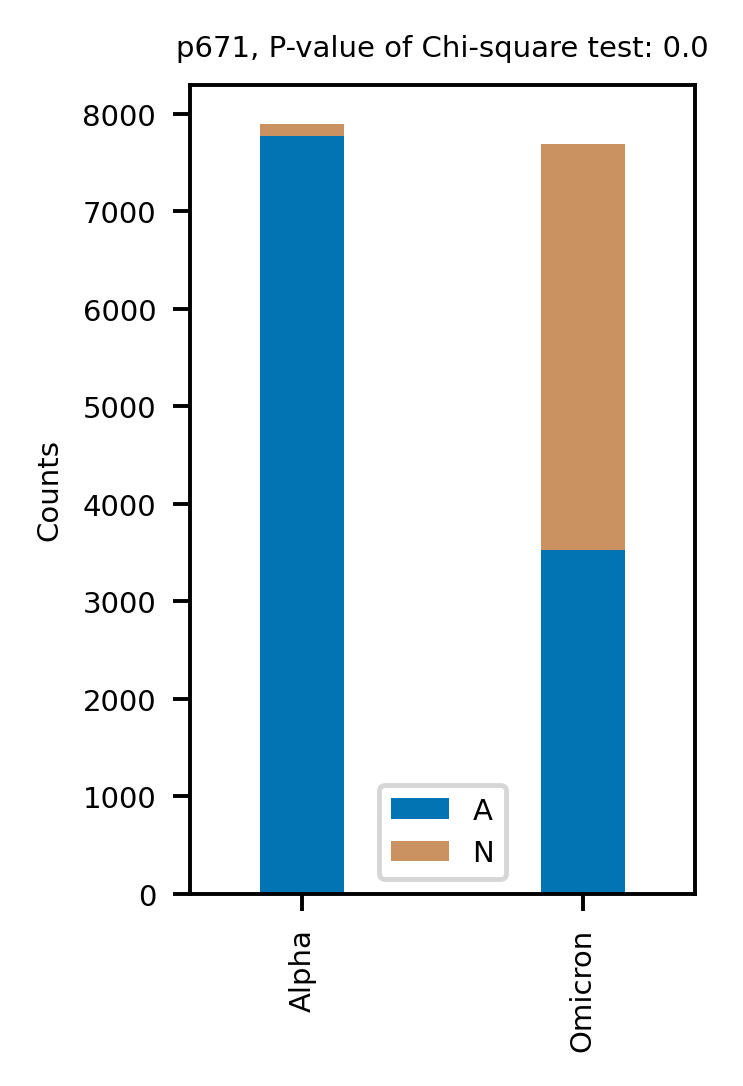

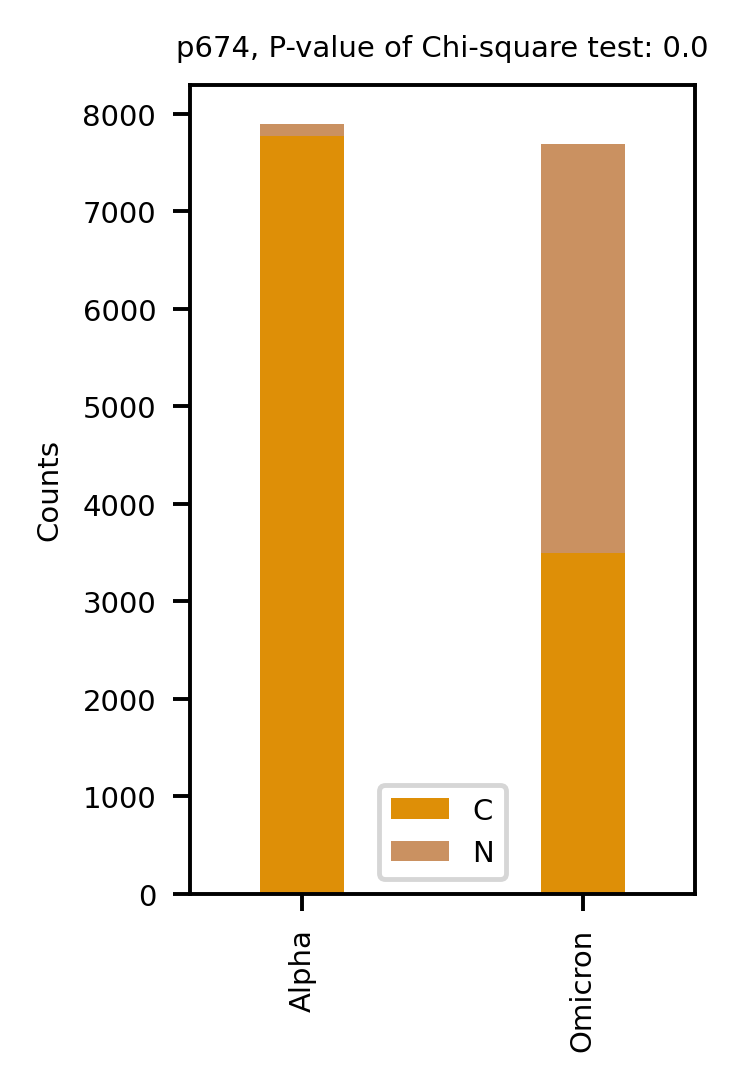

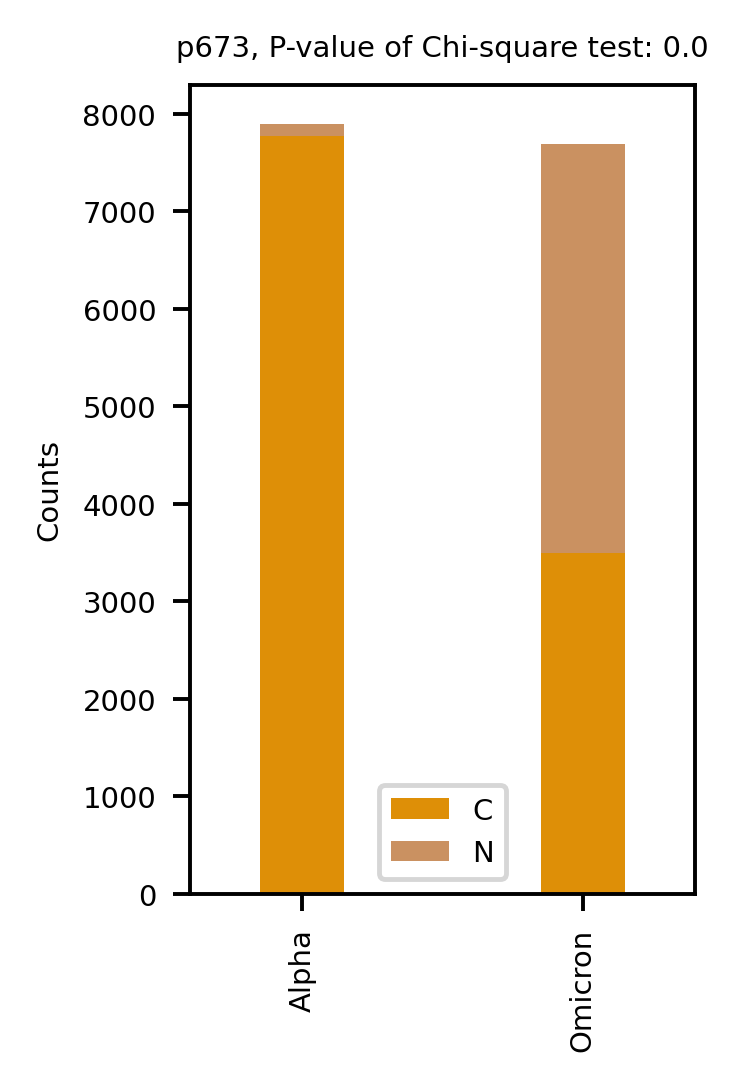

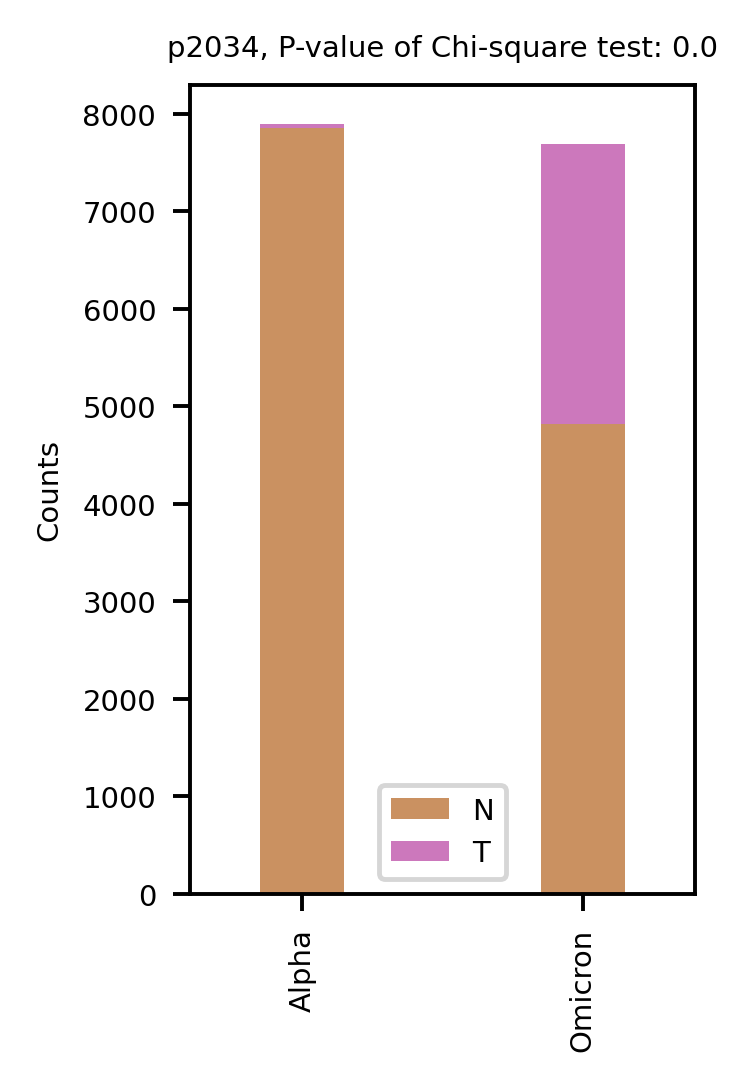

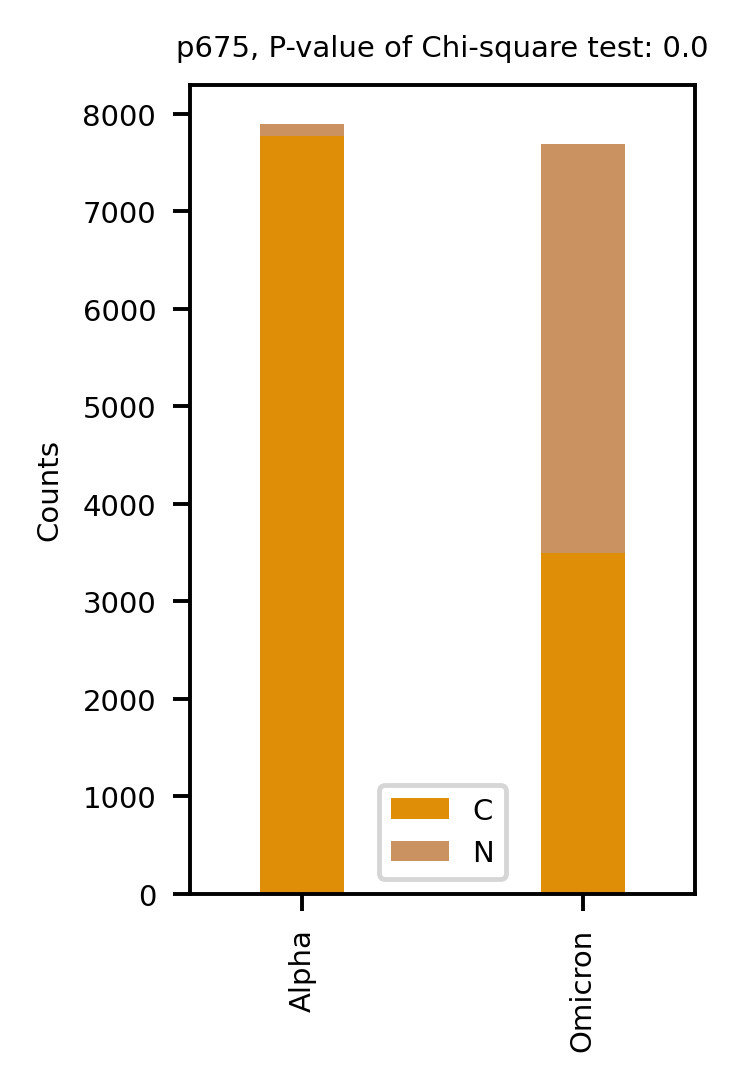

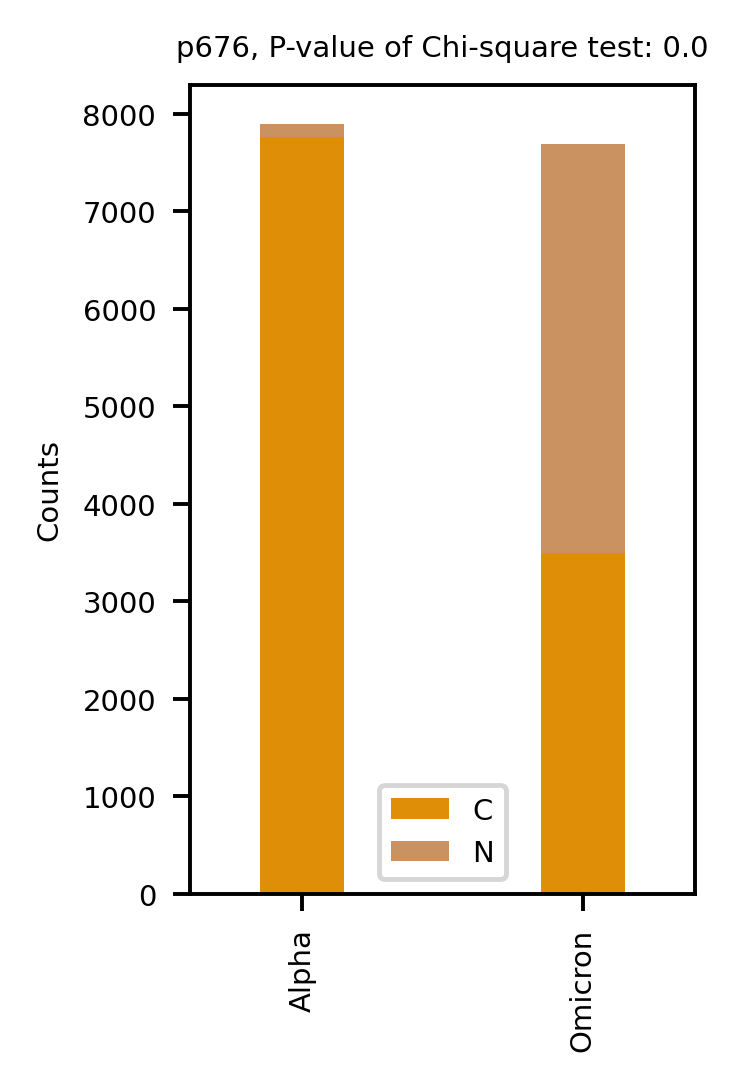

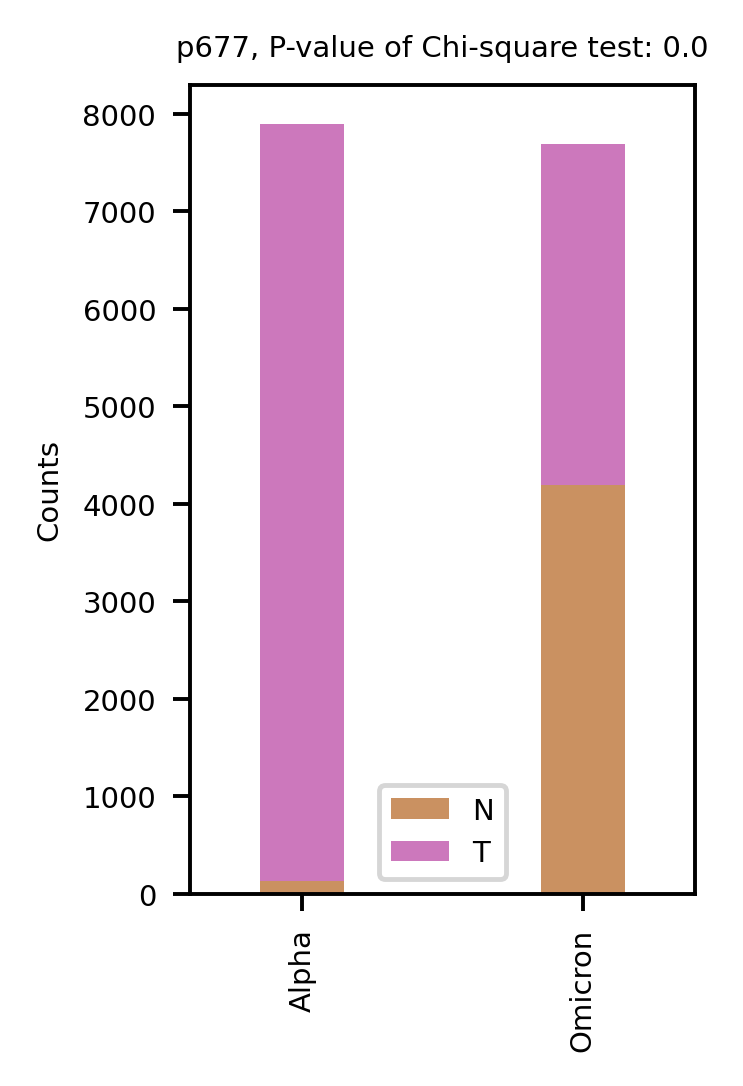

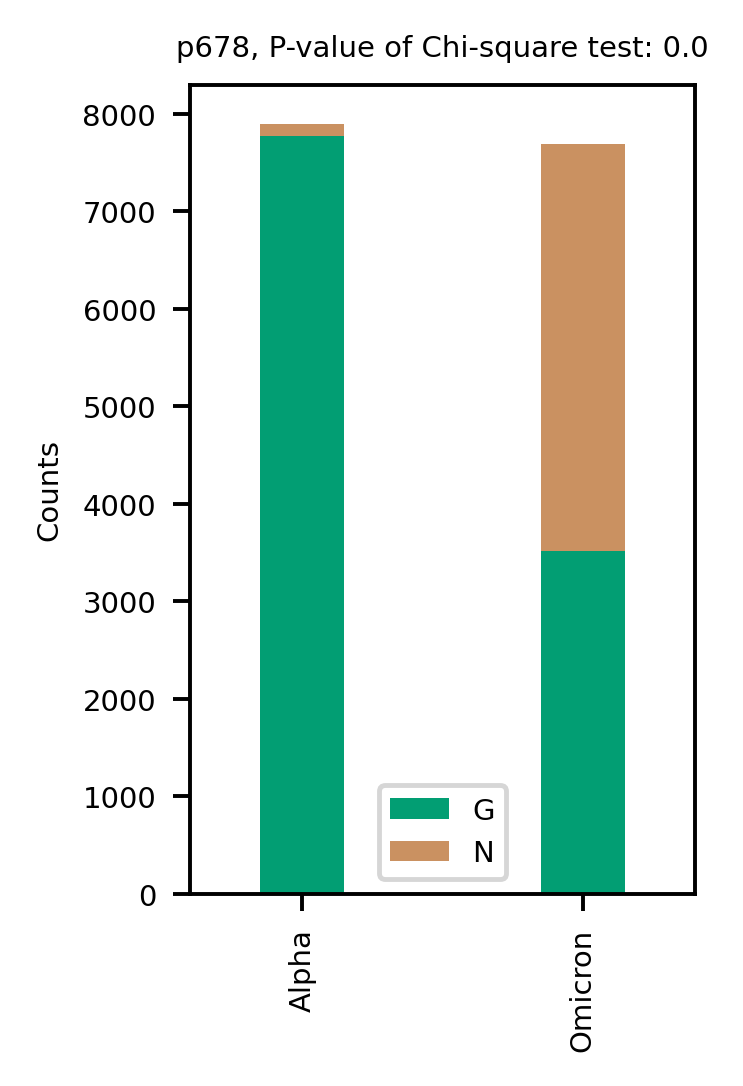

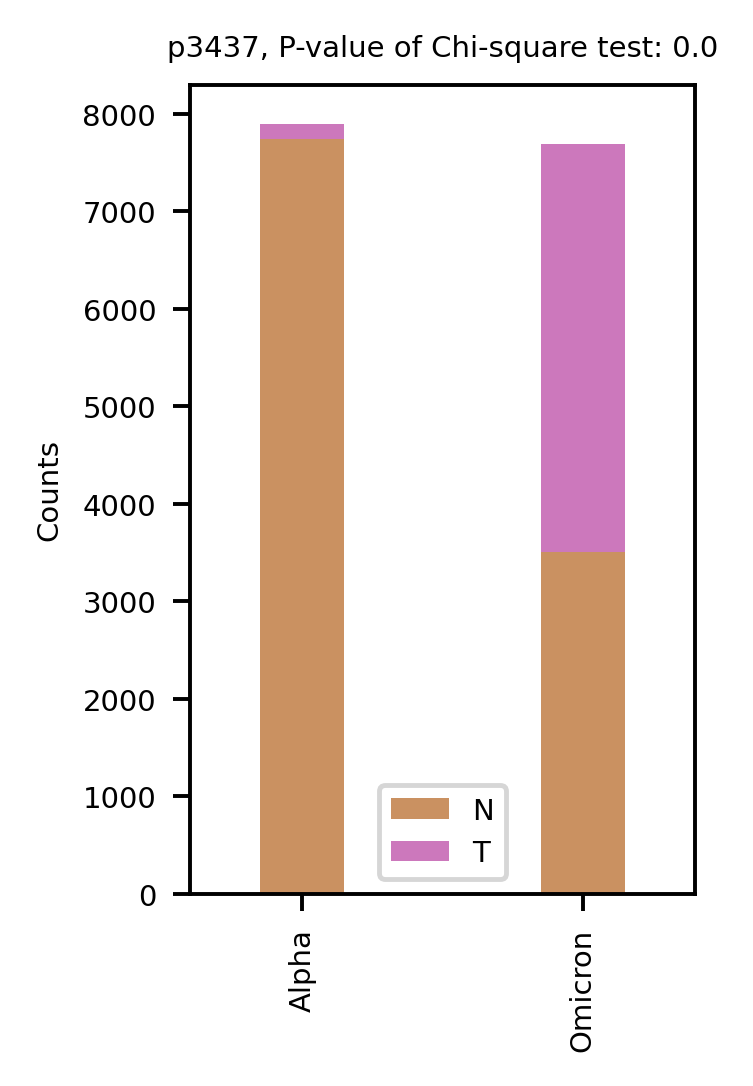

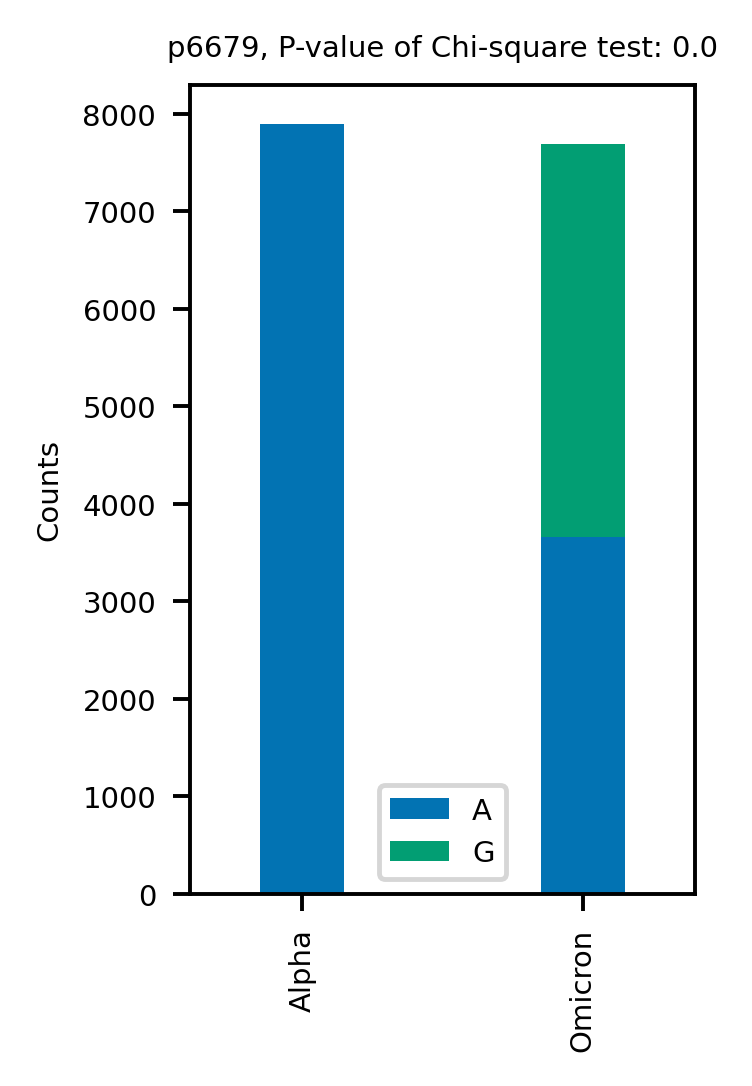

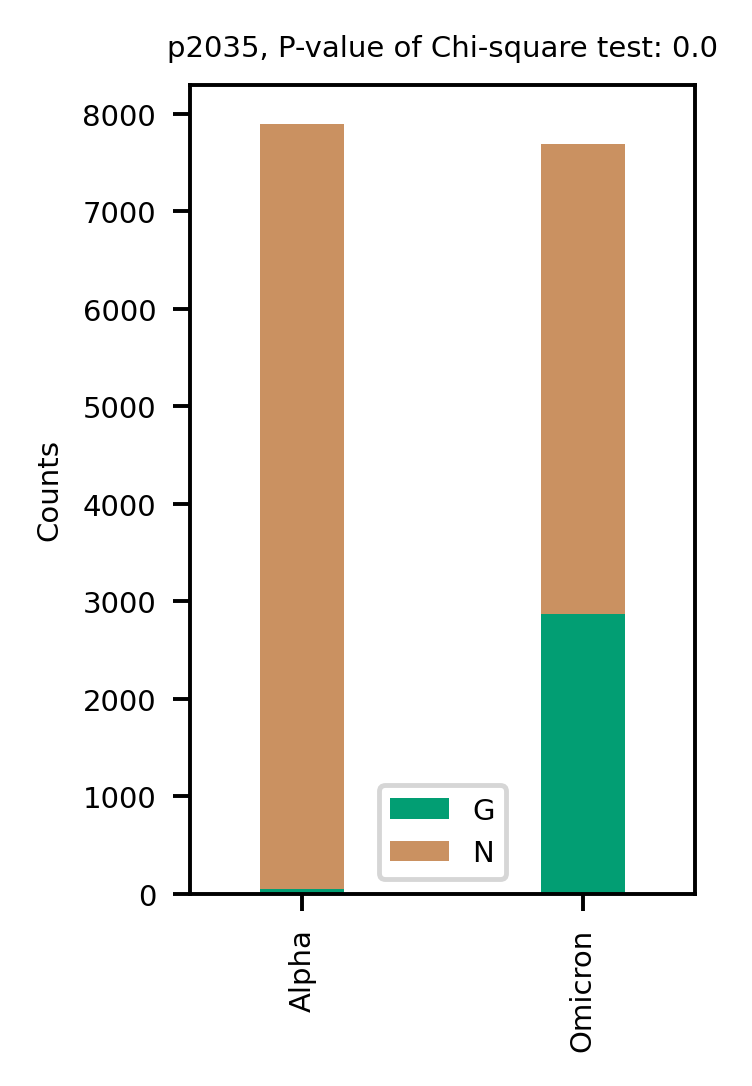

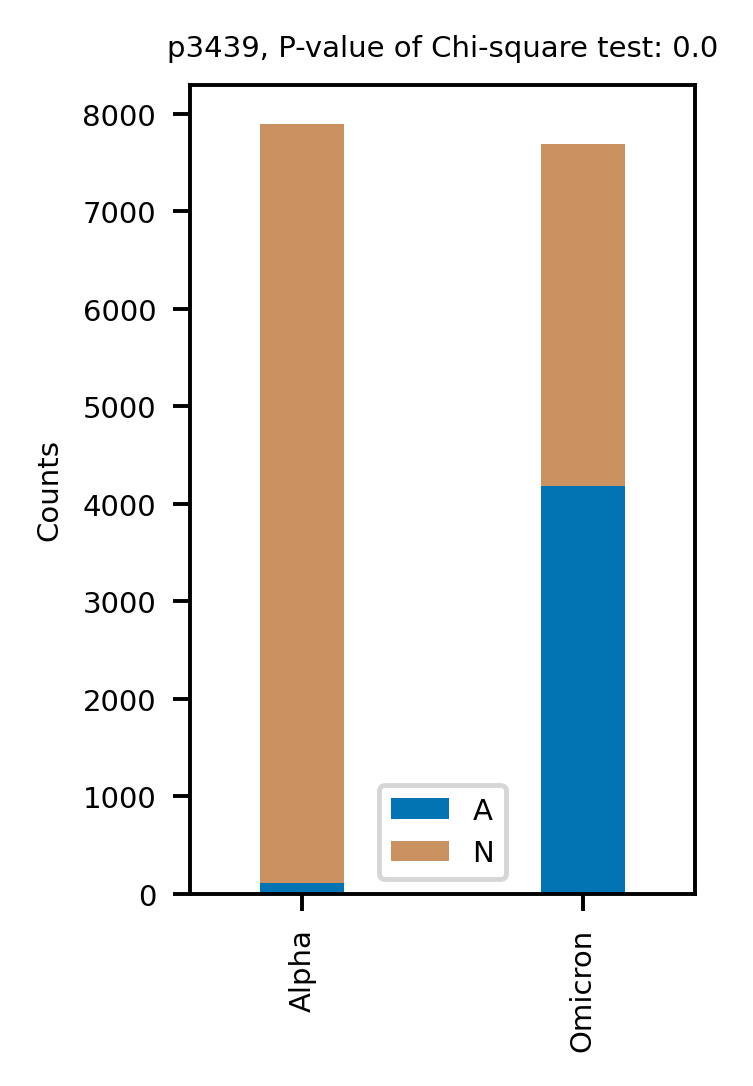

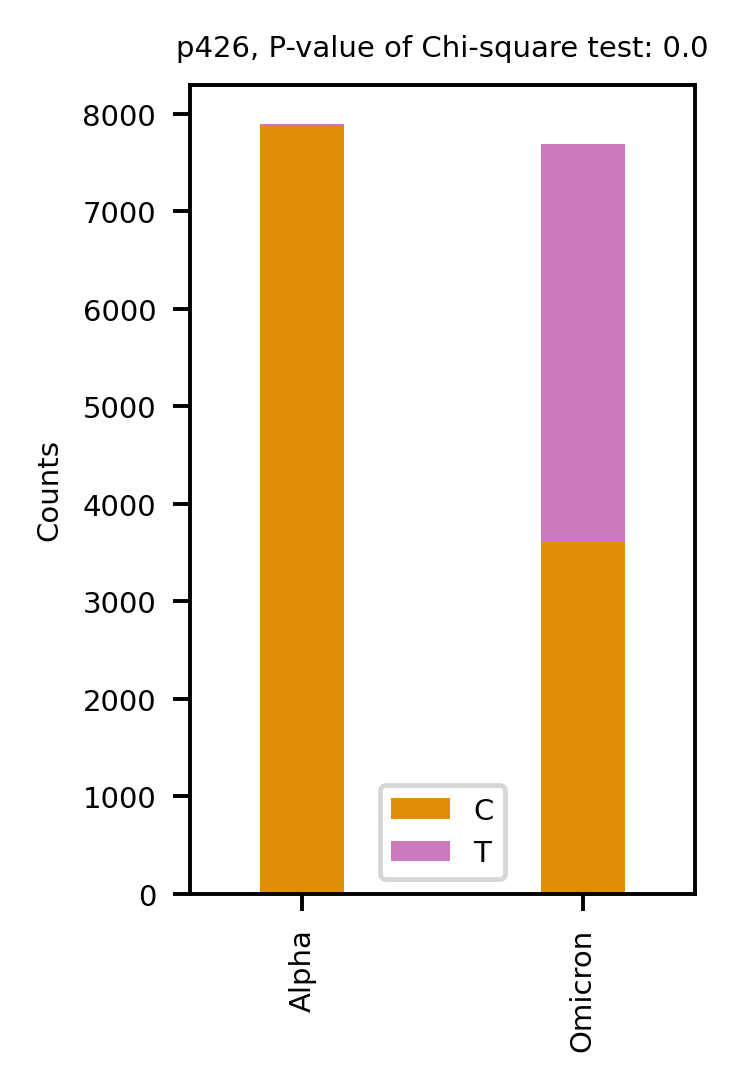

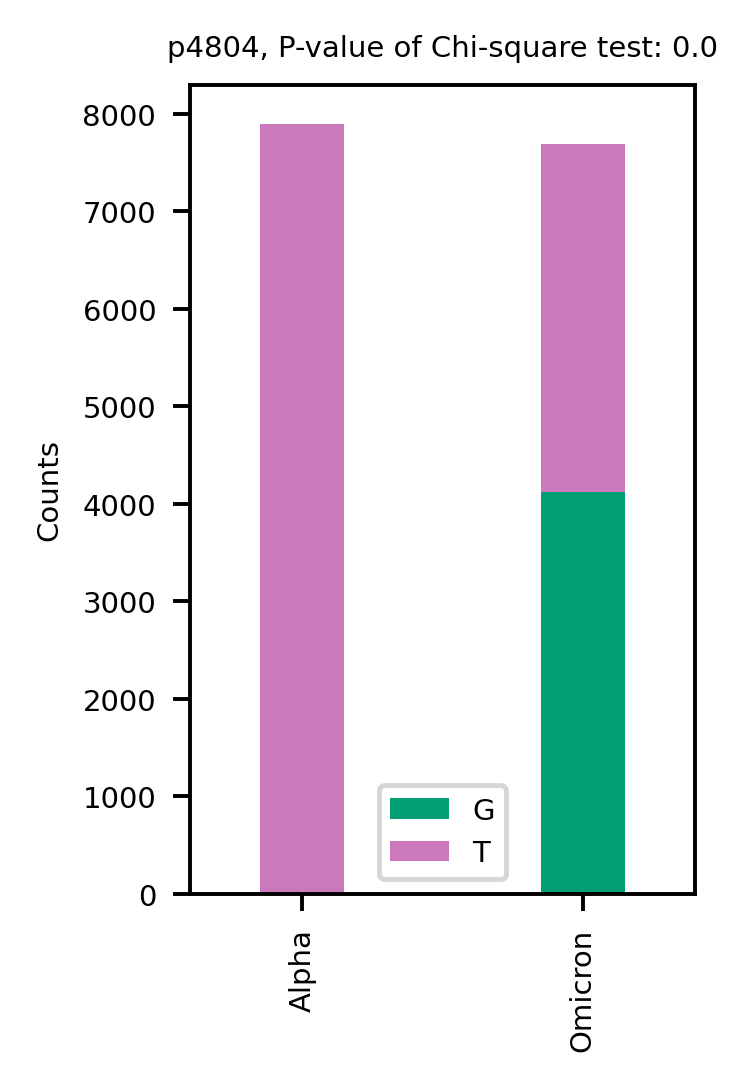

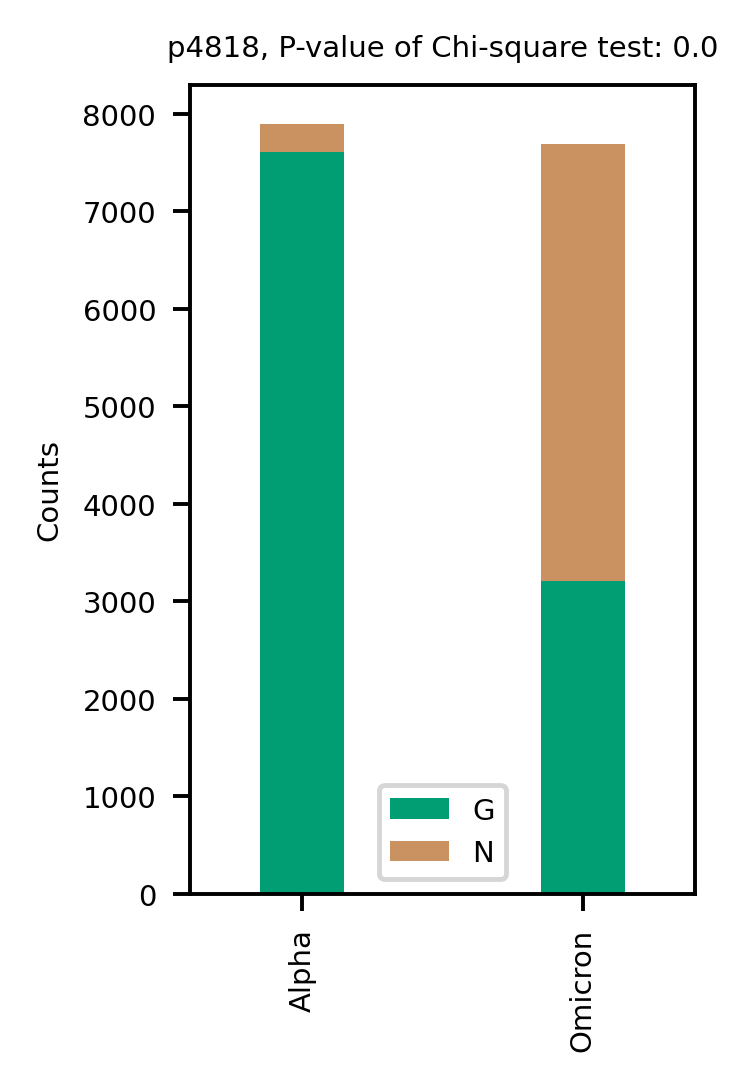

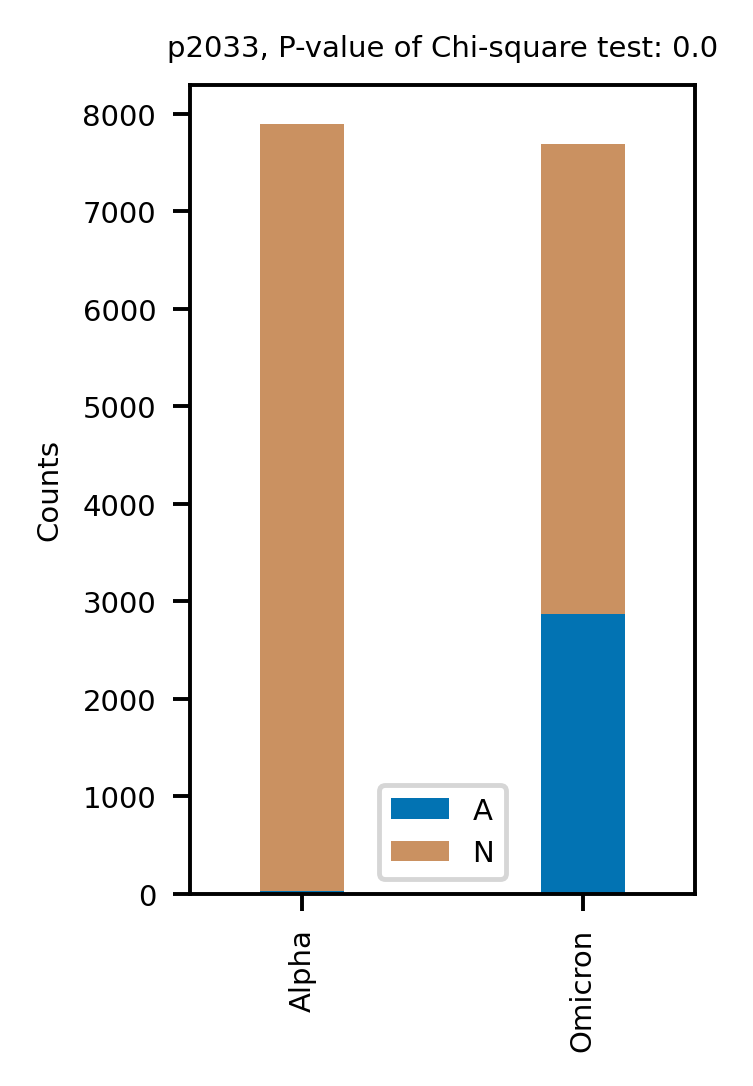

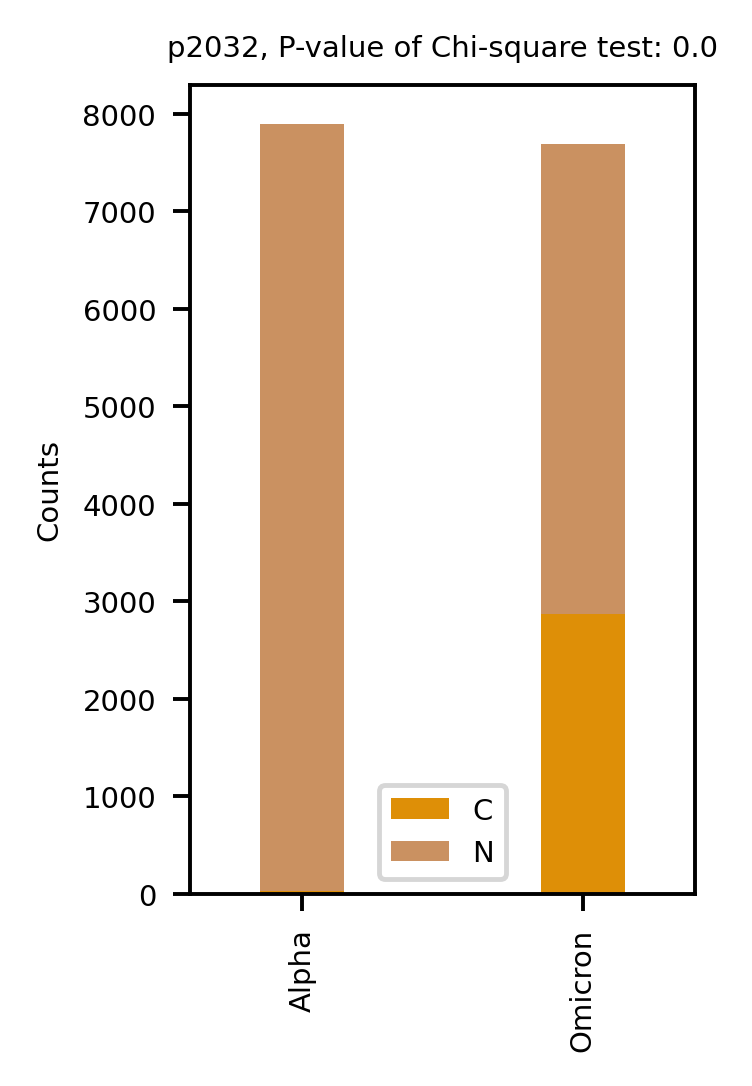

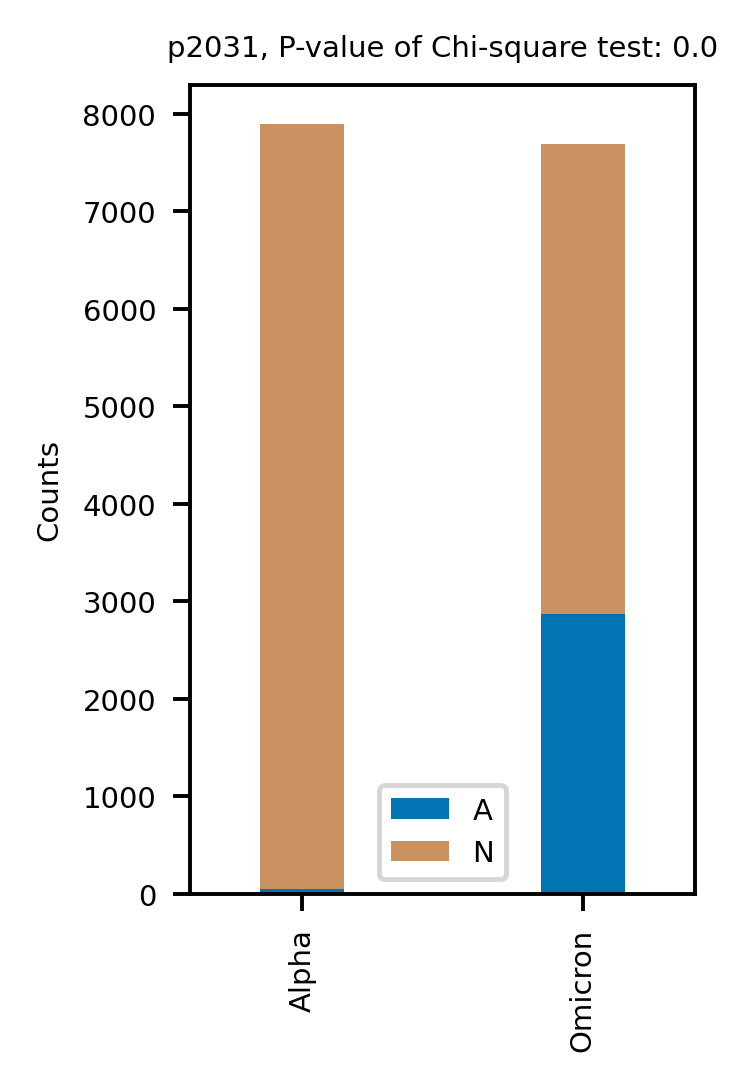

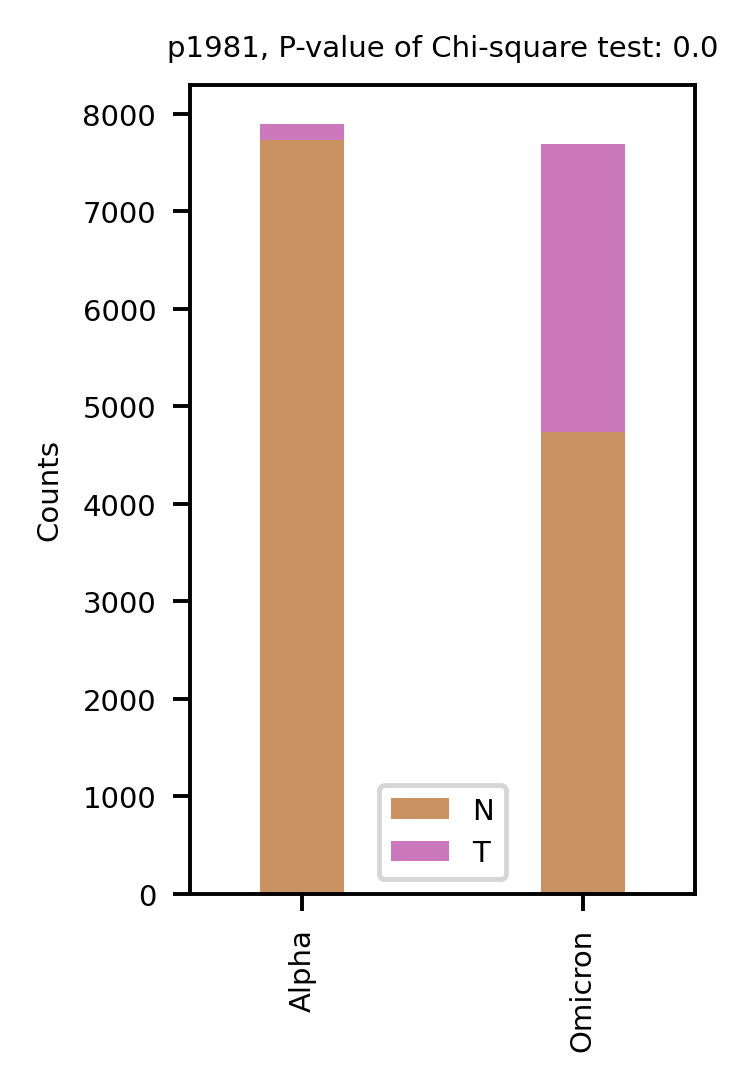

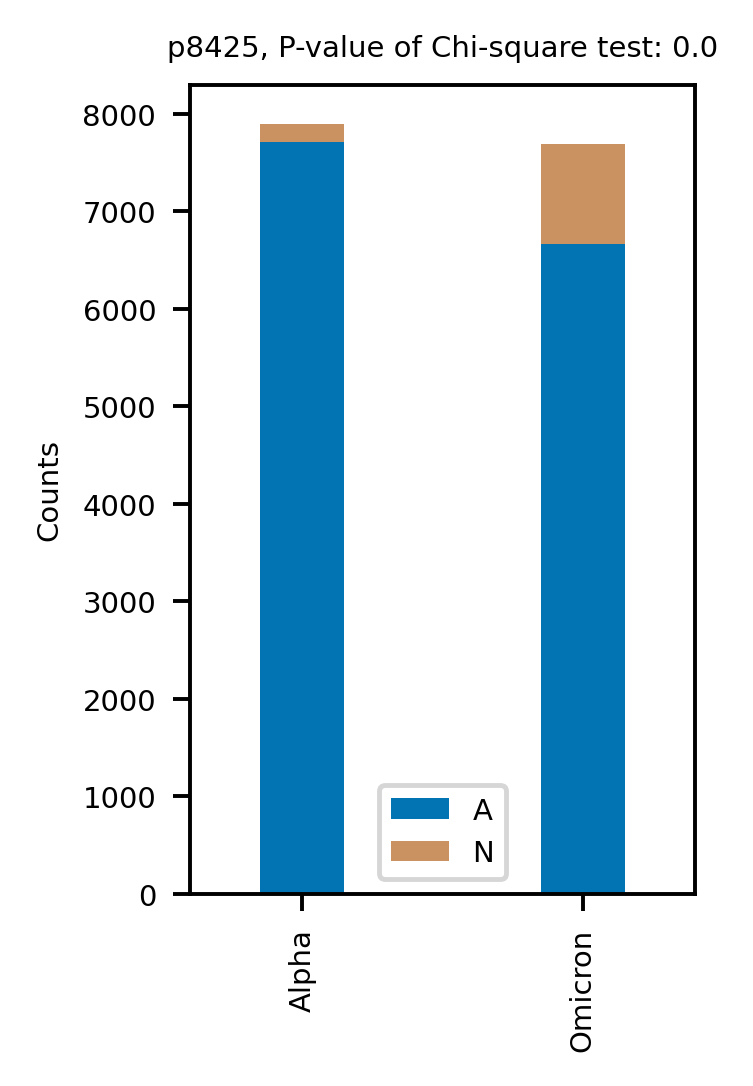

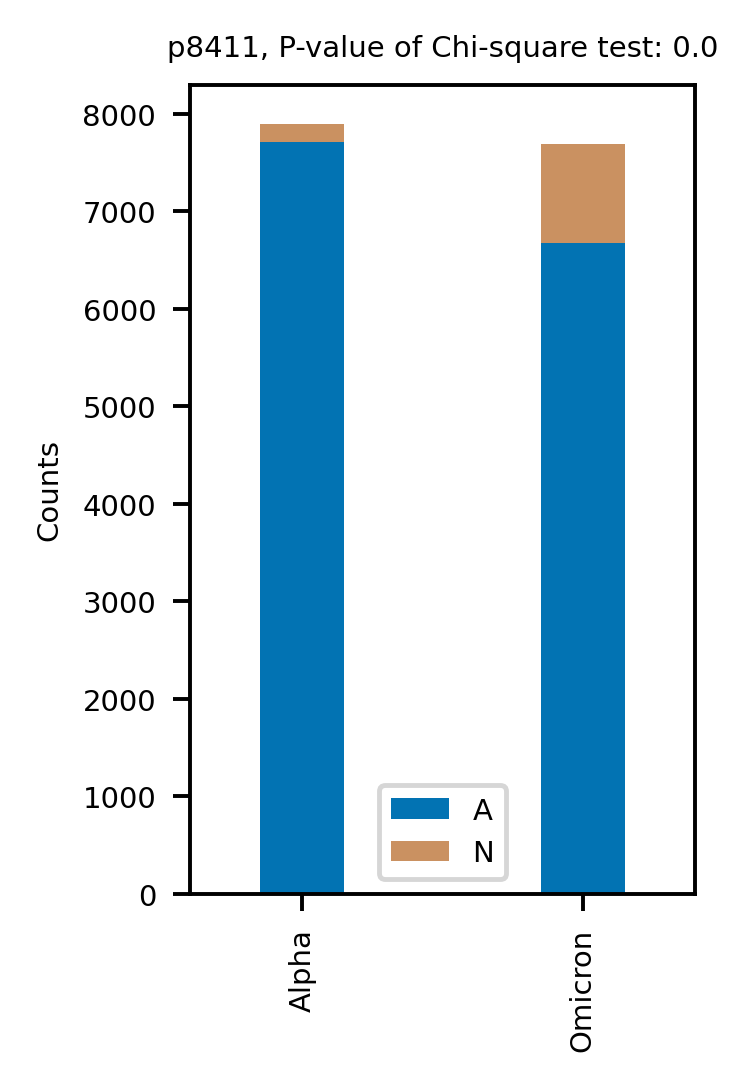

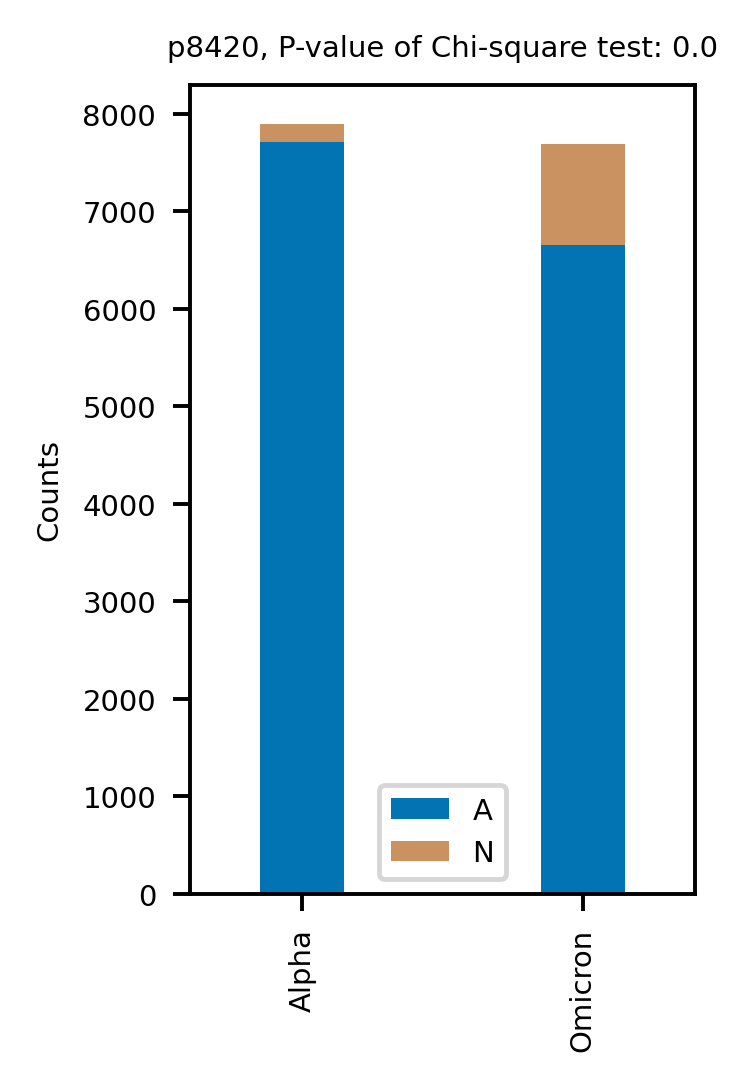

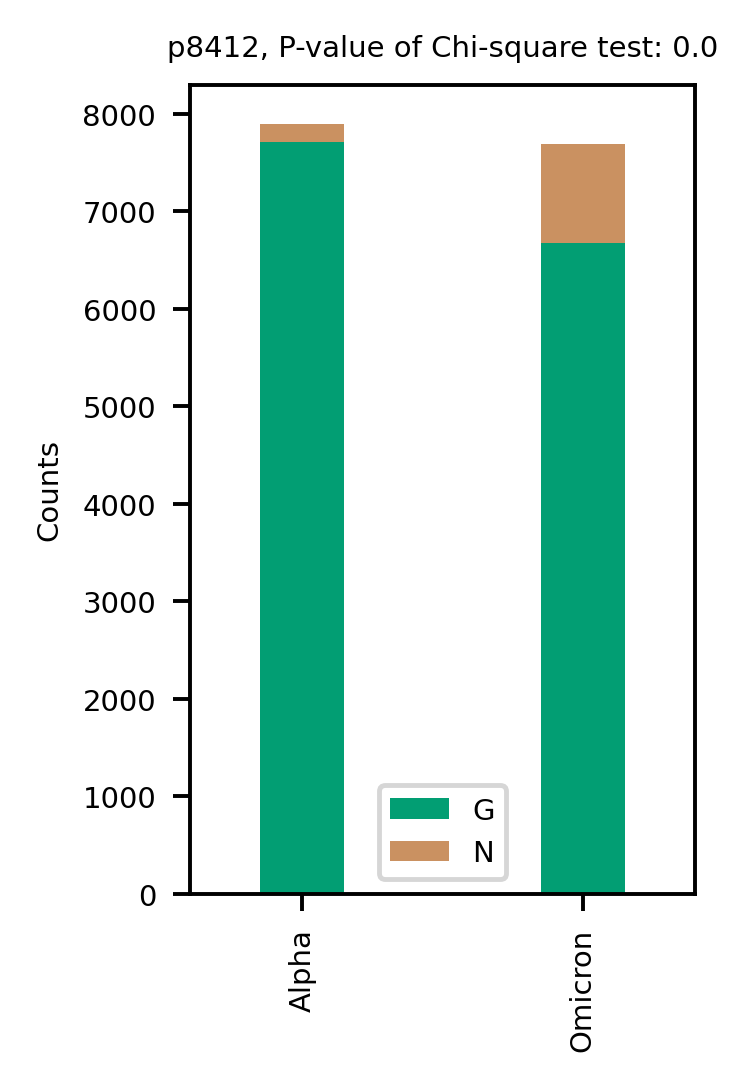

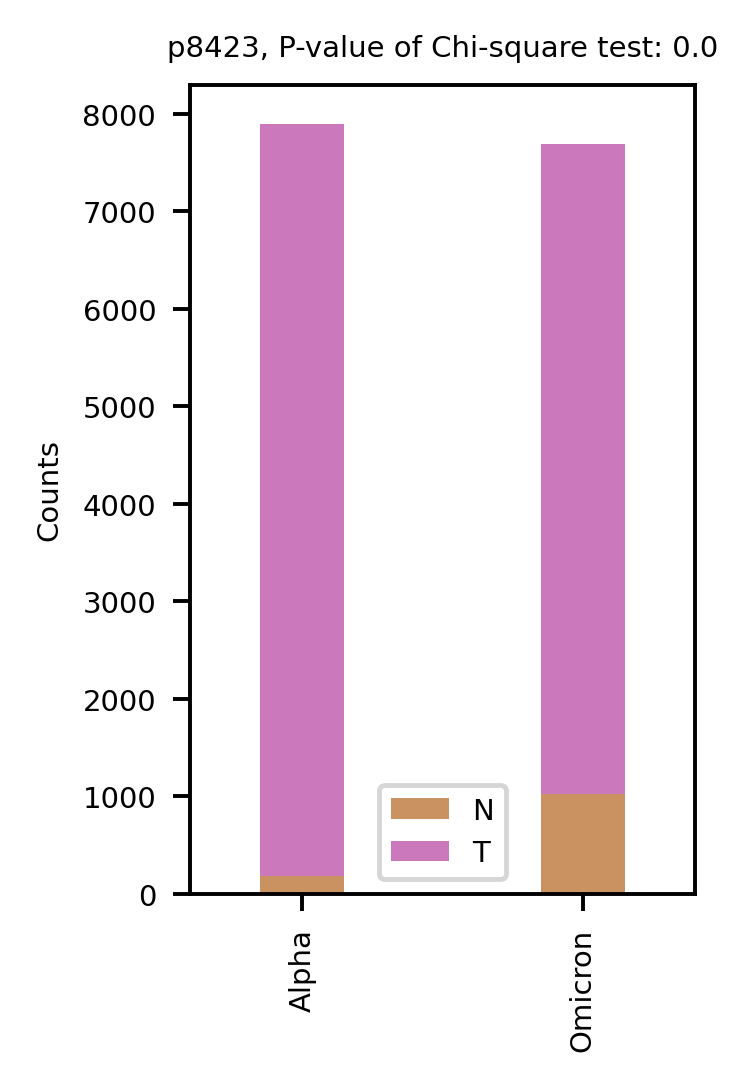

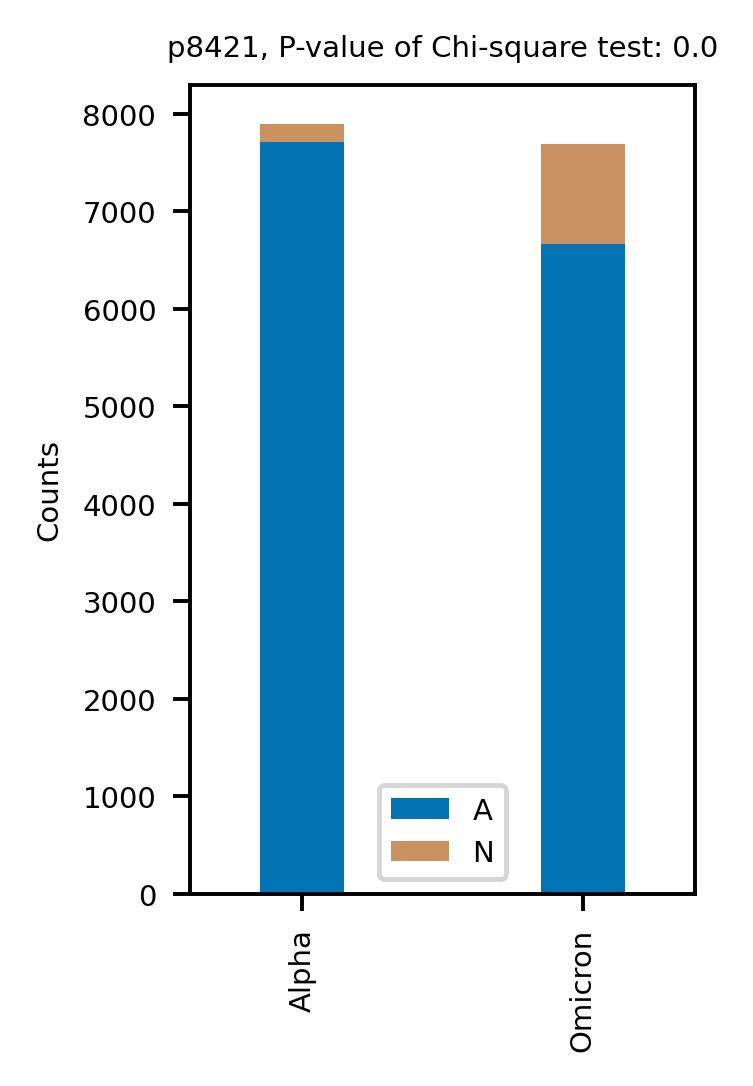

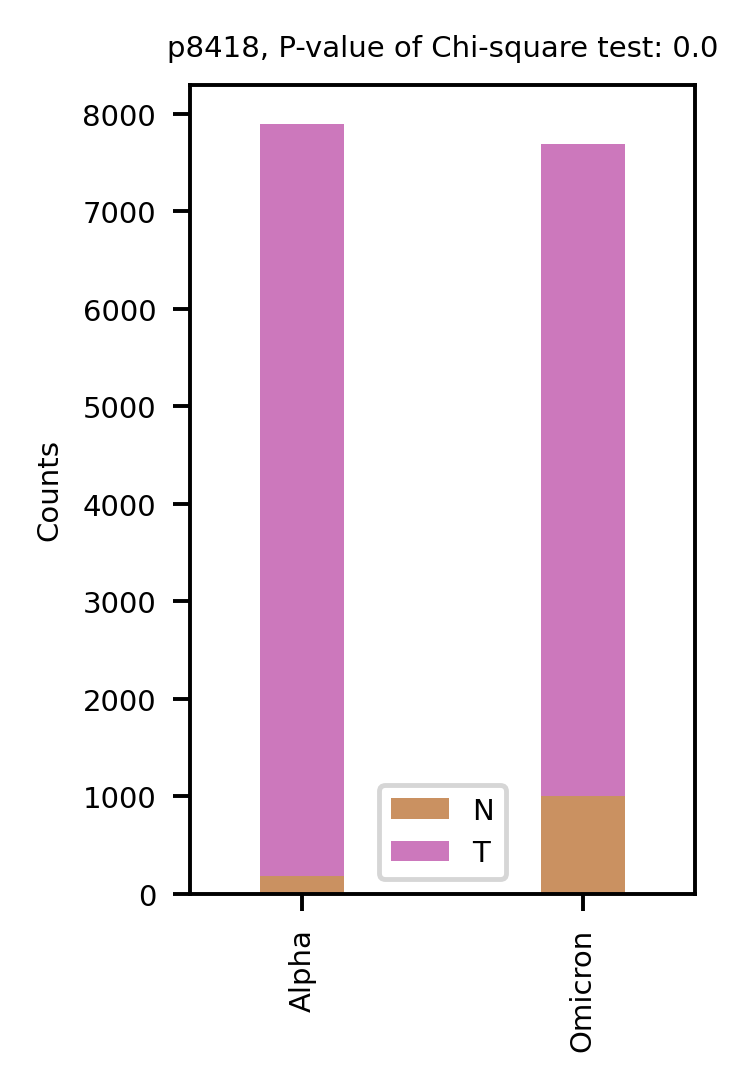

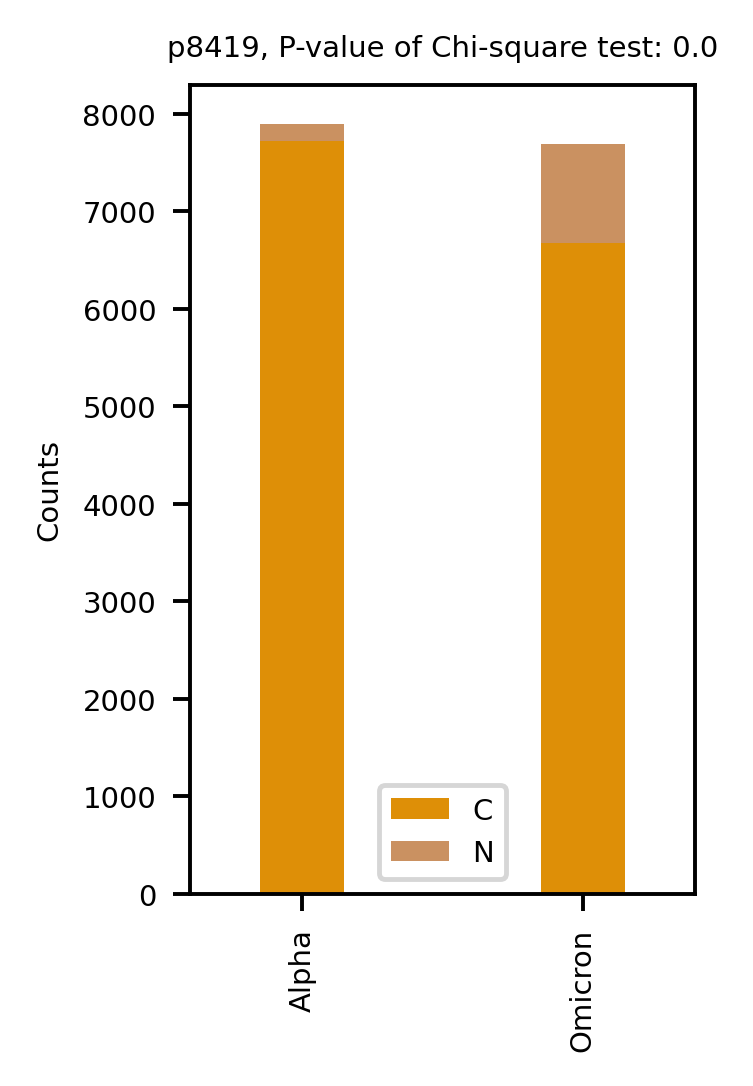

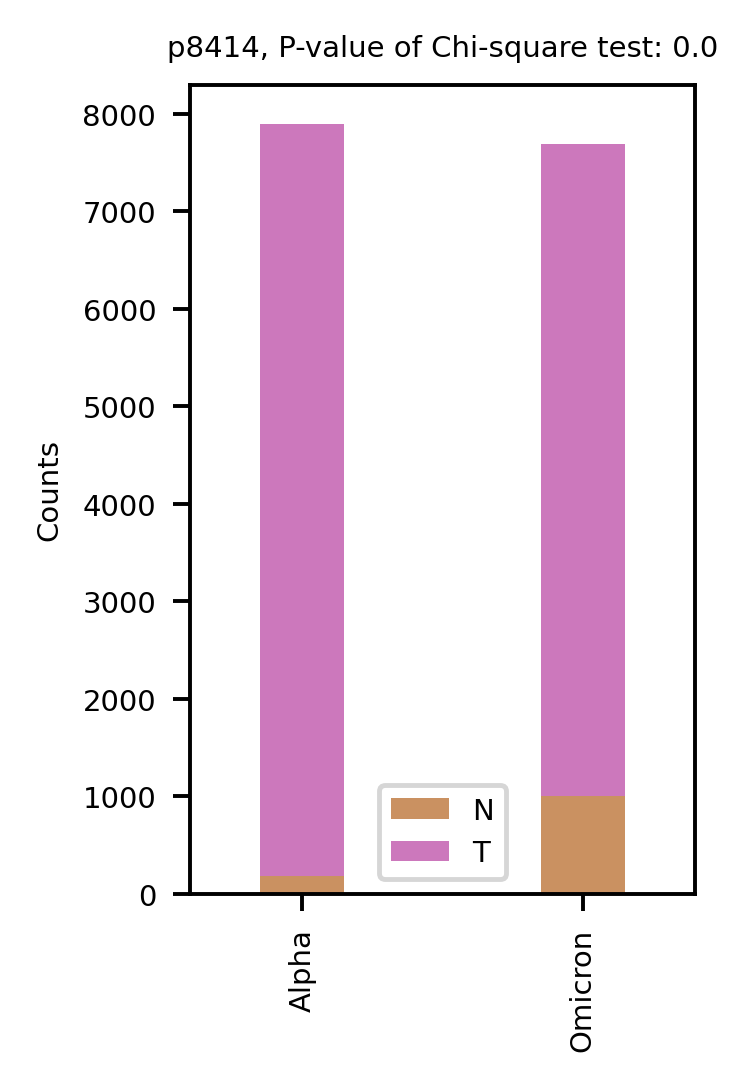

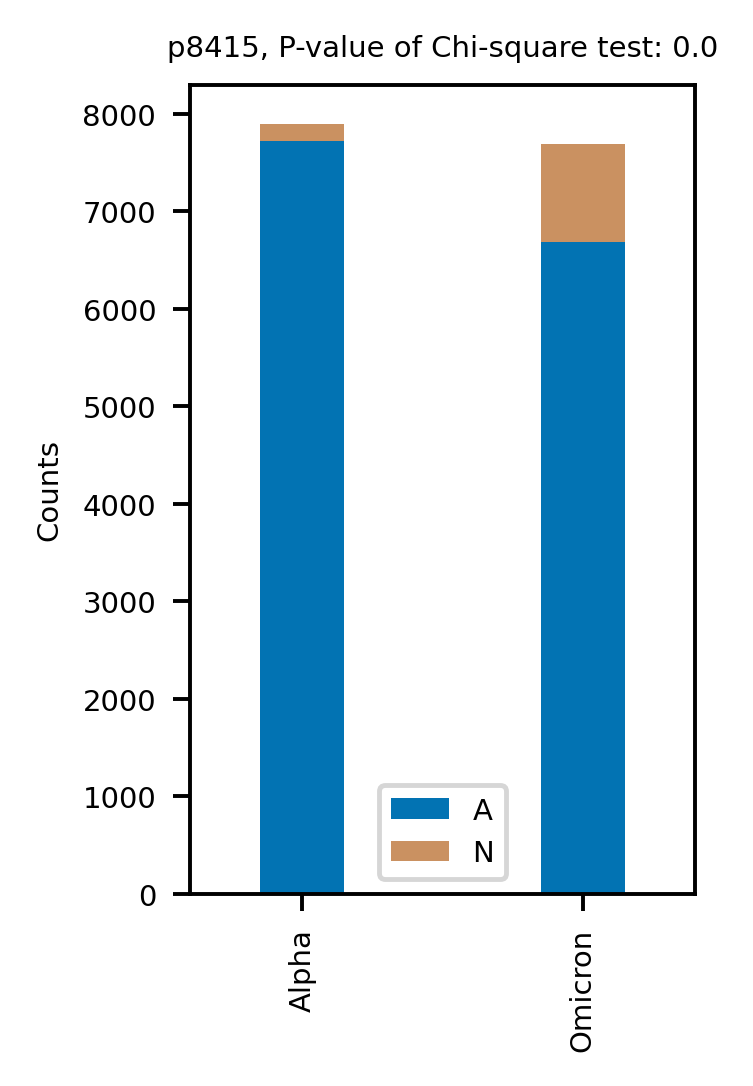

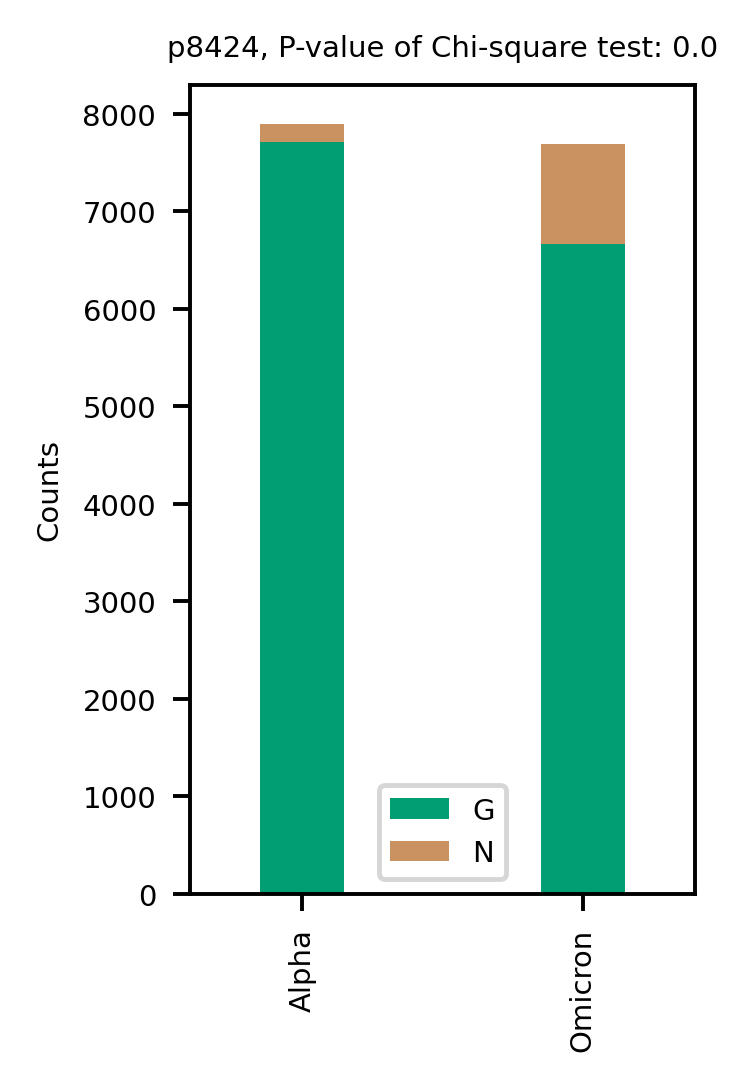

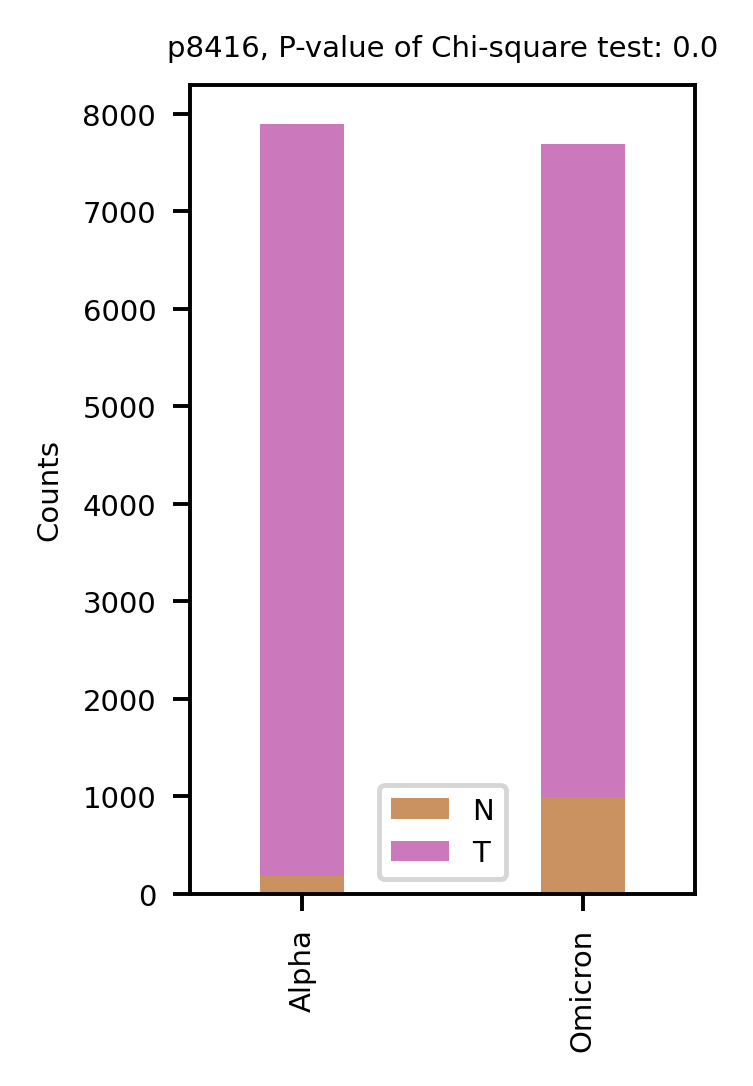

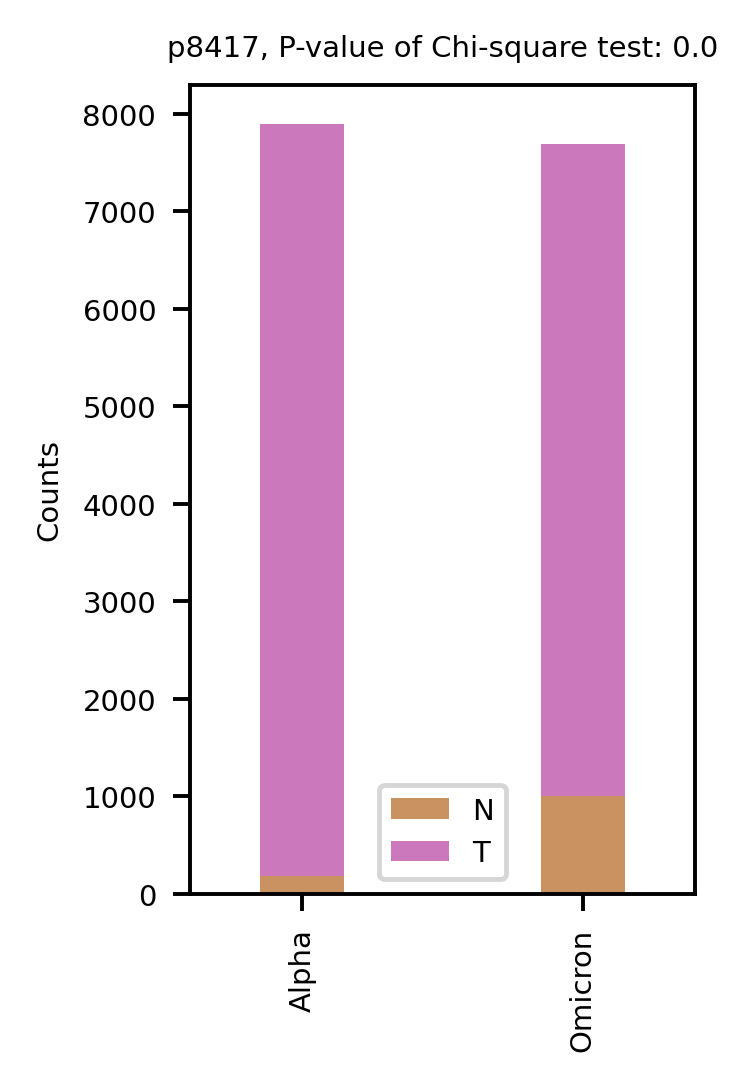

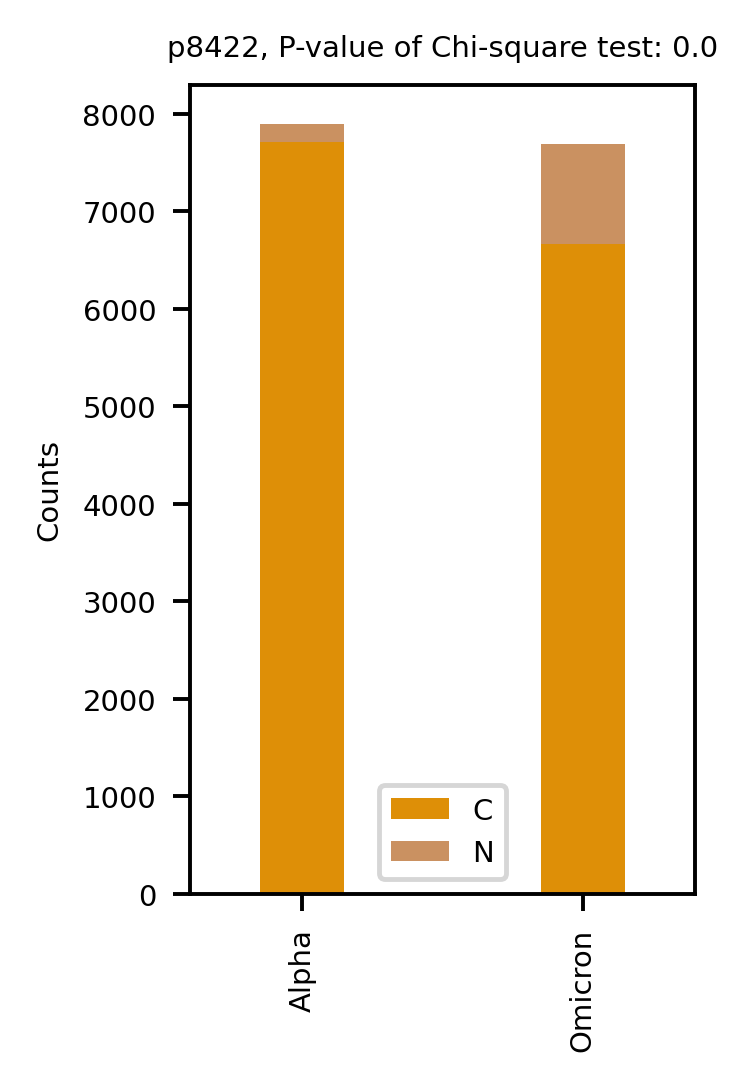

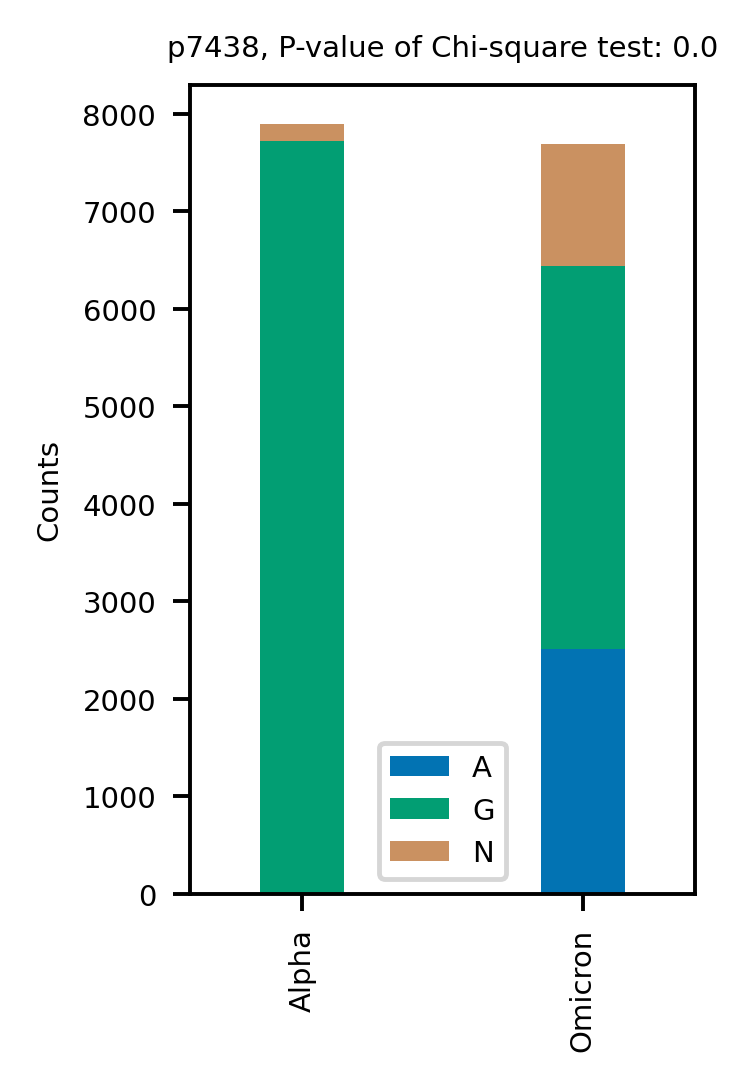

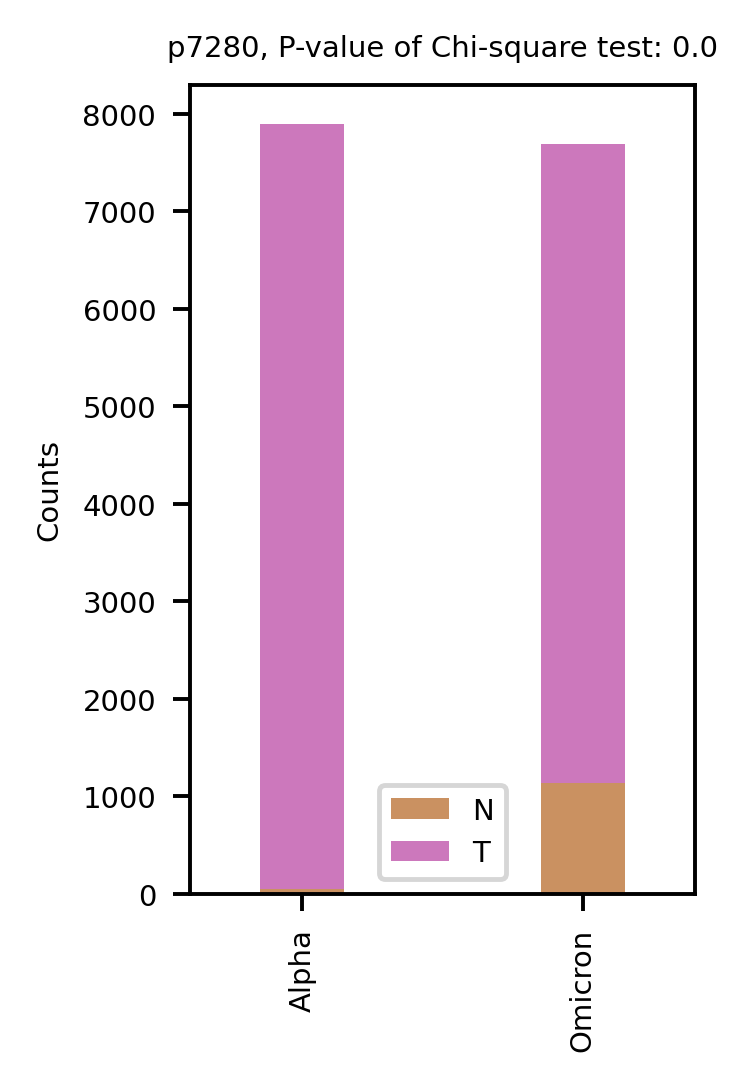

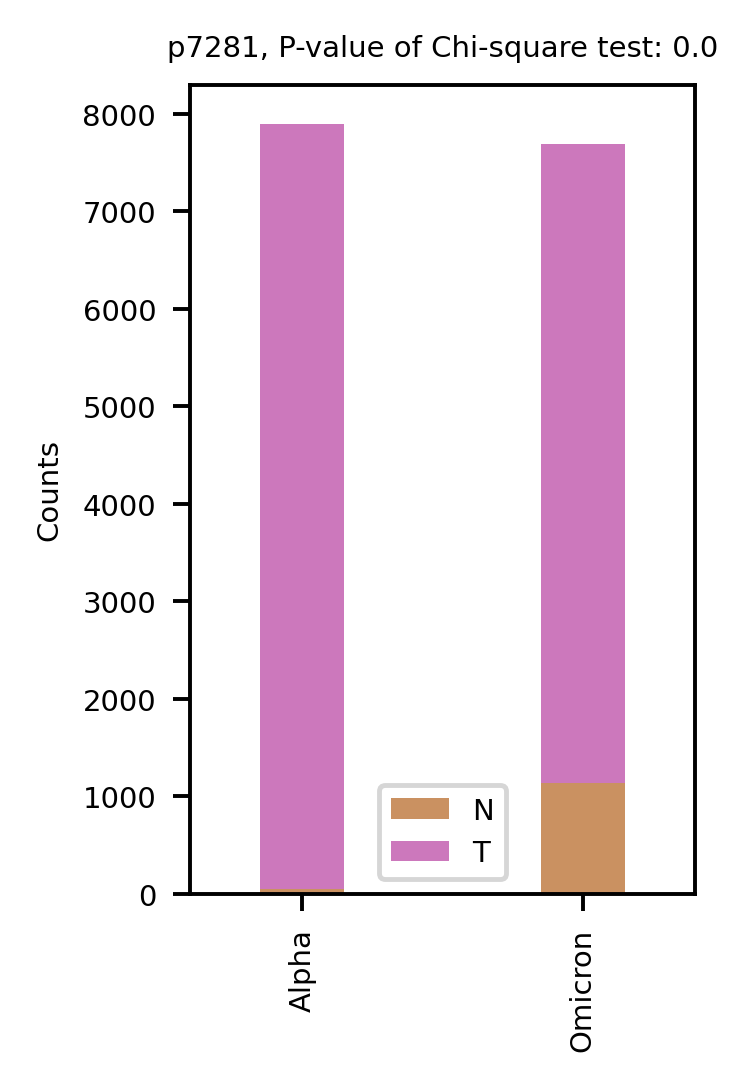

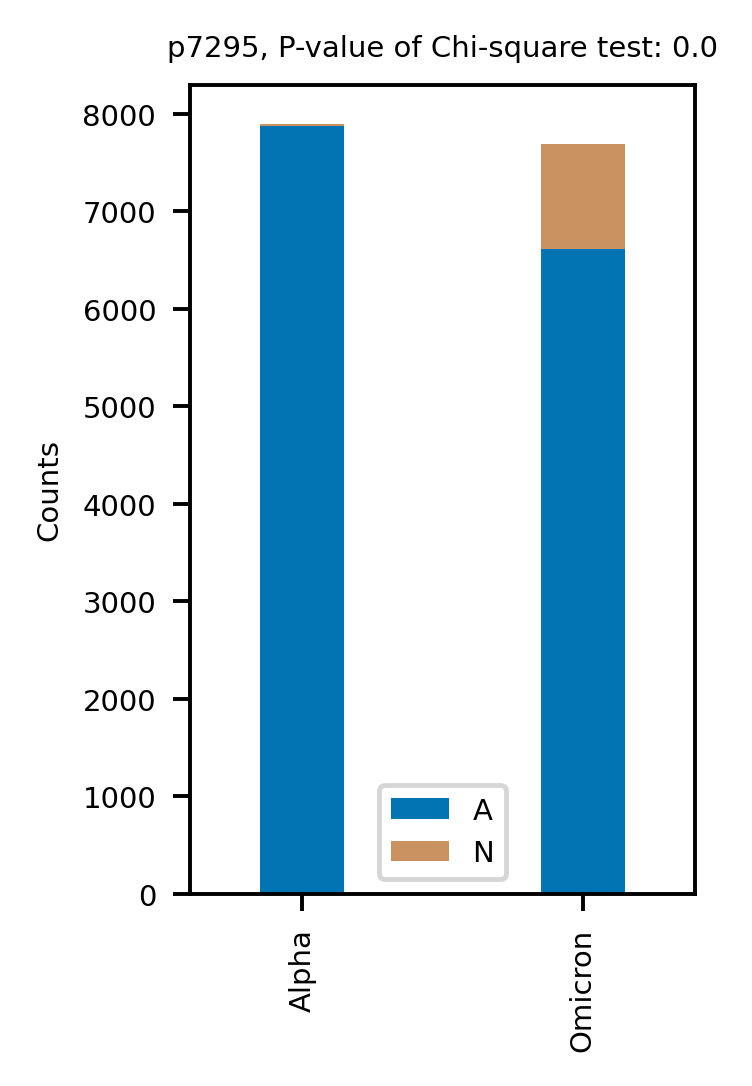

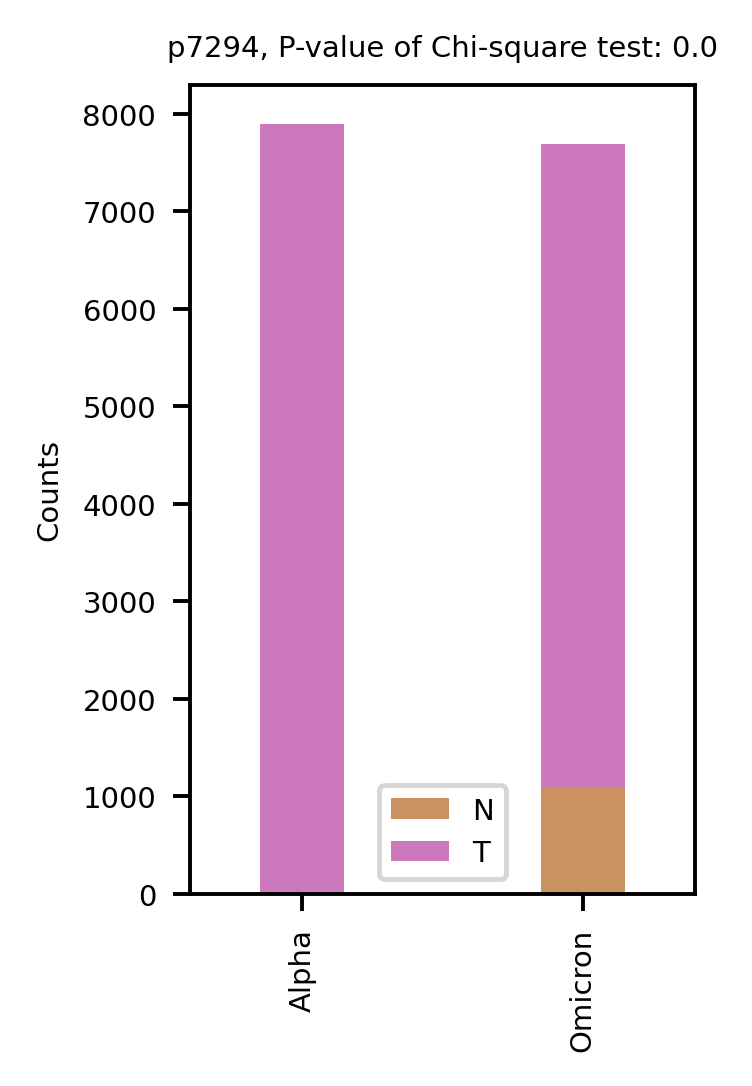

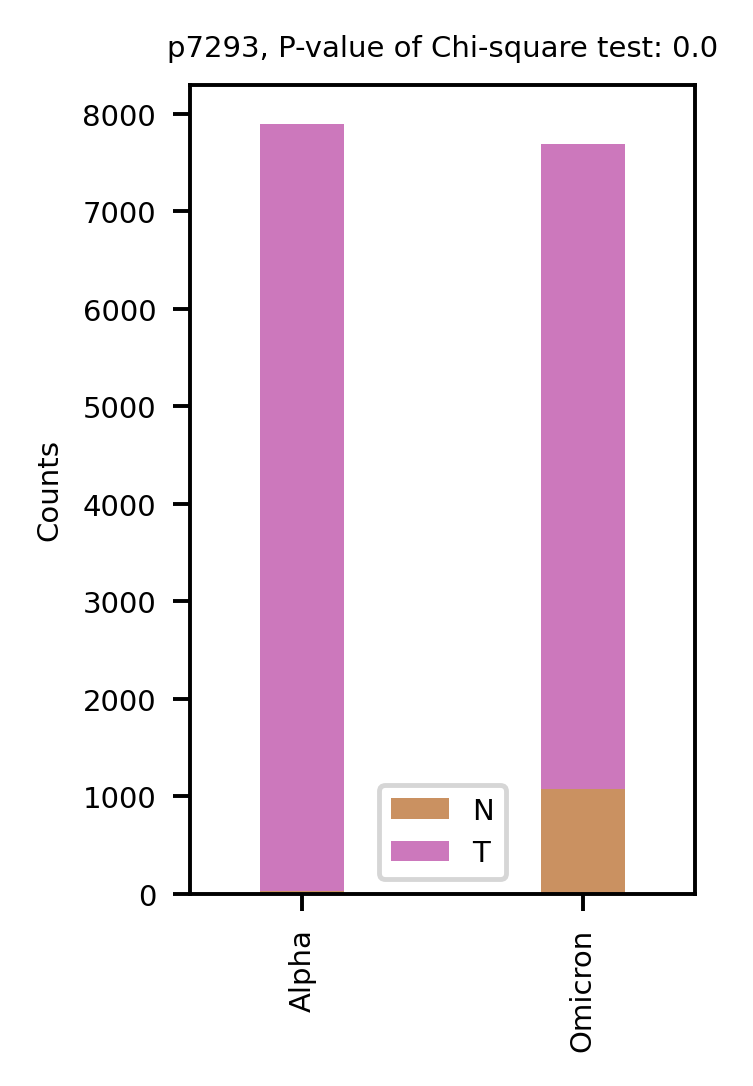

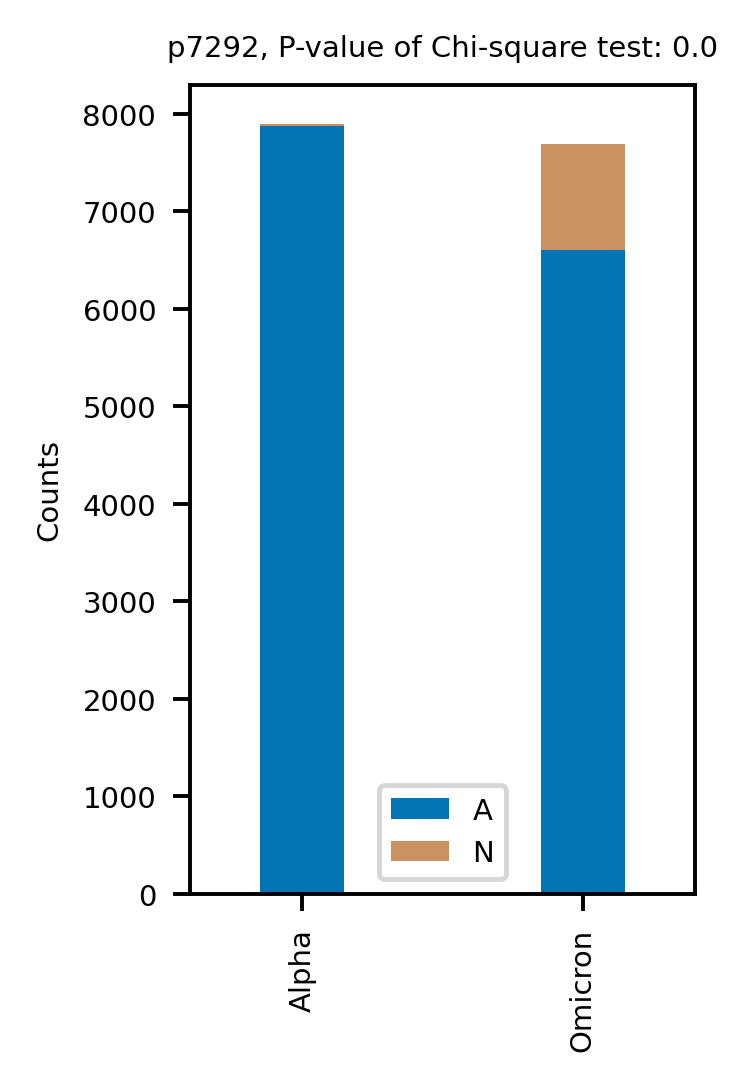

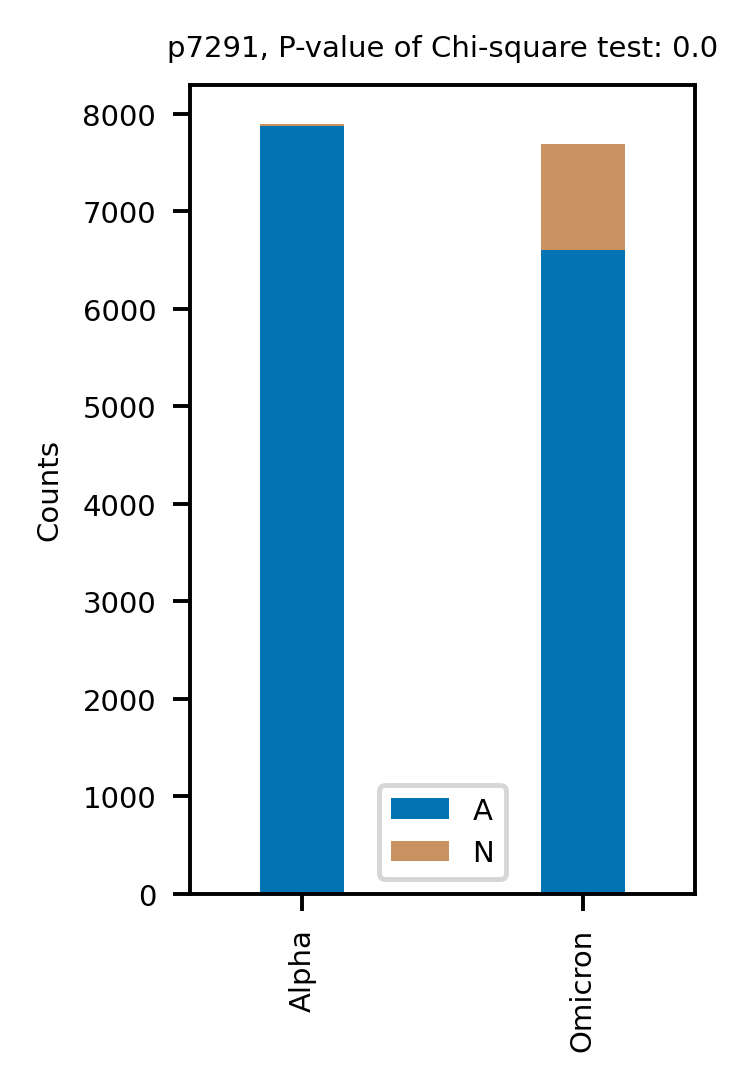

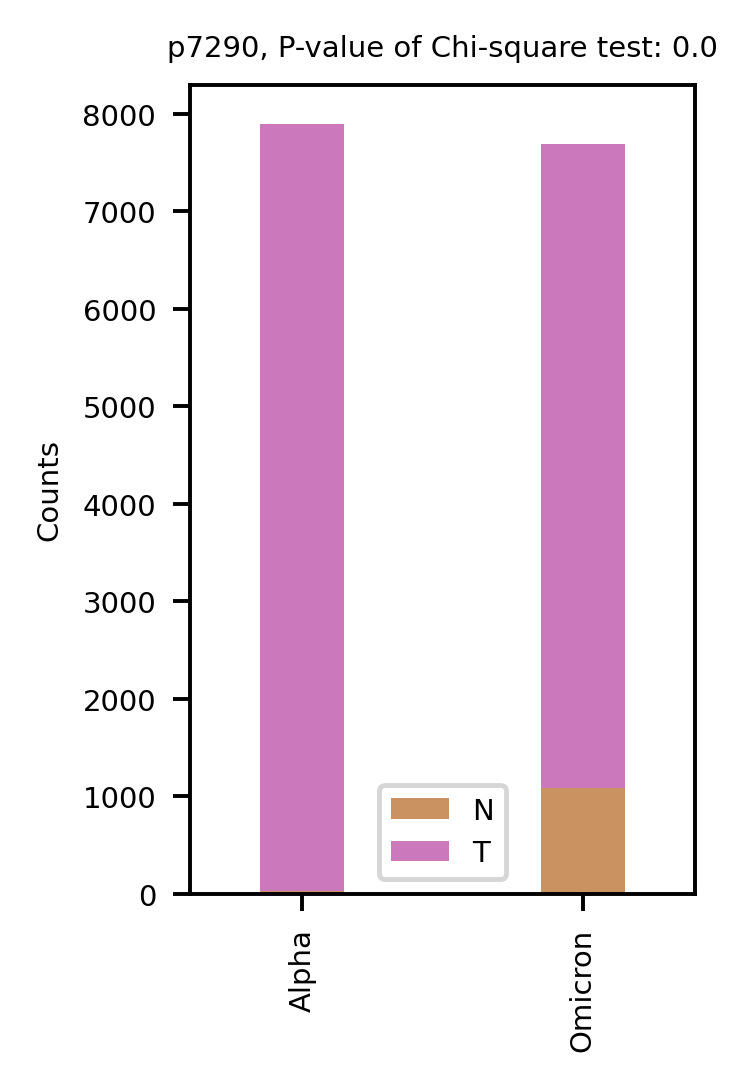

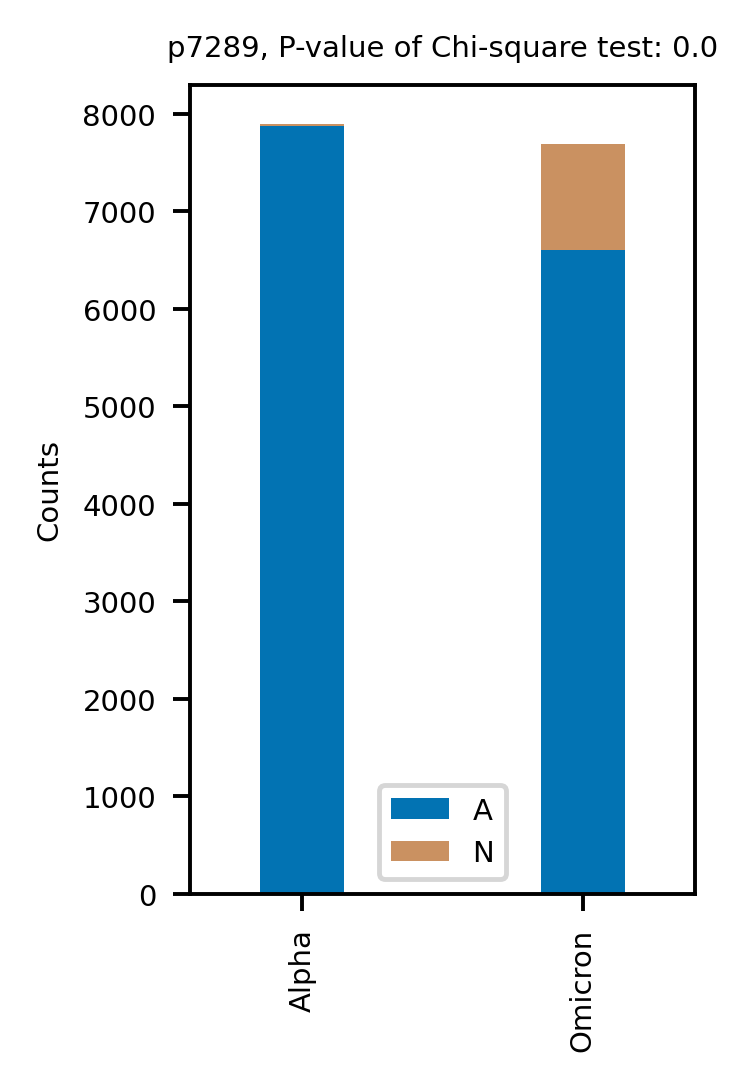

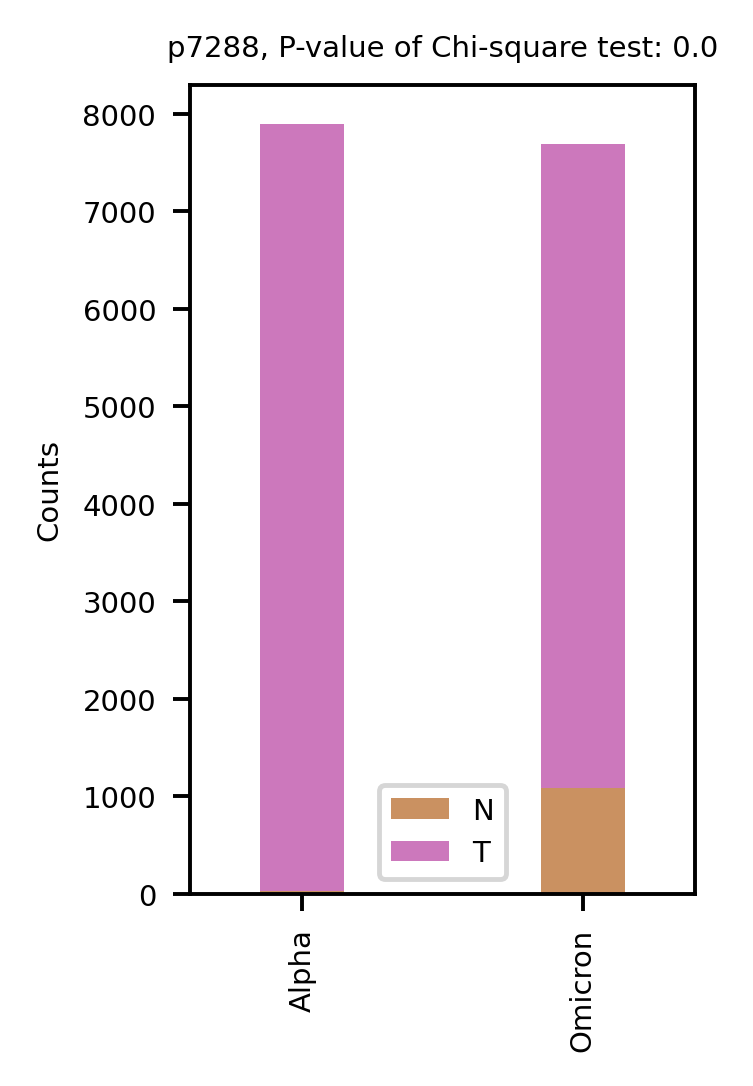

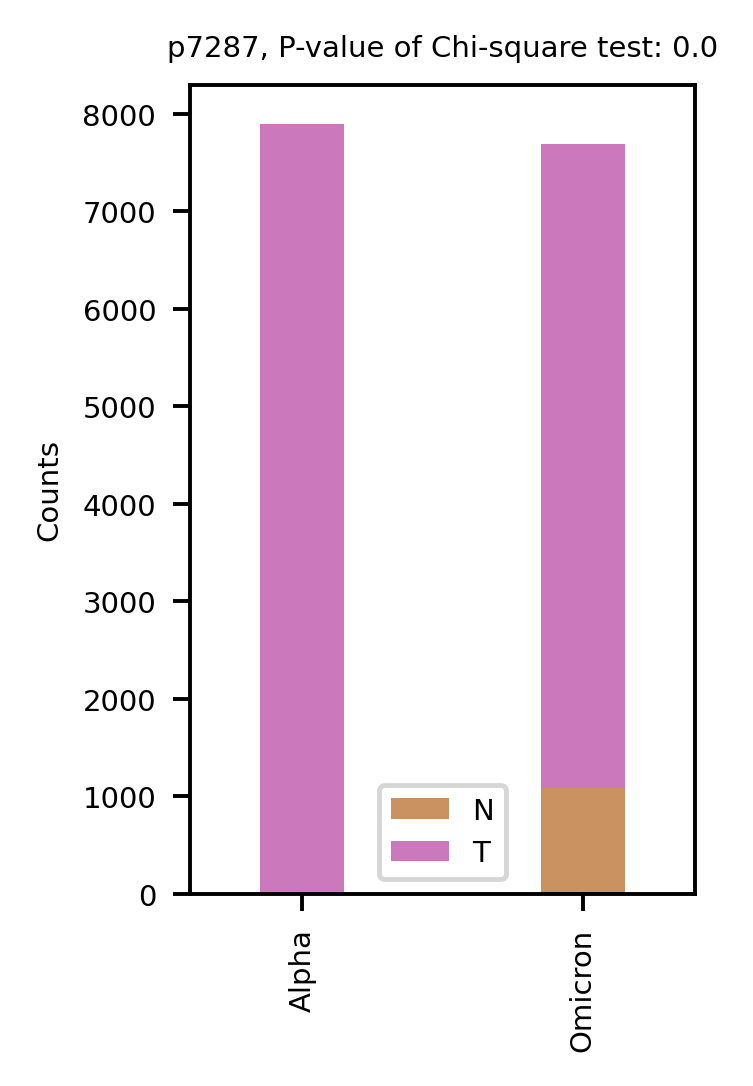

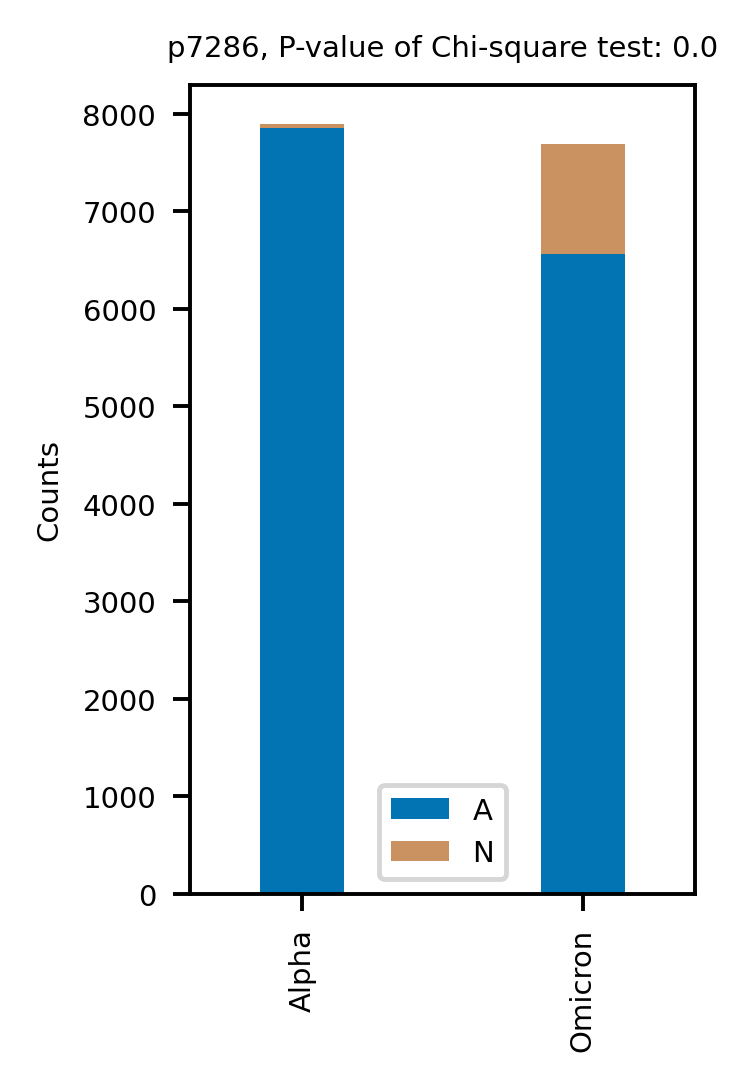

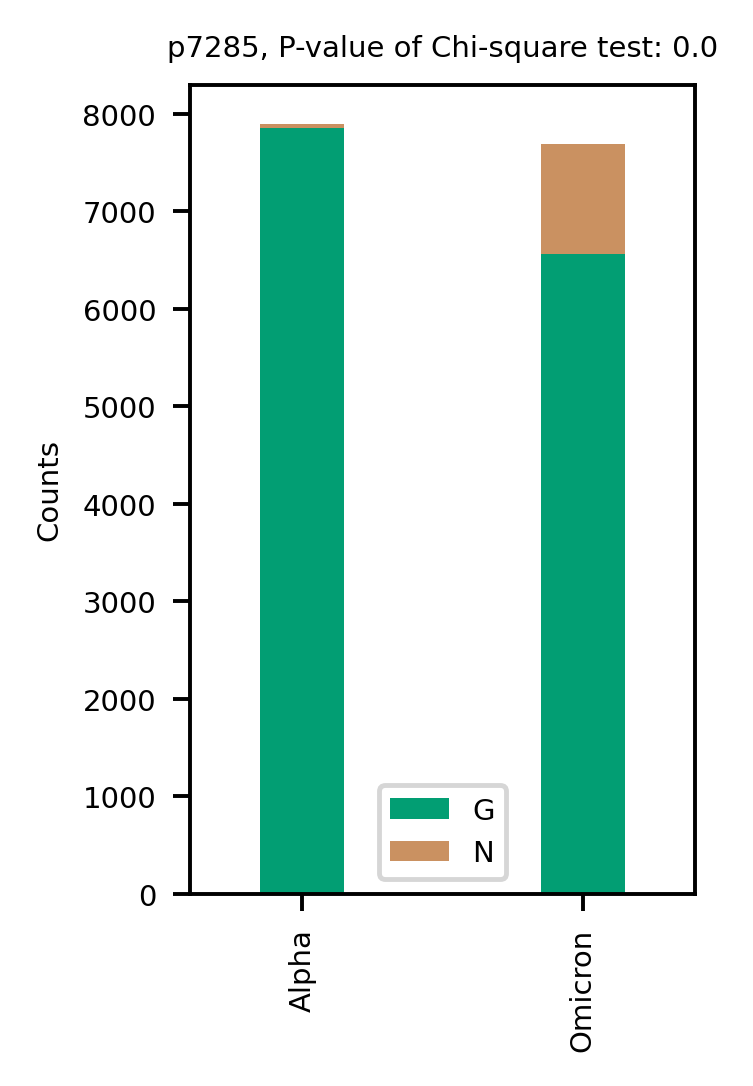

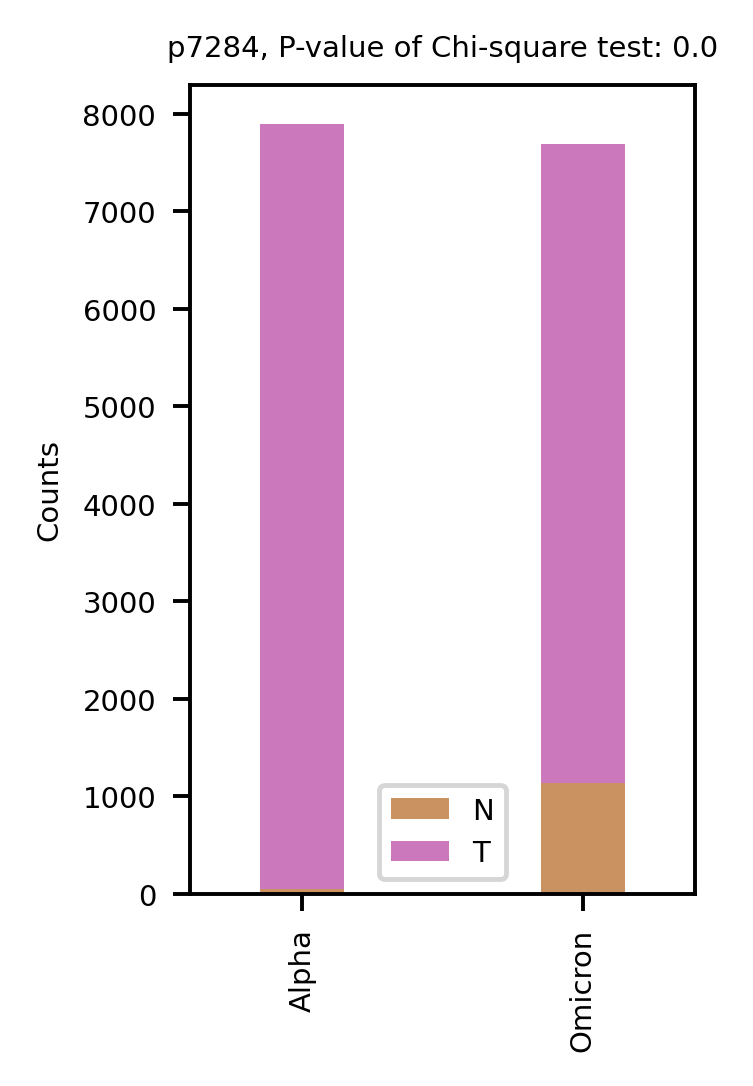

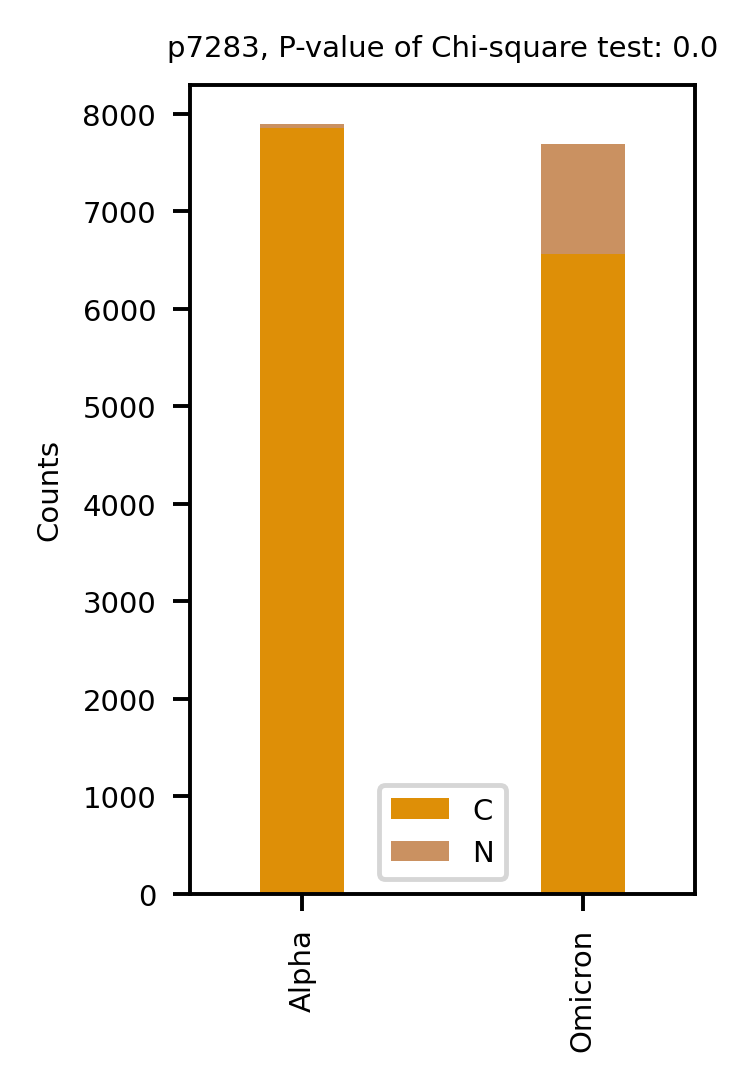

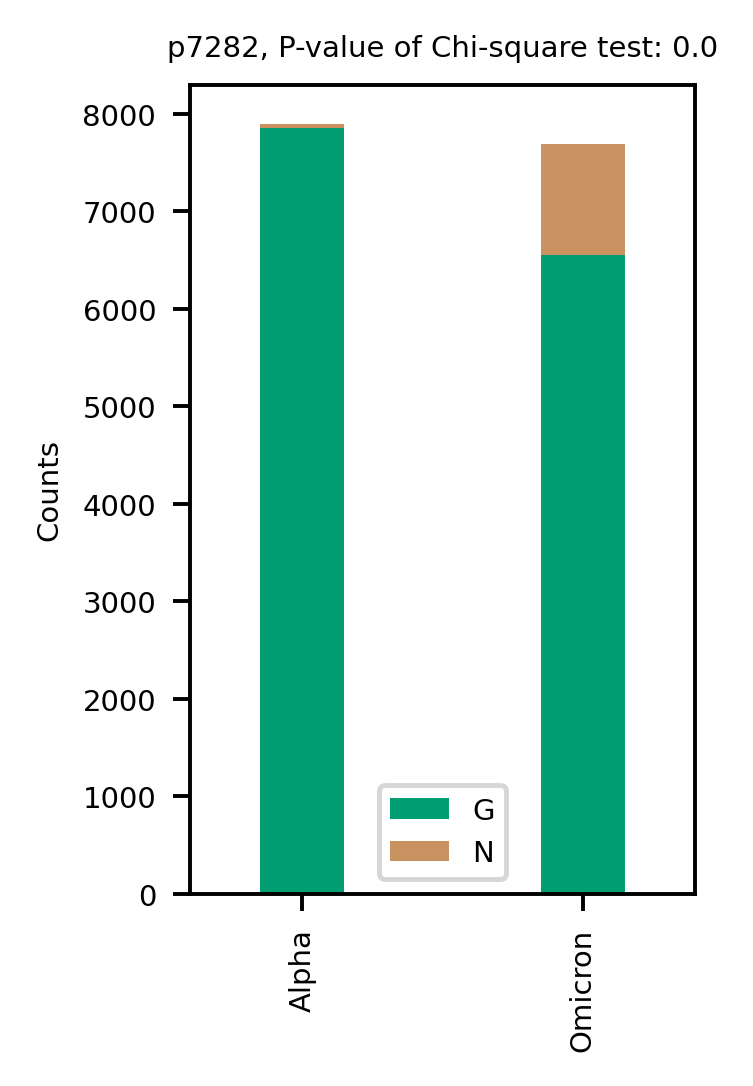

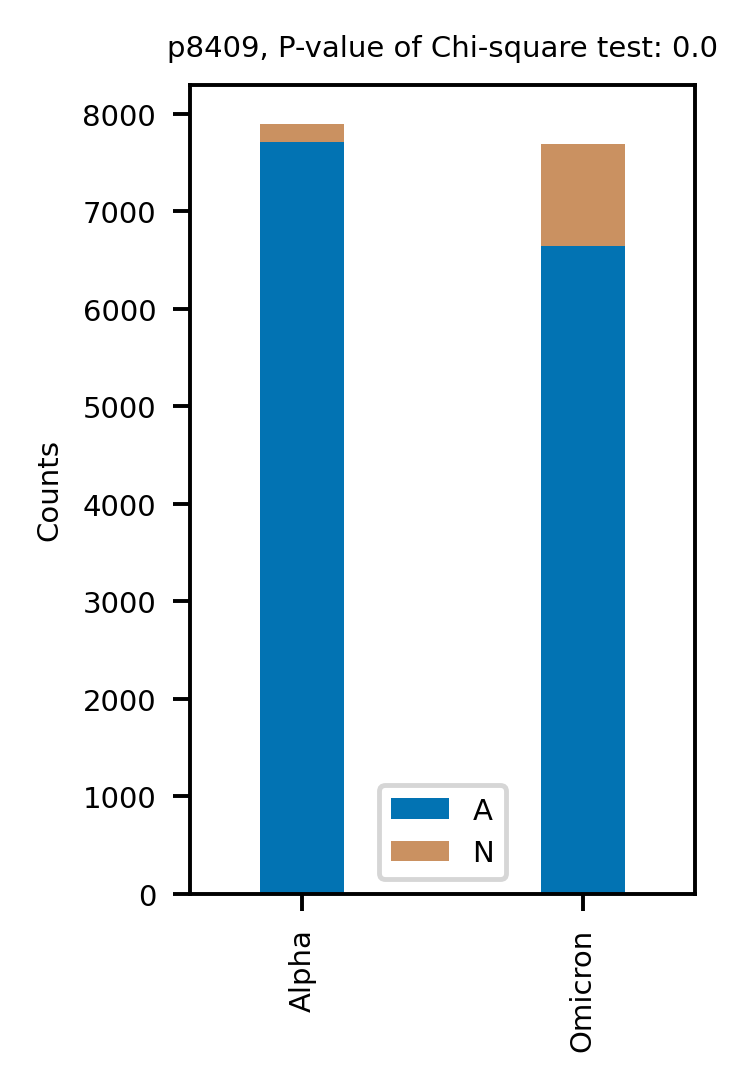

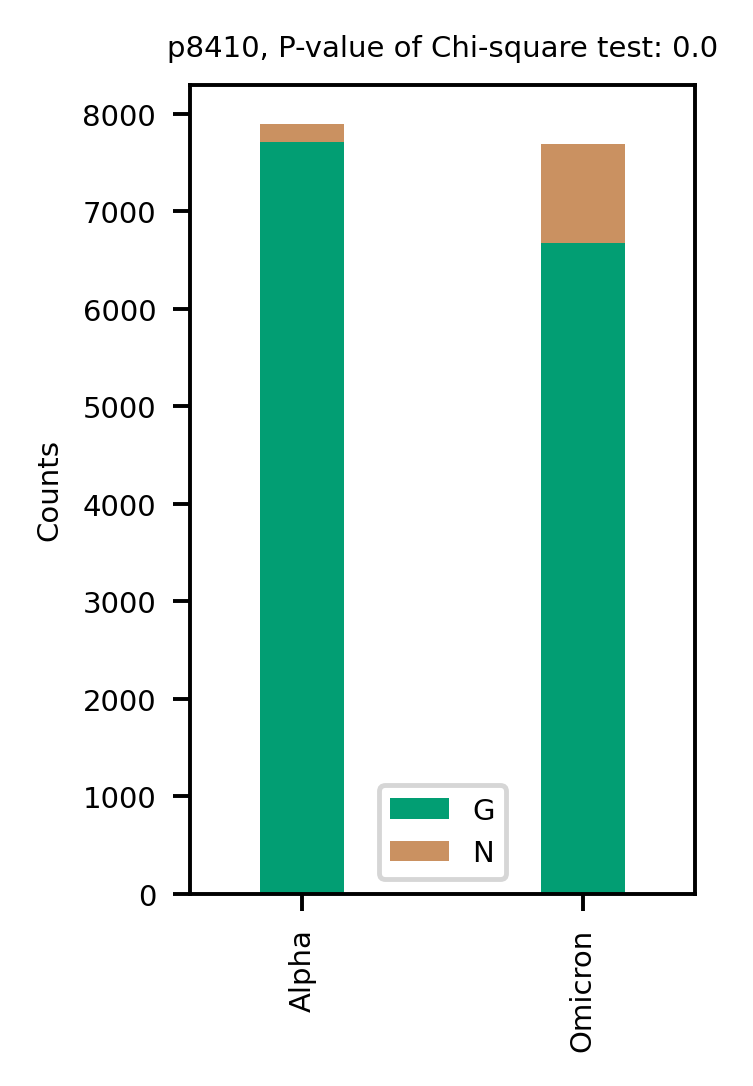

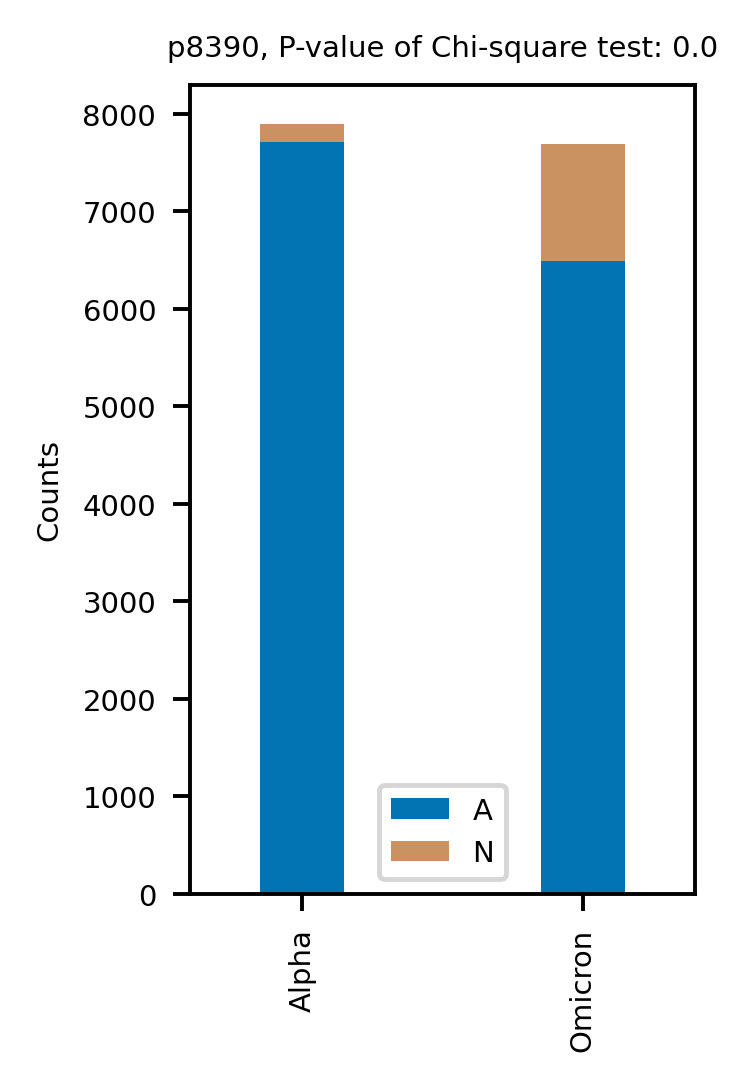

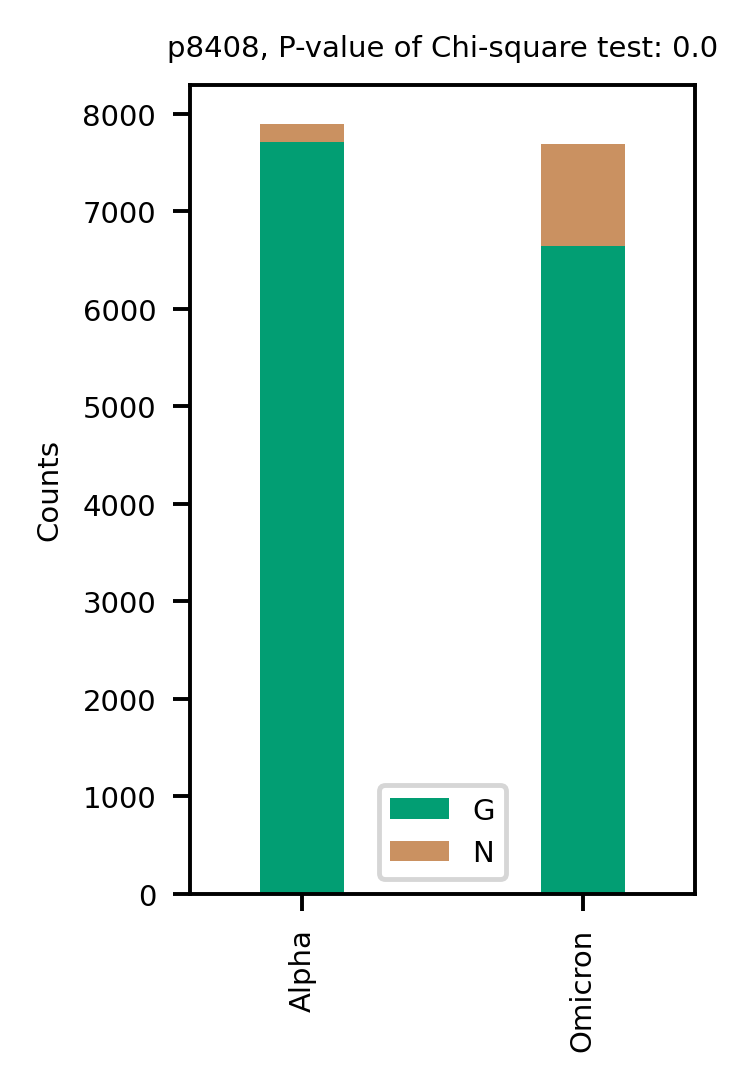

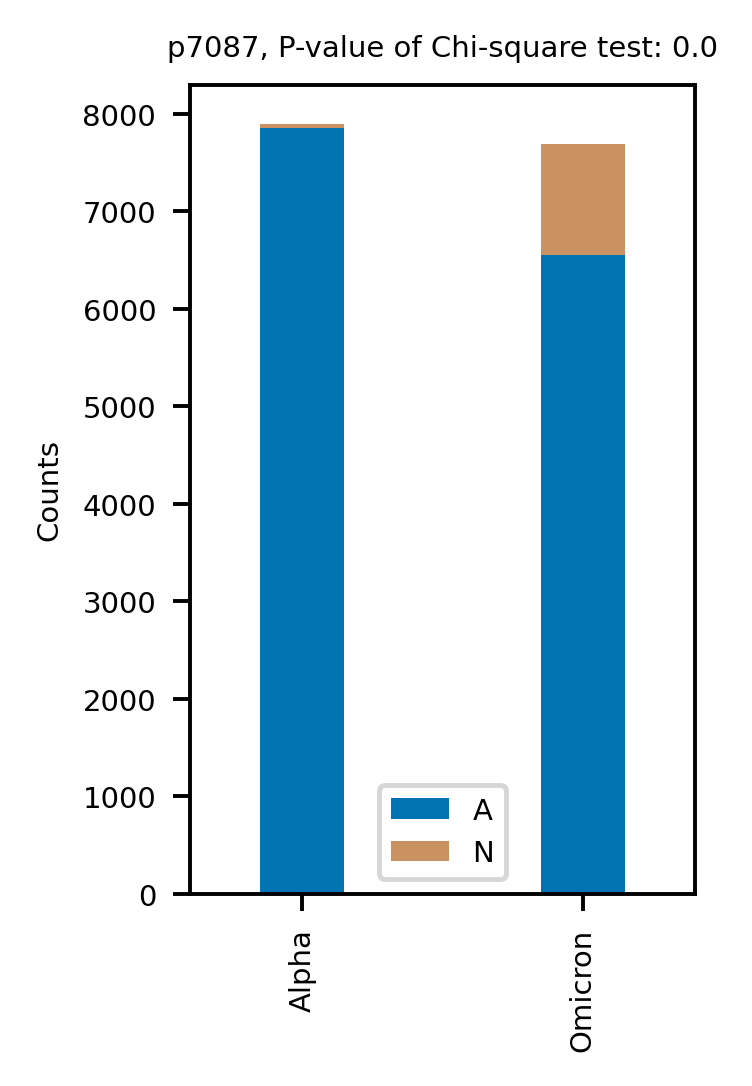

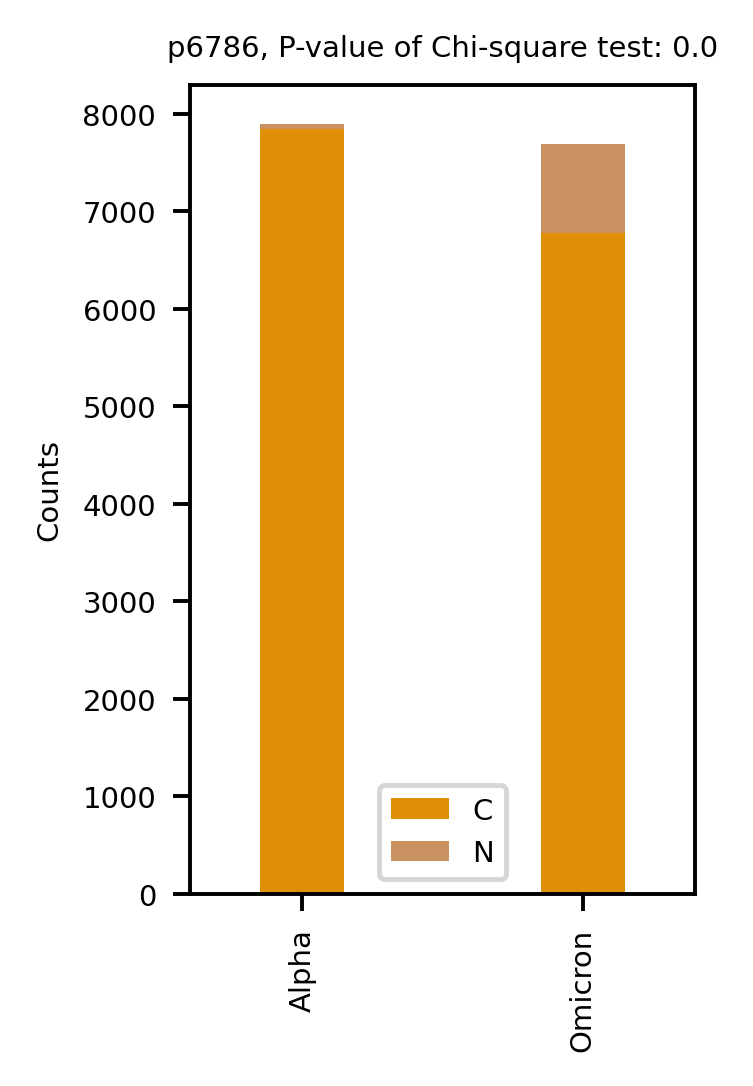

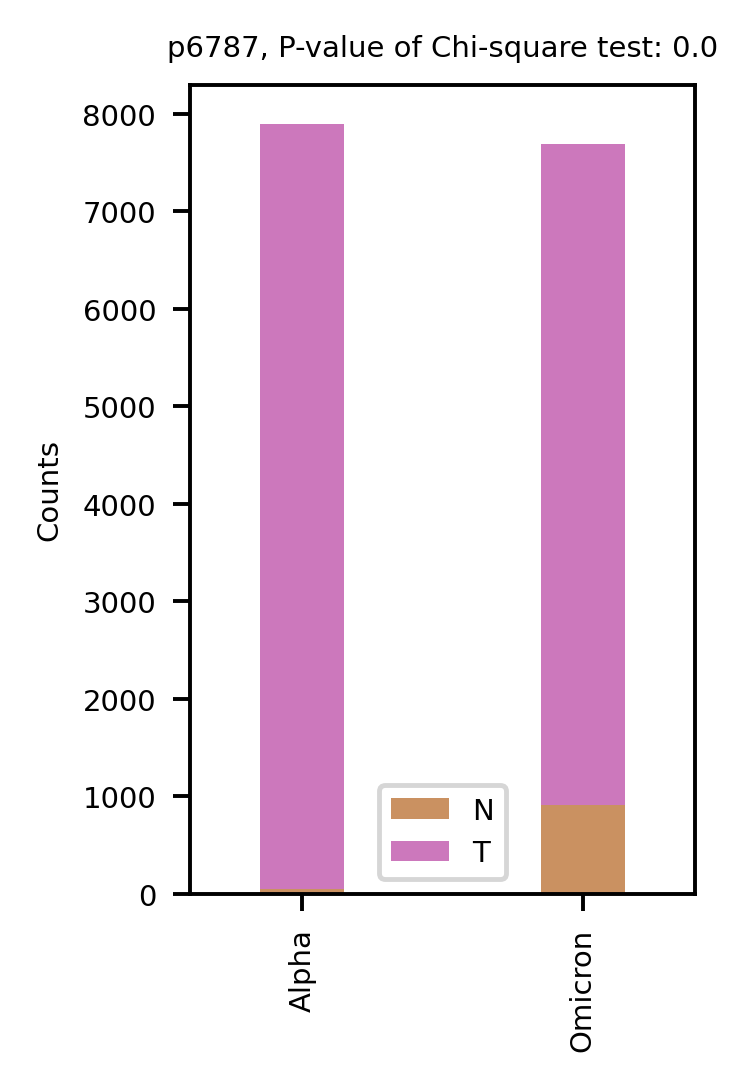

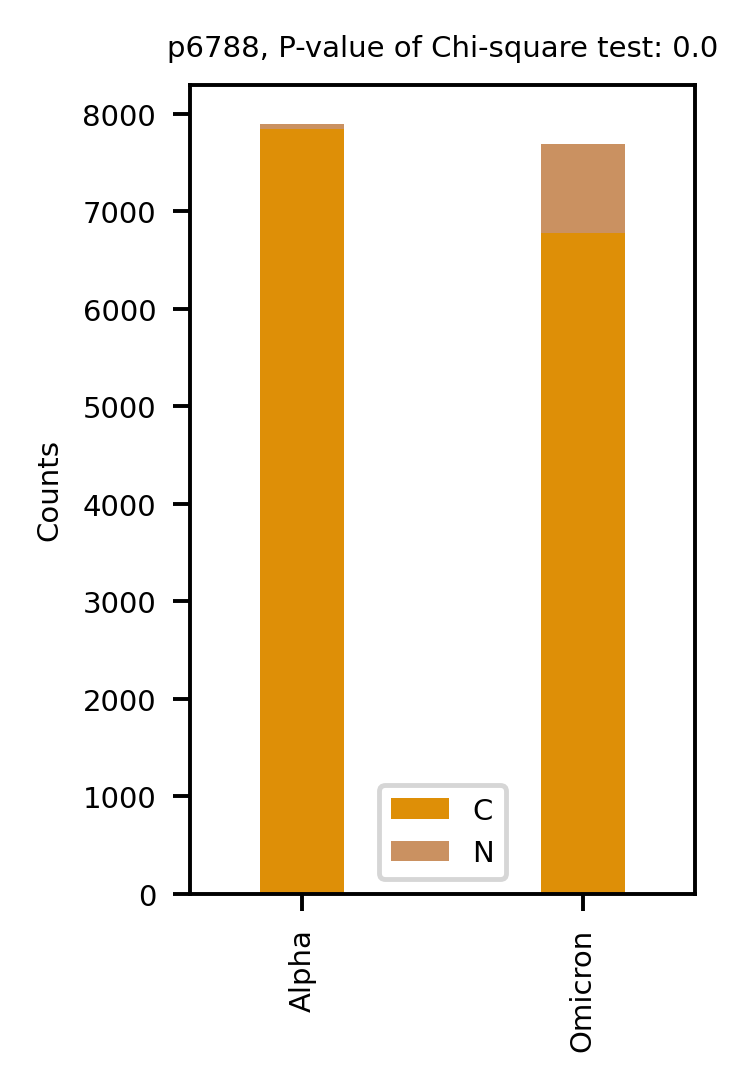

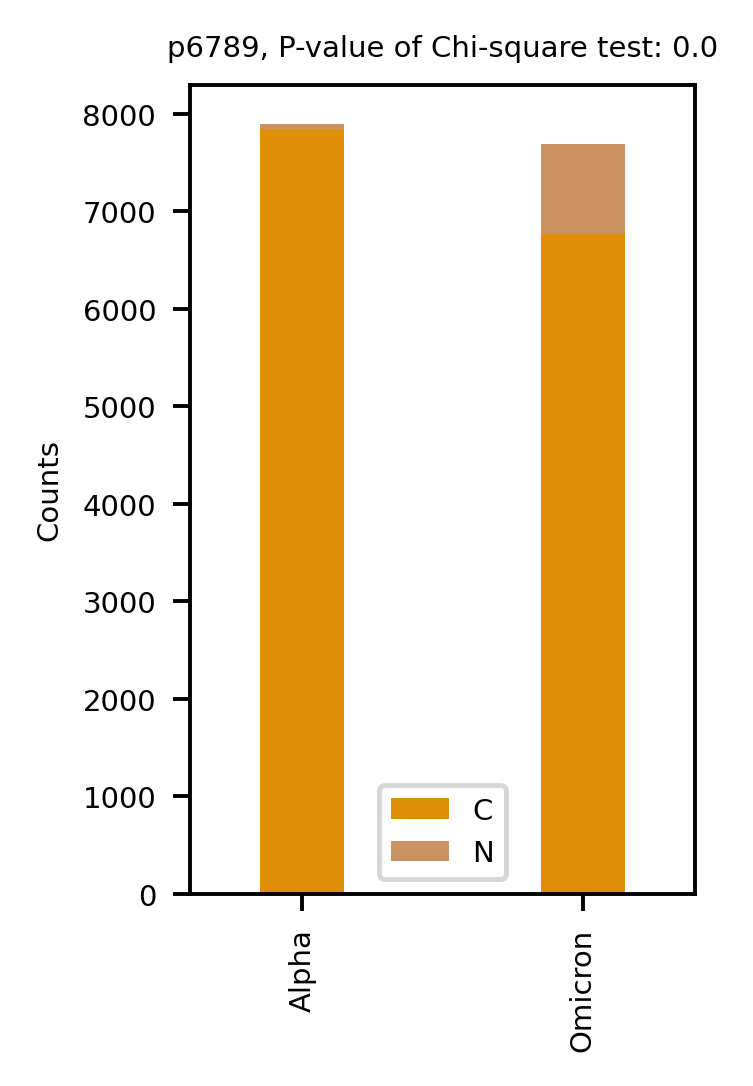

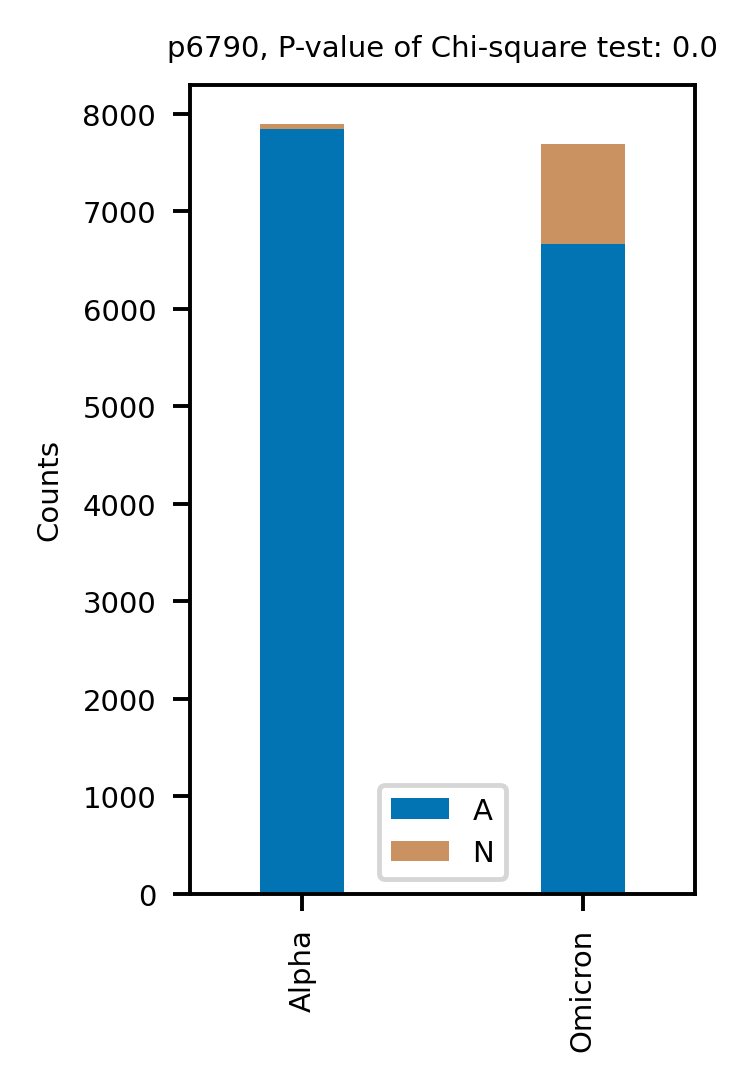

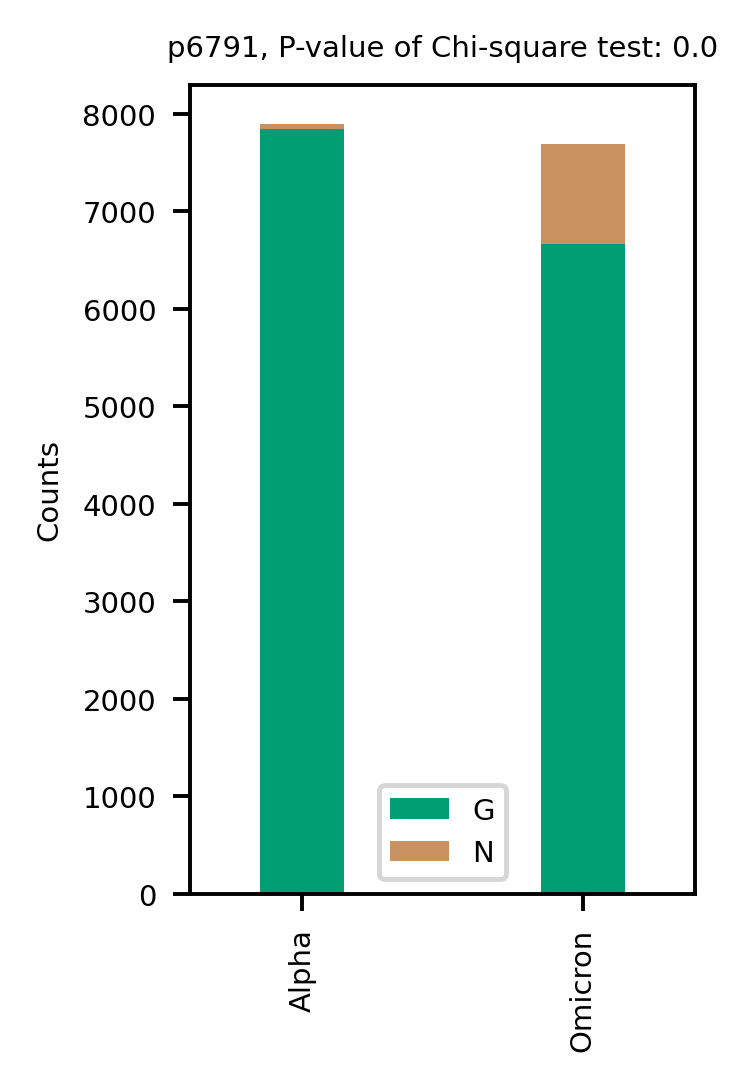

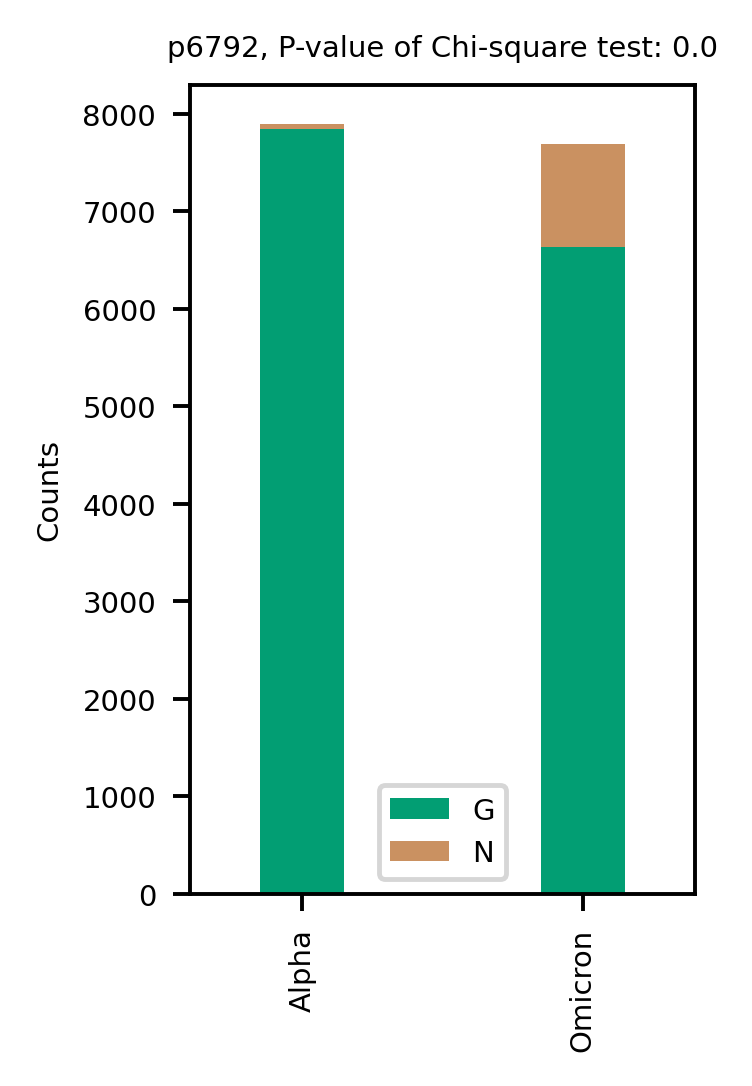

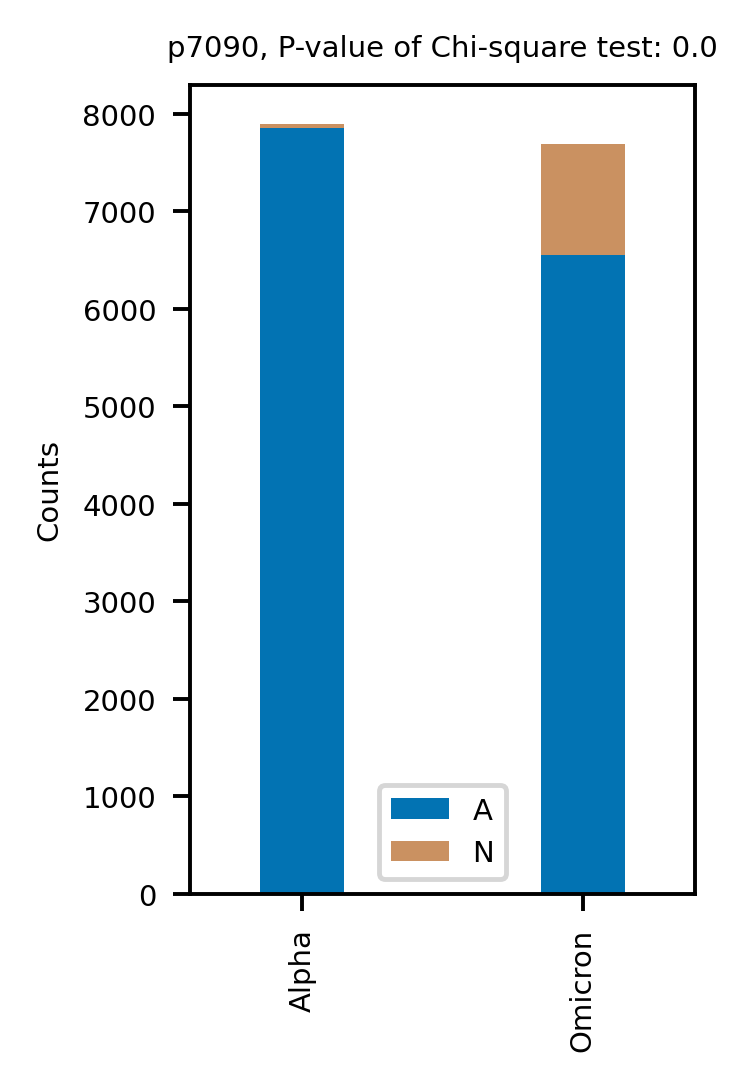

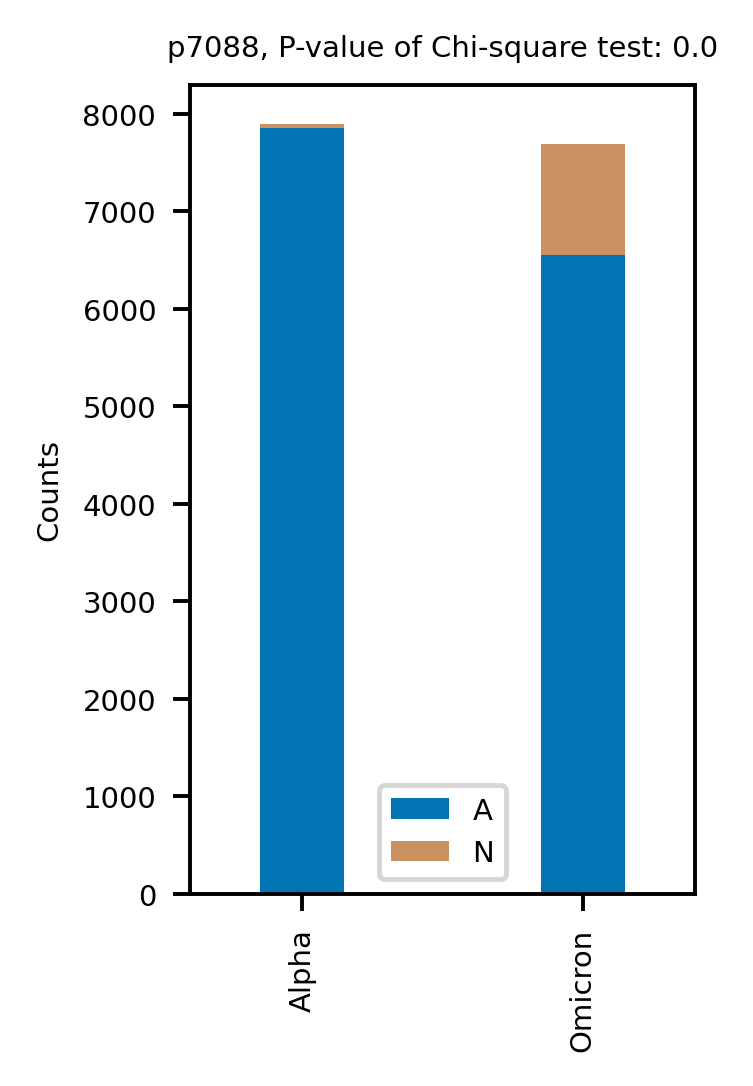

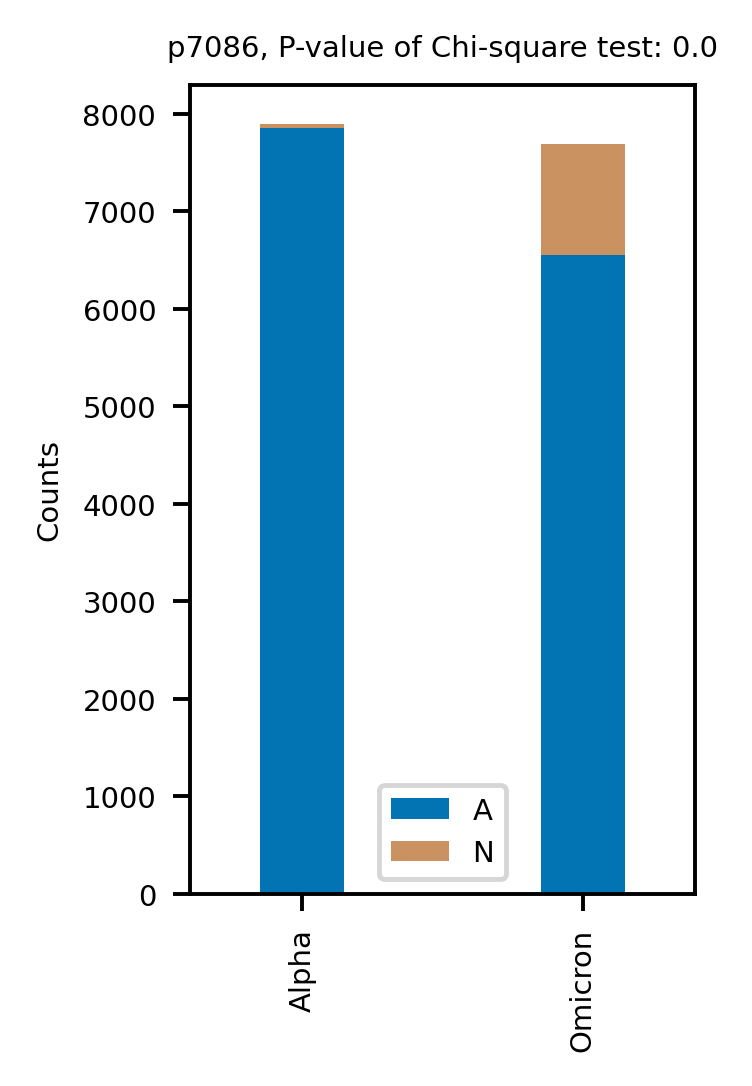

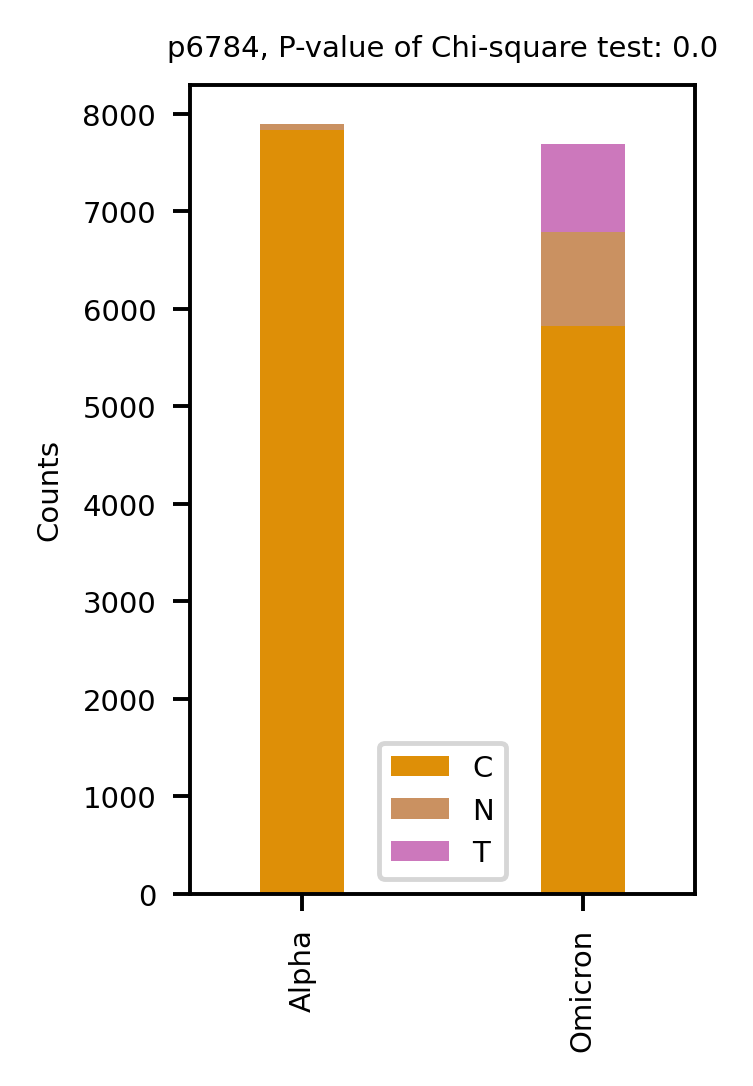

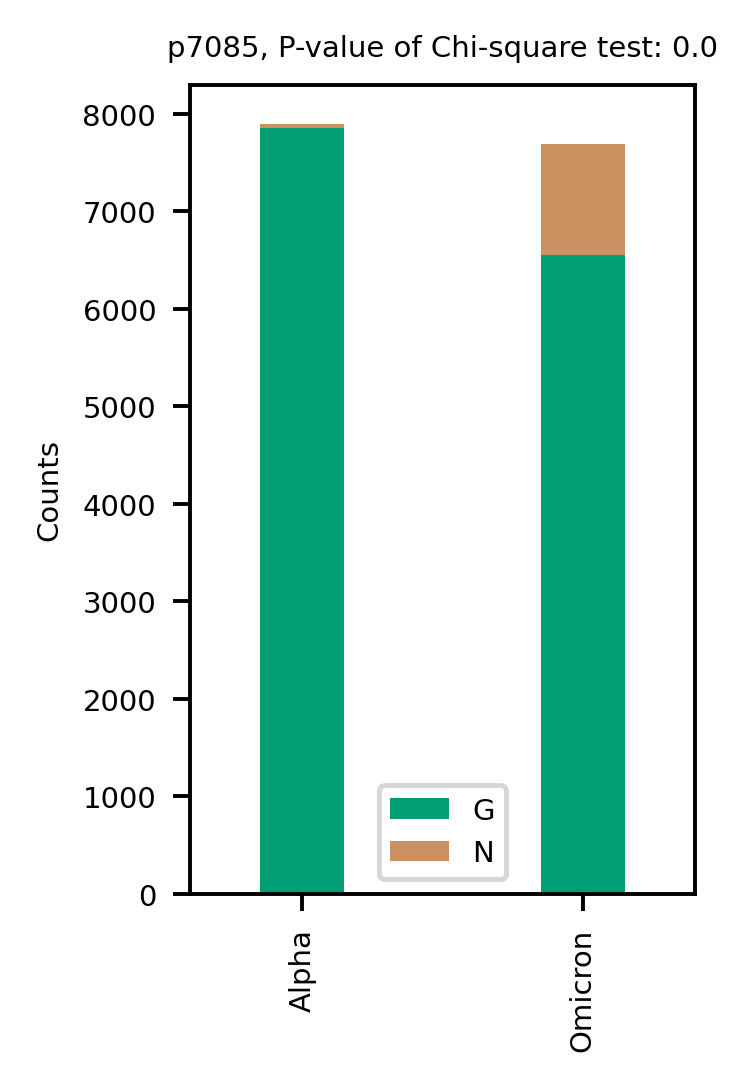

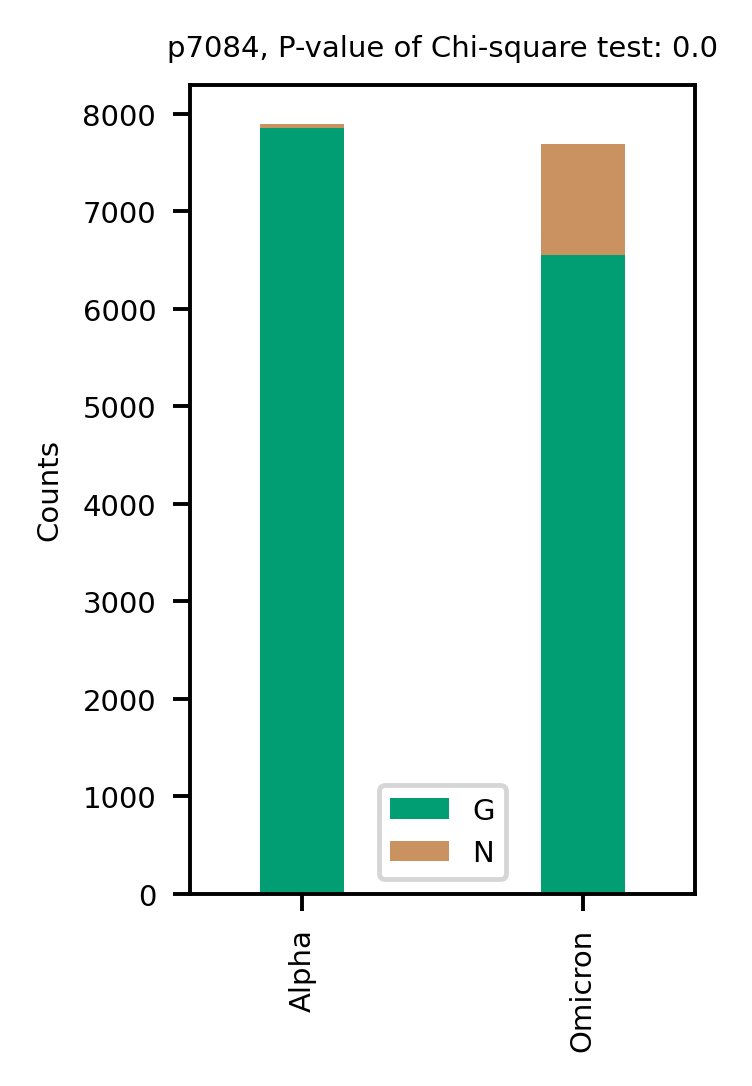

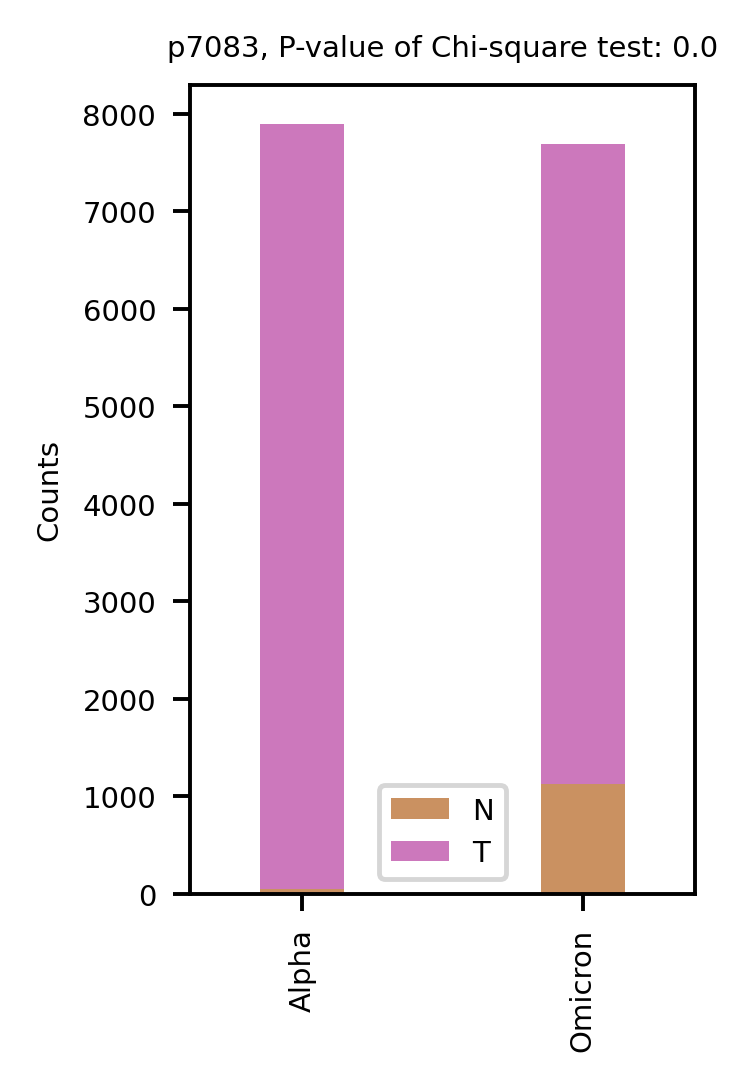

In [40]:
pl = plot_imp_all(final_models=top,
                  X_train=tr, y_train=y, 
                  aggregate_function='max',
                  model_type = ana_type,
                  report_dir=report_dir, max_plots=100,
                  figsize=(1.86, 3))

In [41]:
# printing important positions with their importance values
positions = list(mean_imp.sort_values('mean', ascending=False)['feature'][:100])
importance = list(mean_imp.sort_values('mean', ascending=False)['mean'][:100].round(3))

ref_compare = None
ref_id = -1
compare_len = 100
imp_print(raw_seq, position=positions, importance=importance,
          ref_seq_id=ref_id, compare_with=ref_compare,
          compare_len=compare_len, report_dir=report_dir)

In [43]:
import joblib
load_rf = joblib.load(report_dir+'/rf.pkl')

In [44]:
load_rf

Pipeline(steps=[('prep',
                 Pipeline(steps=[('mc', MisCare(missing_threshold=0.25)),
                                 ('cc', ConstantCare()),
                                 ('ur', URareCare(threshold=0.05)),
                                 ('cc2', ConstantCare()),
                                 ('one_hot', CustomOneHotEncoder()),
                                 ('feature_selection',
                                  FeatureSelection(alpha=0.25, keep=True,
                                                   model_type='cl')),
                                 ('st_sc', CustomStandardScaler()),
                                 ('collinear_care',
                                  CollinearCare(dist_method='correlation',
                                                keep=True, threshold=0.25))])),
                ('rf', RandomForestClassifier(n_jobs=-1, random_state=123))])